# 0.0 Imports

In [1]:
import pickle
import warnings

import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt
import xgboost    as xgb

from IPython.display       import Image
from IPython.core.display  import HTML
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats

from matplotlib            import pyplot as plt
from sklearn               import preprocessing   as pp
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn               import linear_model    as lm

def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()
warnings.filterwarnings( 'ignore' )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.0.1 Helper Functions

In [2]:
#Definindo a função de cramer V
def cramer_v(x,y):
    """Função para executar o cálculo Cramer's V."""
    #Combinações entre as variáveis categóricas, e conta as contagens
    cm = pd.crosstab(x,y).values
    n = int(cm.sum())
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    numbers = [0, chi2 - (k-1)*(r-1)/(n-1)]
    chi2corr = max(numbers)
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    numbers2 = [kcorr-1,rcorr-1]
    
    return np.sqrt((chi2corr/n)/(min(numbers2)))

# 0.1 Loading Dataset

In [3]:
df_raw_train = pd.read_csv('../data/raw/train.csv')

# 1.0 Data Description

In [4]:
df1 = df_raw_train.copy()

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

#Renomeando o nome das colunas
df1.columns = cols_new

<b>id</b> - Unique ID for the customer <br>
<b>Gender</b> - Gender of the customer <br>
<b>Age</b> - Age of the customer <br>
<b>Driving_License</b> - 0 : Customer does not have DL, 1 : Customer already has DL <br>
<b>Region_Code</b> - Unique code for the region of the customer <br>
<b>Previously_Insured</b> - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance <br>
<b>Vehicle_Age</b> - Age of the Vehicle <br>
<b>Vehicle_Damage</b> - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. <br>
<b>Annual_Premium</b> - The amount customer needs to pay as premium in the year <br>
<b>Policy_Sales_Channel</b> - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. <br>
<b>Vintage</b> - Number of Days, Customer has been associated with the company <br>
<b>Response</b> - 1 : Customer is interested, 0 : Customer is not interested

## 1.1 Data Dimension

In [6]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 381109
Número de colunas: 12


## 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()
#Por um milagre não tem NA

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [9]:
num_attr = df1.select_dtypes(include=['int64','float64'])
cat_attr = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [10]:
# Ter uma noção geral das métricas do negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T
d2 = pd.DataFrame(num_attr.apply(np.min)).T
d3 = pd.DataFrame(num_attr.apply(np.max)).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

#Concaterando as métricas
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engeneering

In [11]:
df2 = df1.copy()

In [12]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering

In [13]:
df3 = df2.copy()

In [14]:
#Nada muito discrepante no dataset, portanto, nada para filtrar por hora

# 4.0 Exploration Data Analysis

In [15]:
df4 = df3.copy()

## 4.1 Bivariate Analysis

In [16]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

O que o modelo quer fazer? <br>
Ele quer descobrir um hiperplano no espaço que pode separar essas classes<br>
Com isso, queremos encontrar algumas features que nos ajude a separar os clientes que querem o novo produto do que não querem <br>
Features que misturam isso são ruins, confundem mais que ajudam o classificador<br>
Olhamos se cada variável vai bagunçar ou ajudar a separar o dataset<br>
Procuramos variáveis que são separadas entre si

### 4.1.1 - Age

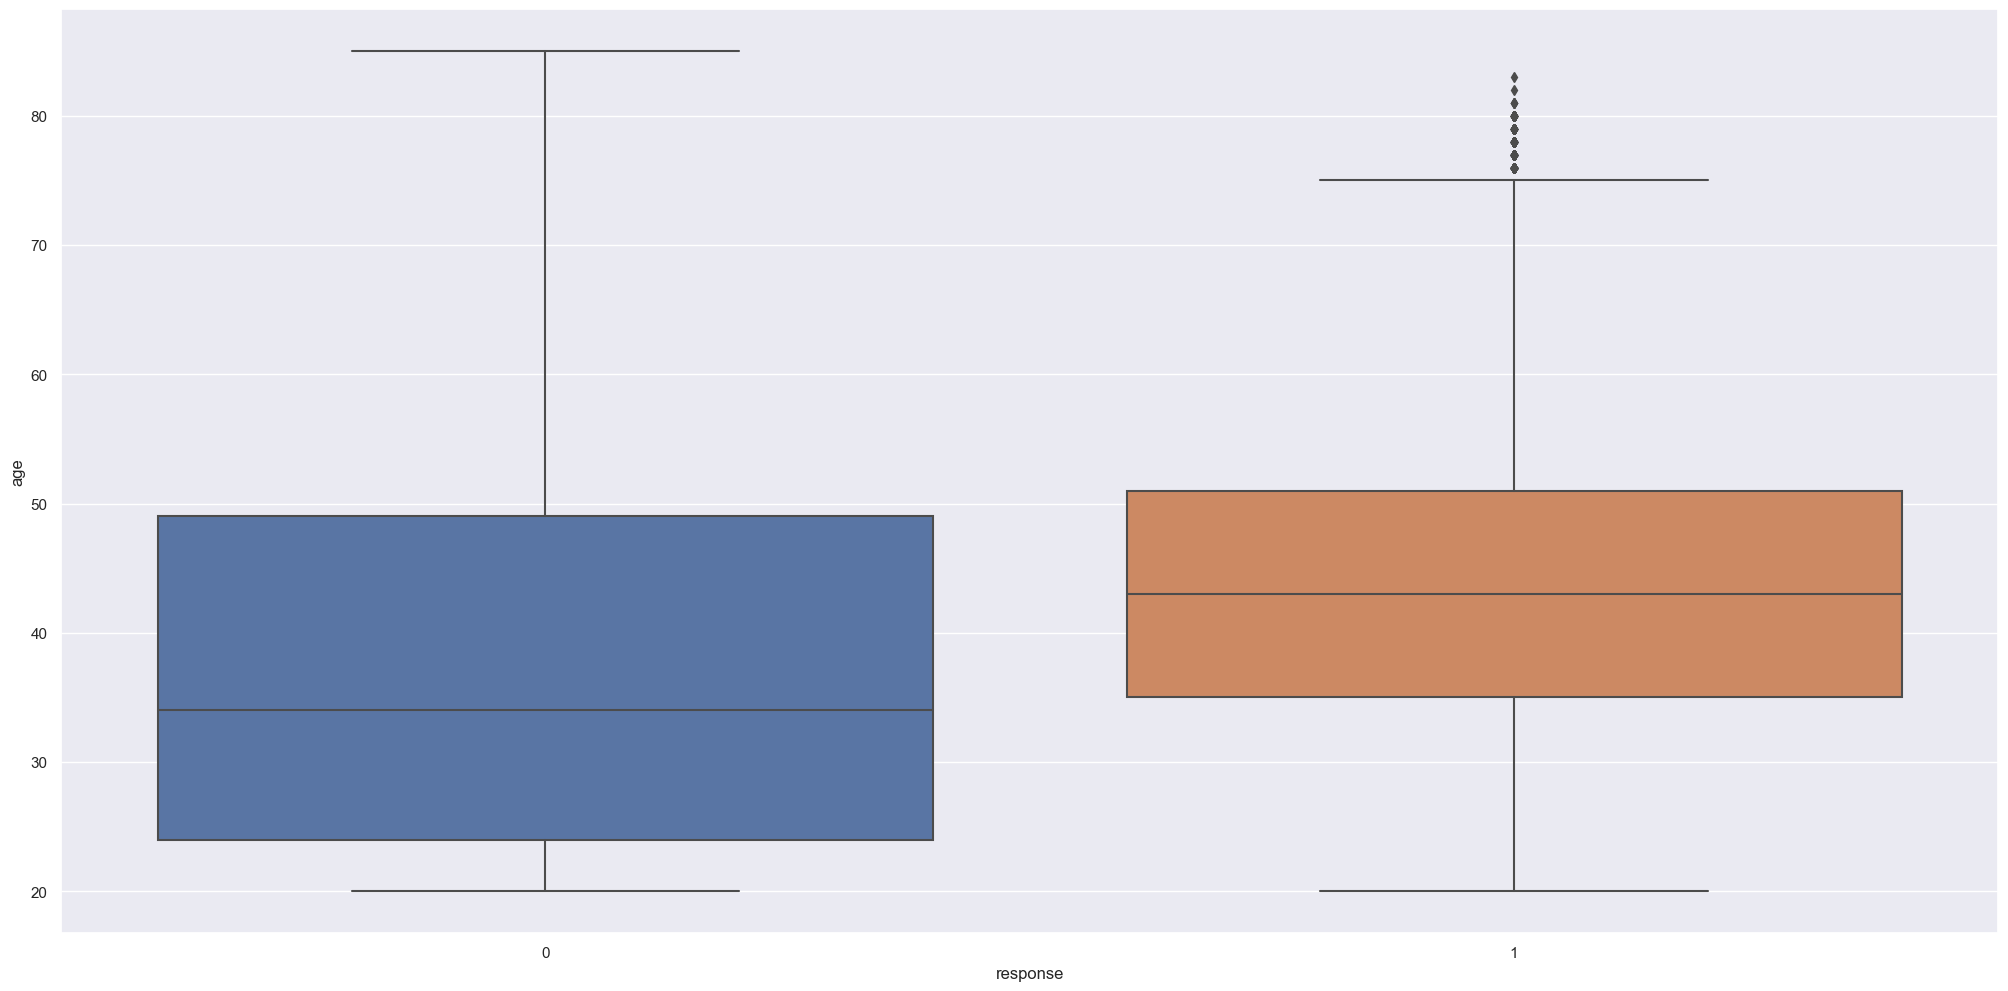

In [17]:
#age - Número naturais
#Quero olhar as medianas de cada um dos grupos com relação a idade
sns.boxplot(x='response',y='age',data=df4);

#Vemos o distribuição deslocada, uma mediana maior pra quem adiquiriu o seguro, pessoas mais novas não tem interesse

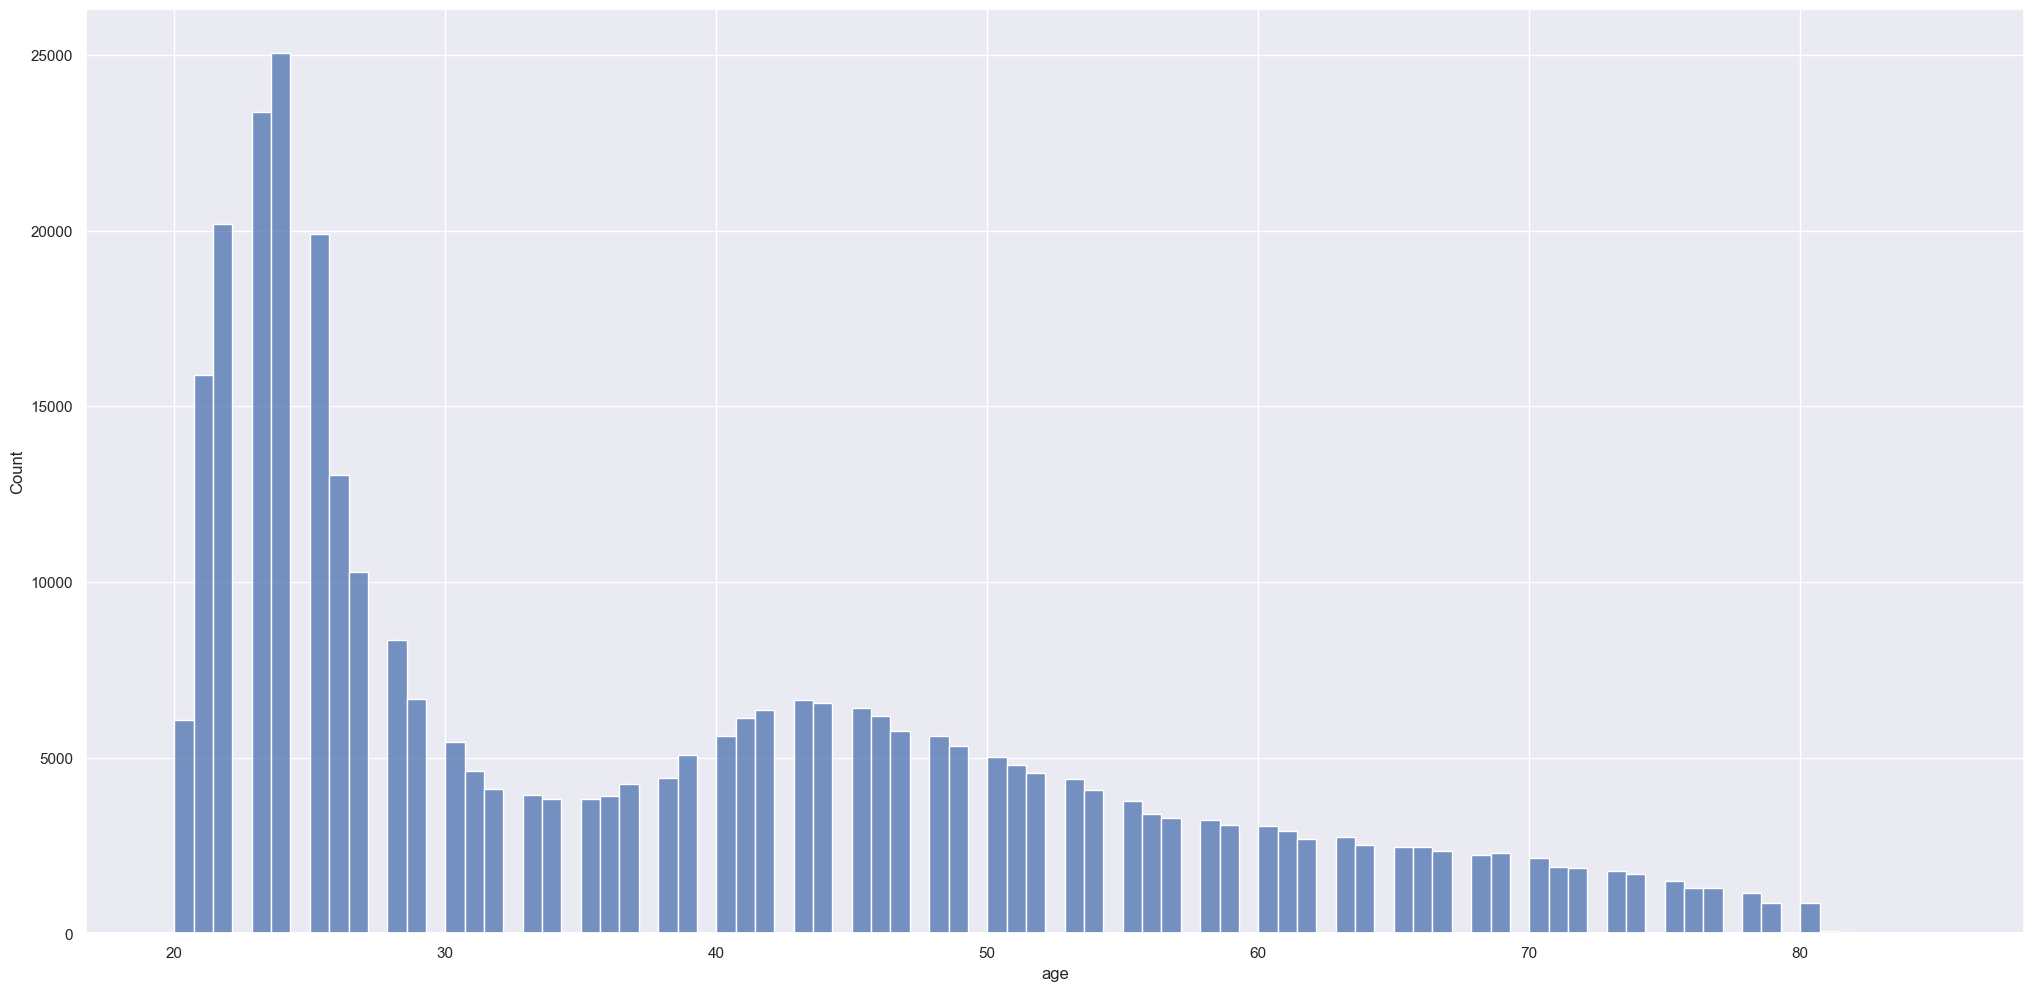

In [19]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00);

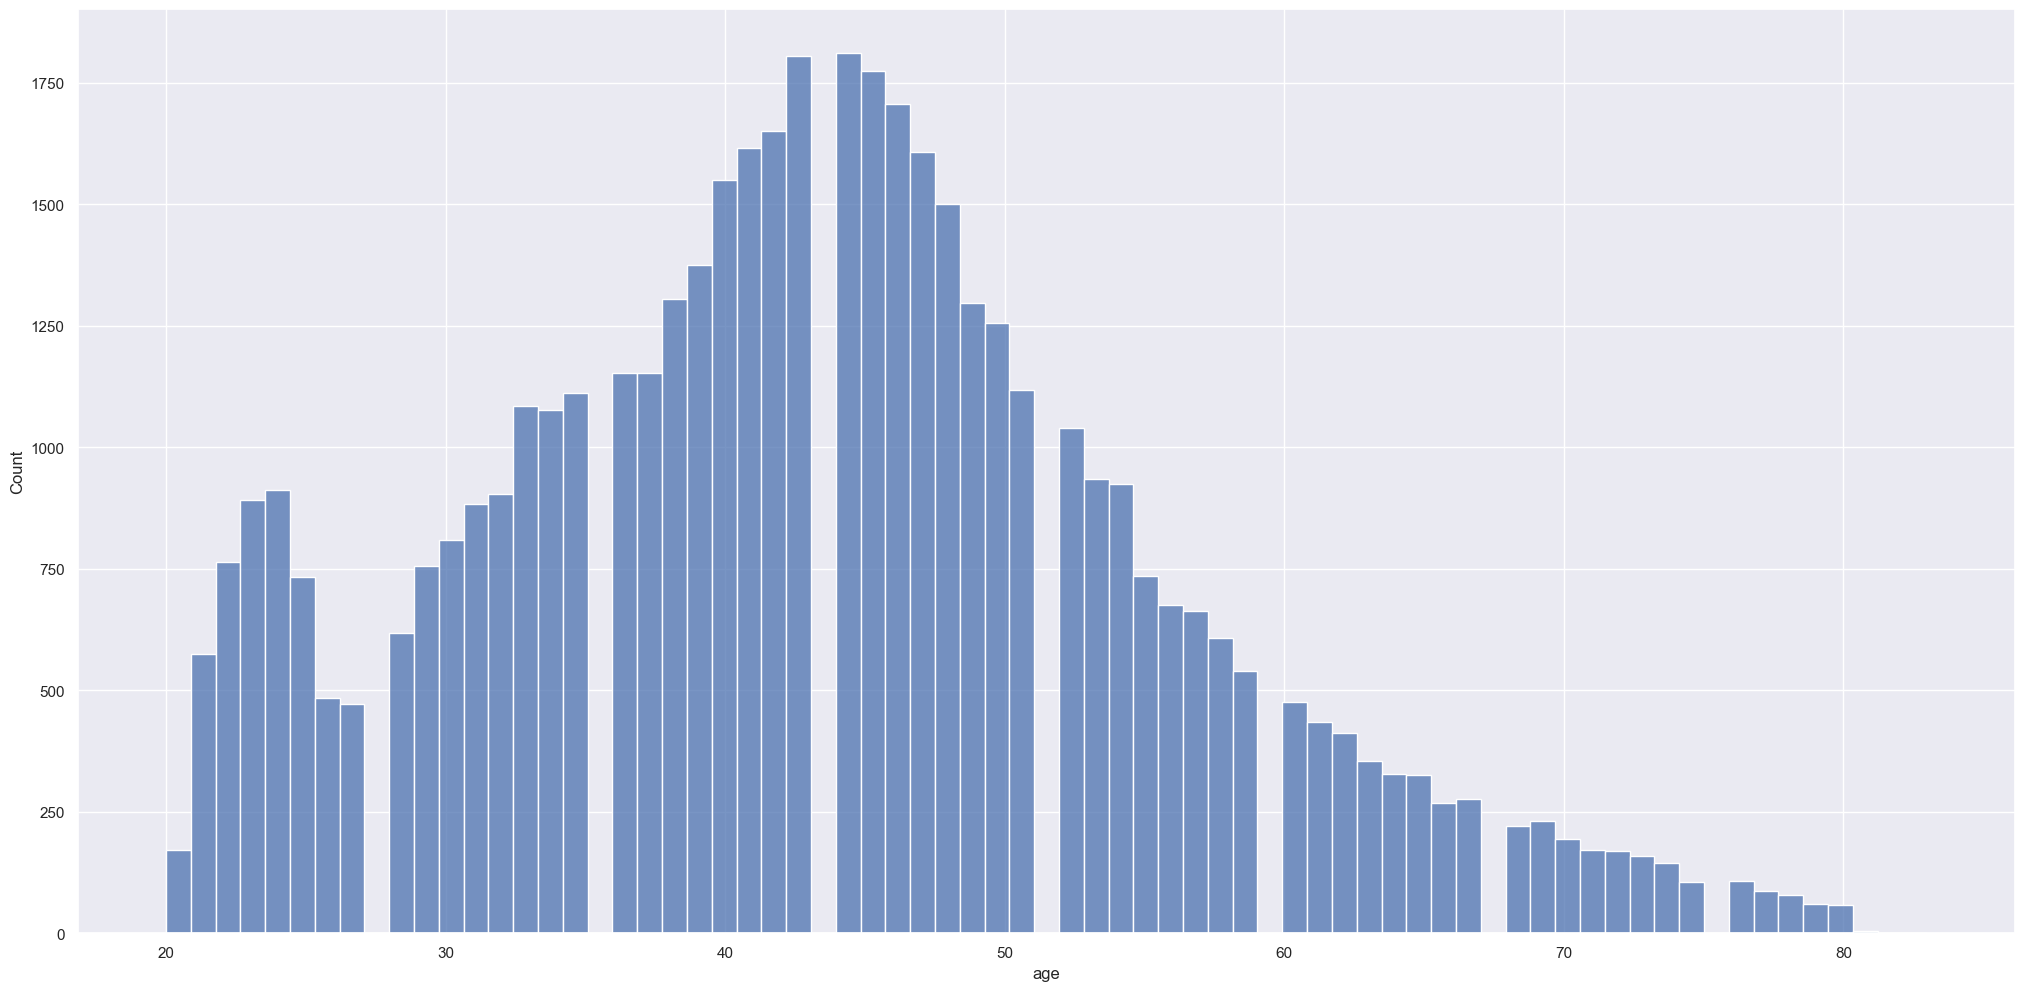

In [20]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00);

### 4.1.2 - Gender

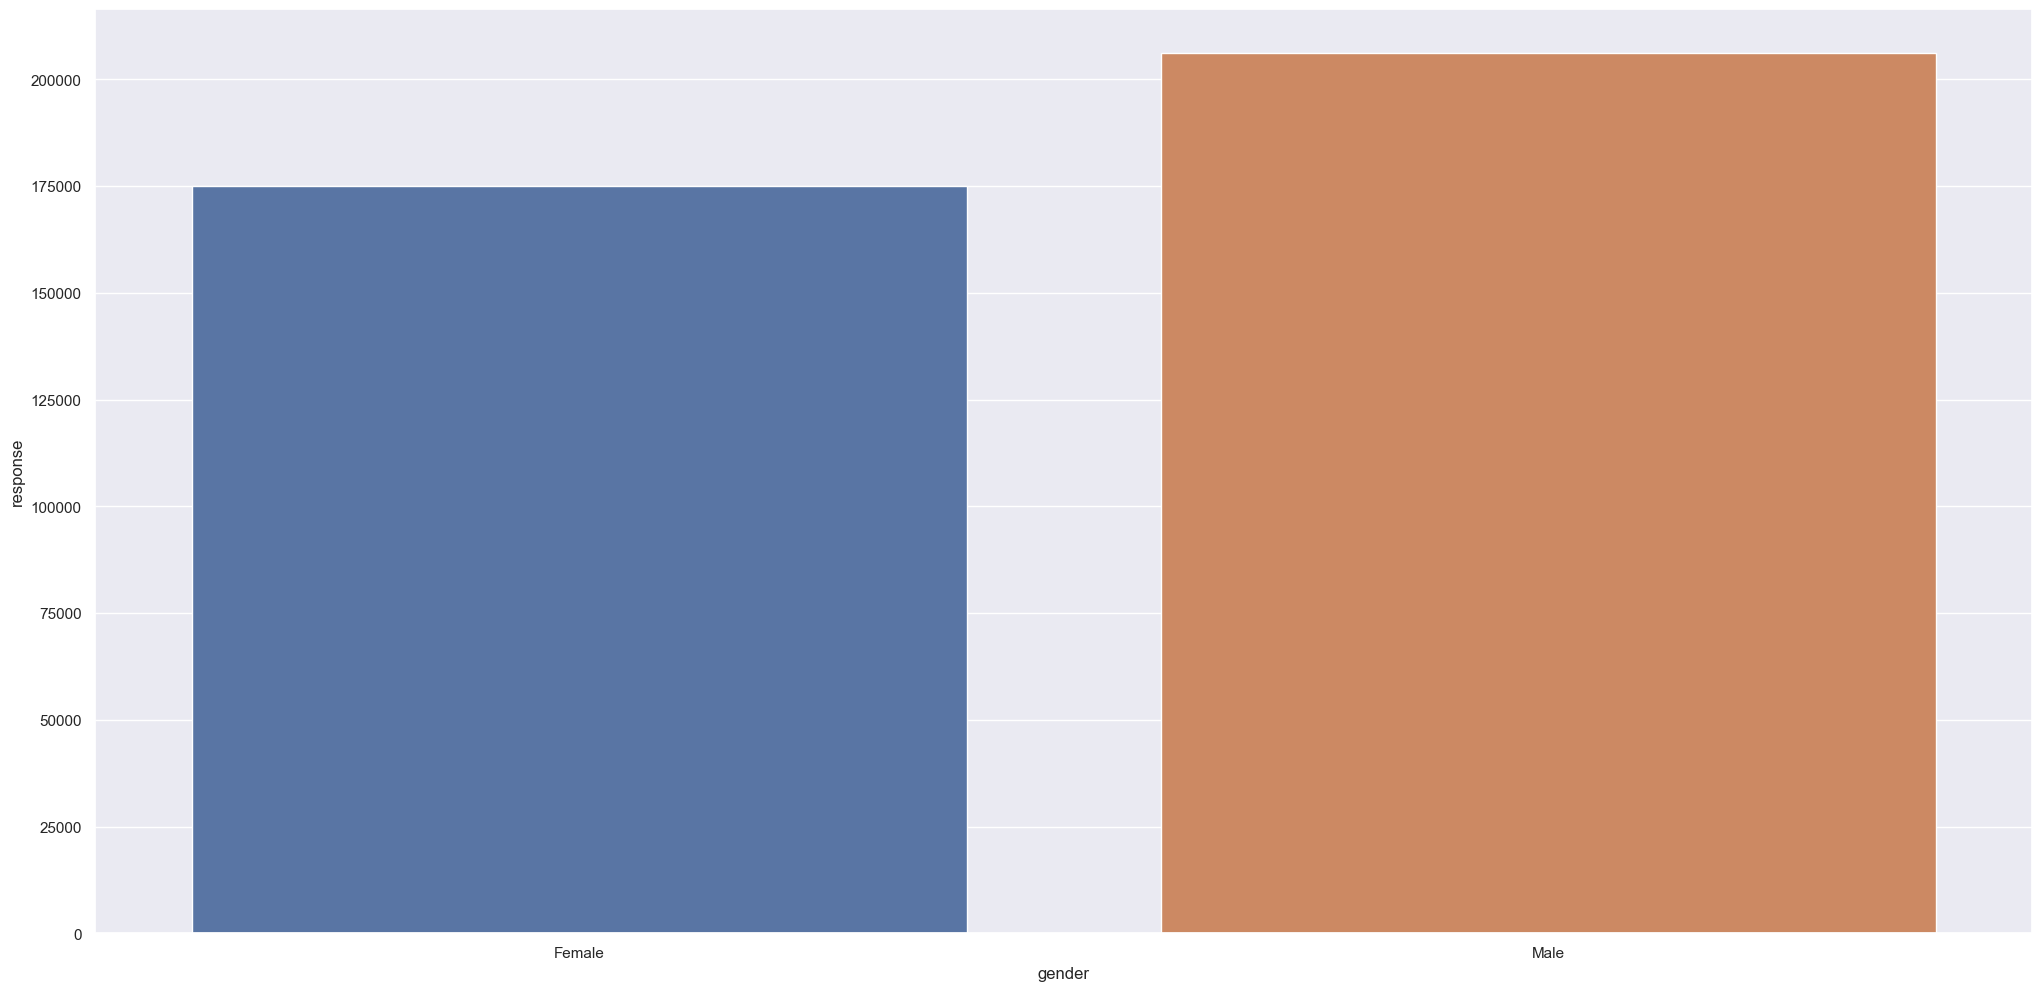

In [18]:
#gender
aux = df4[['gender','response']].groupby('gender').count().reset_index()
sns.barplot(y='response',x='gender',data=aux);

### 4.1.3 - Annual Premium

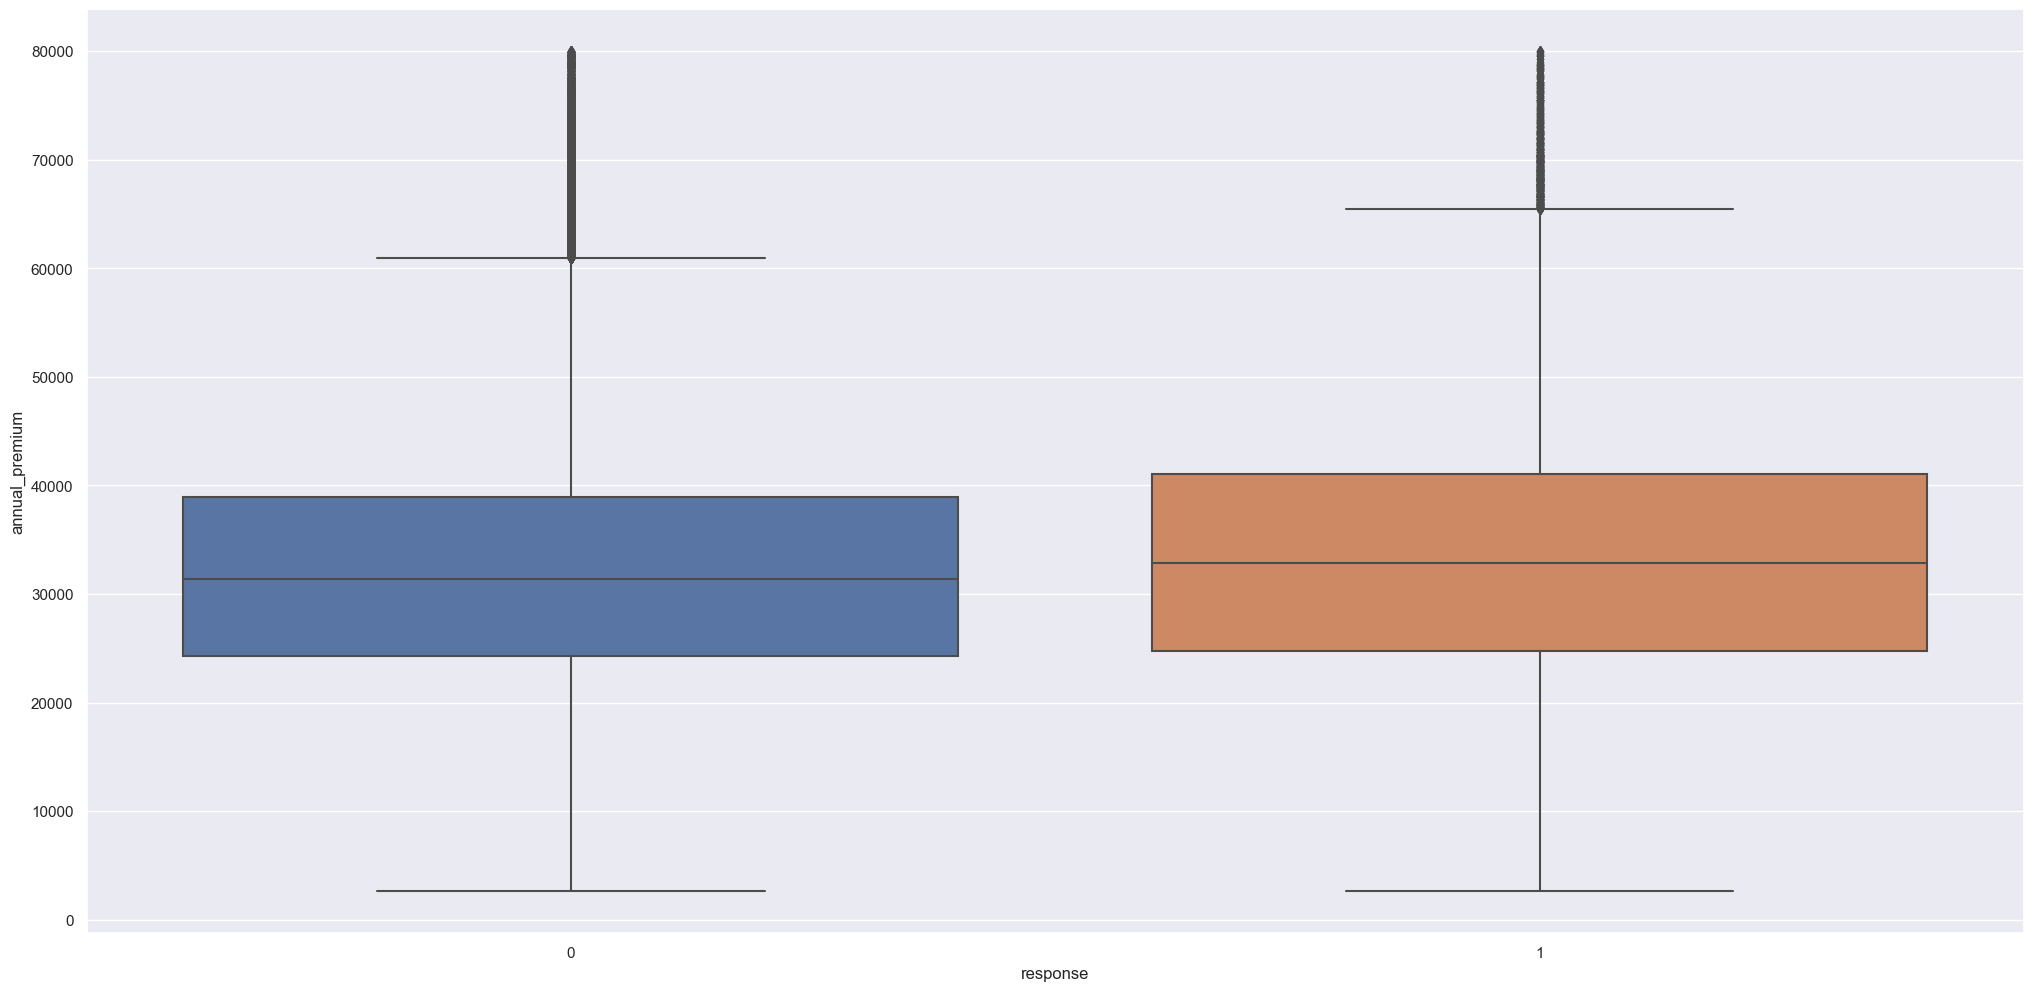

In [21]:
#annual_premium
aux = df4.loc[df4['annual_premium'] < 80000, :]
sns.boxplot(x='response',y='annual_premium',data=aux);

#Está muito bagunçado e tem muitos outliers
#Medianas muito próximas
#Sozinha não está diferenciando os dados
#Distribuição muito parecida, não me ajuda a diferenciar as observações nas classes
#Não é discriminatória

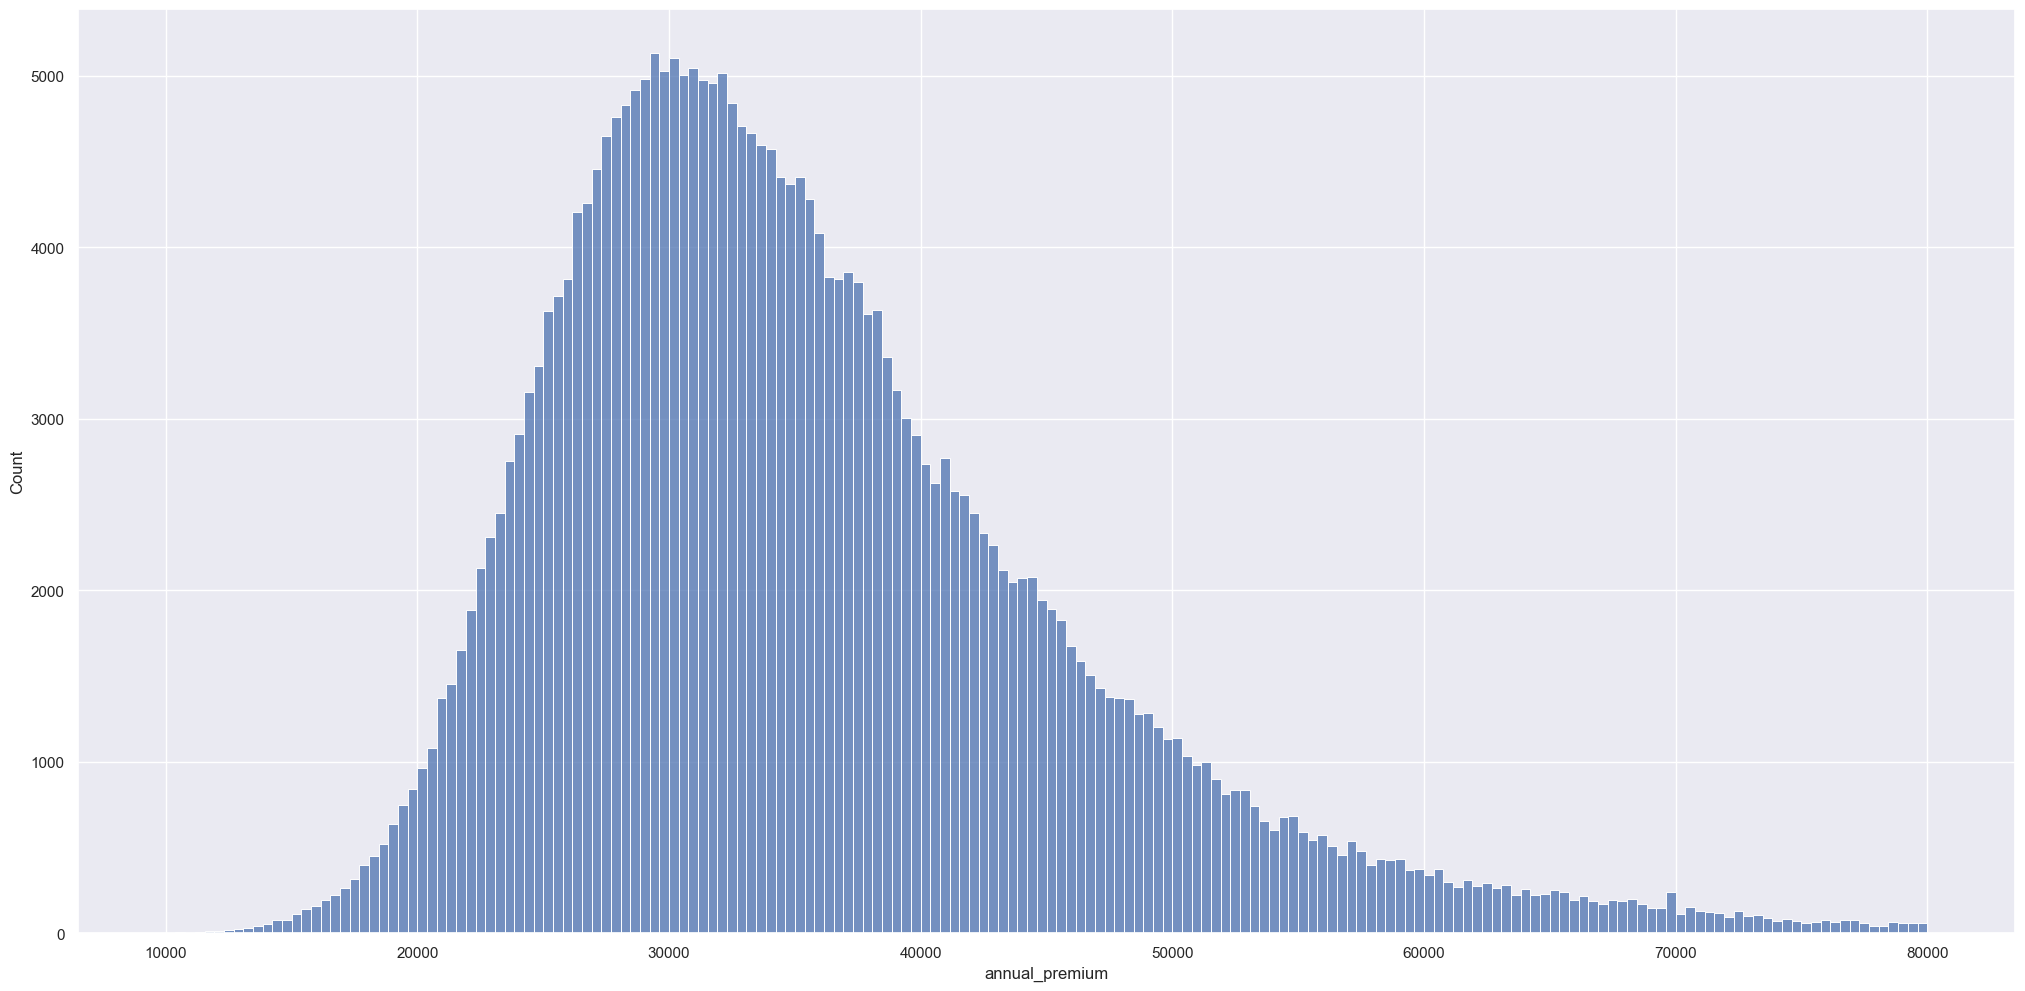

In [22]:
aux = df4.loc[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000), :]
aux00 = aux.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux00);

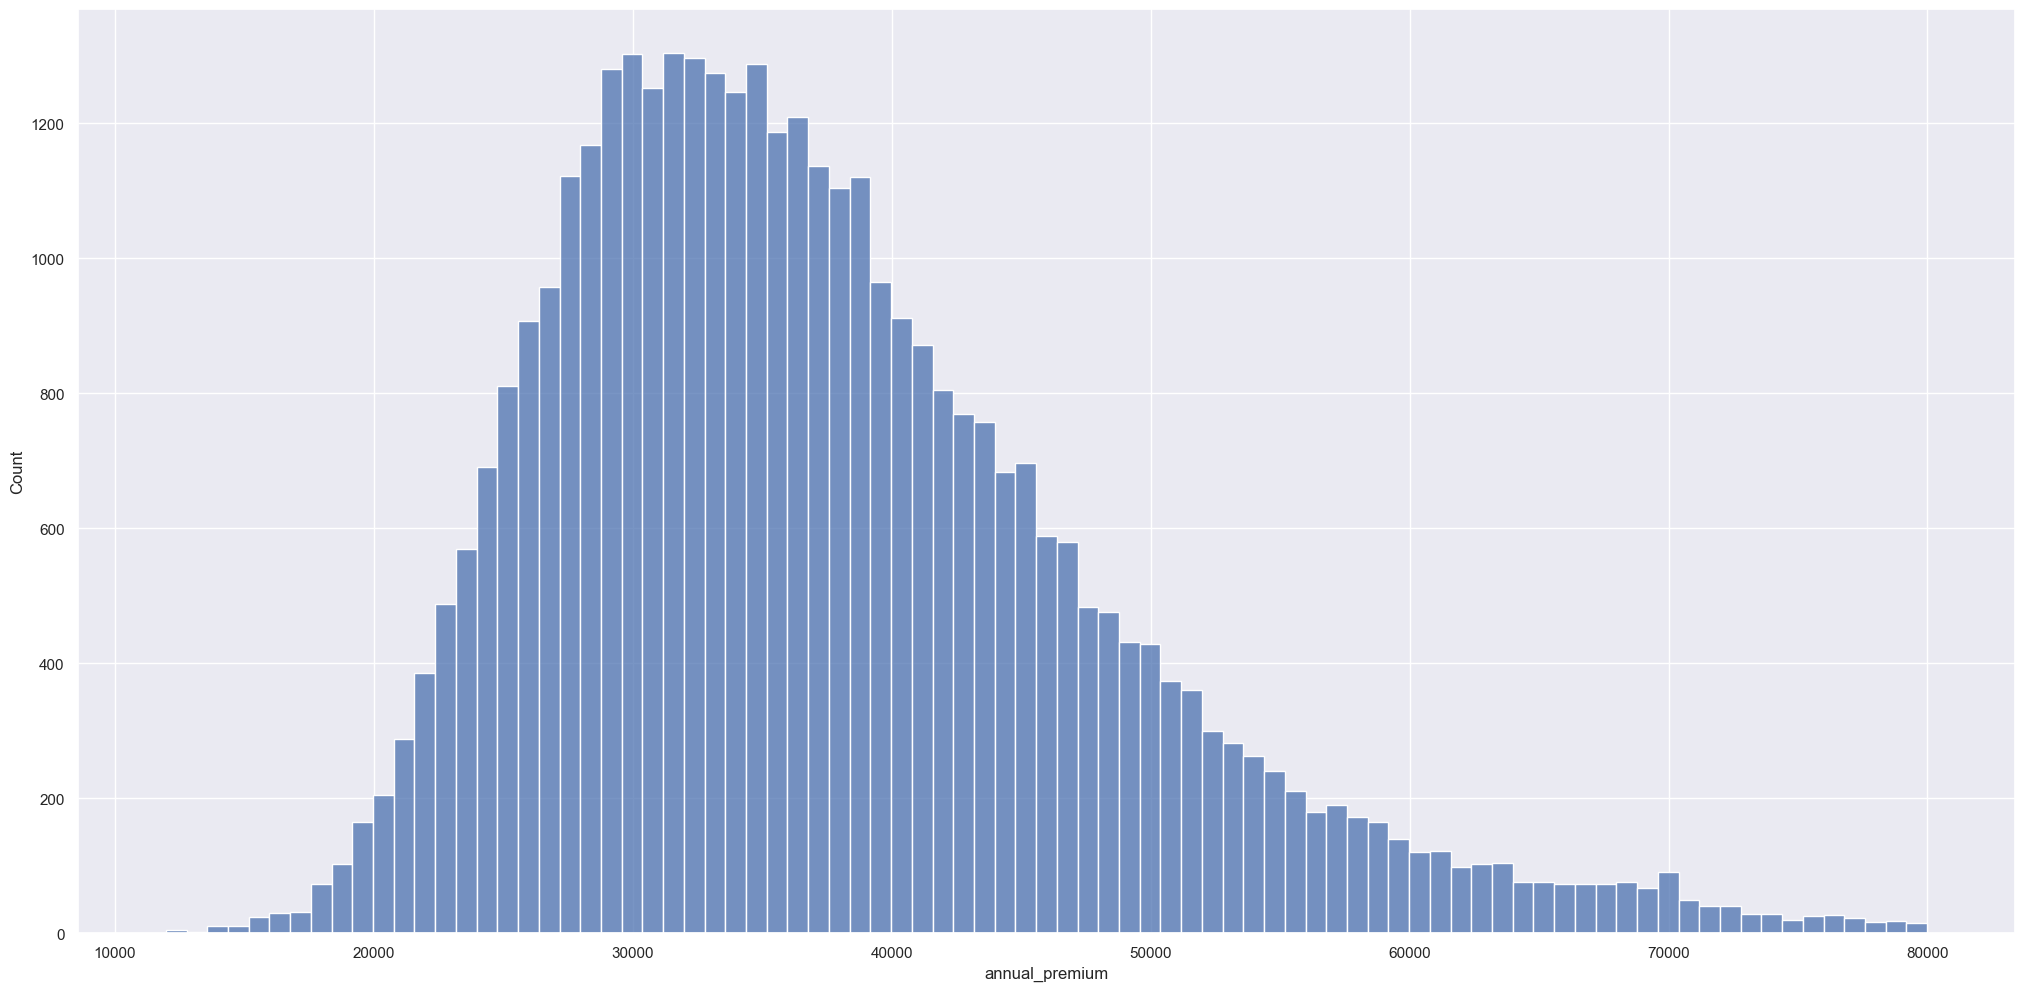

In [23]:
aux00 = aux.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux00);

### 4.1.4 - Driving License

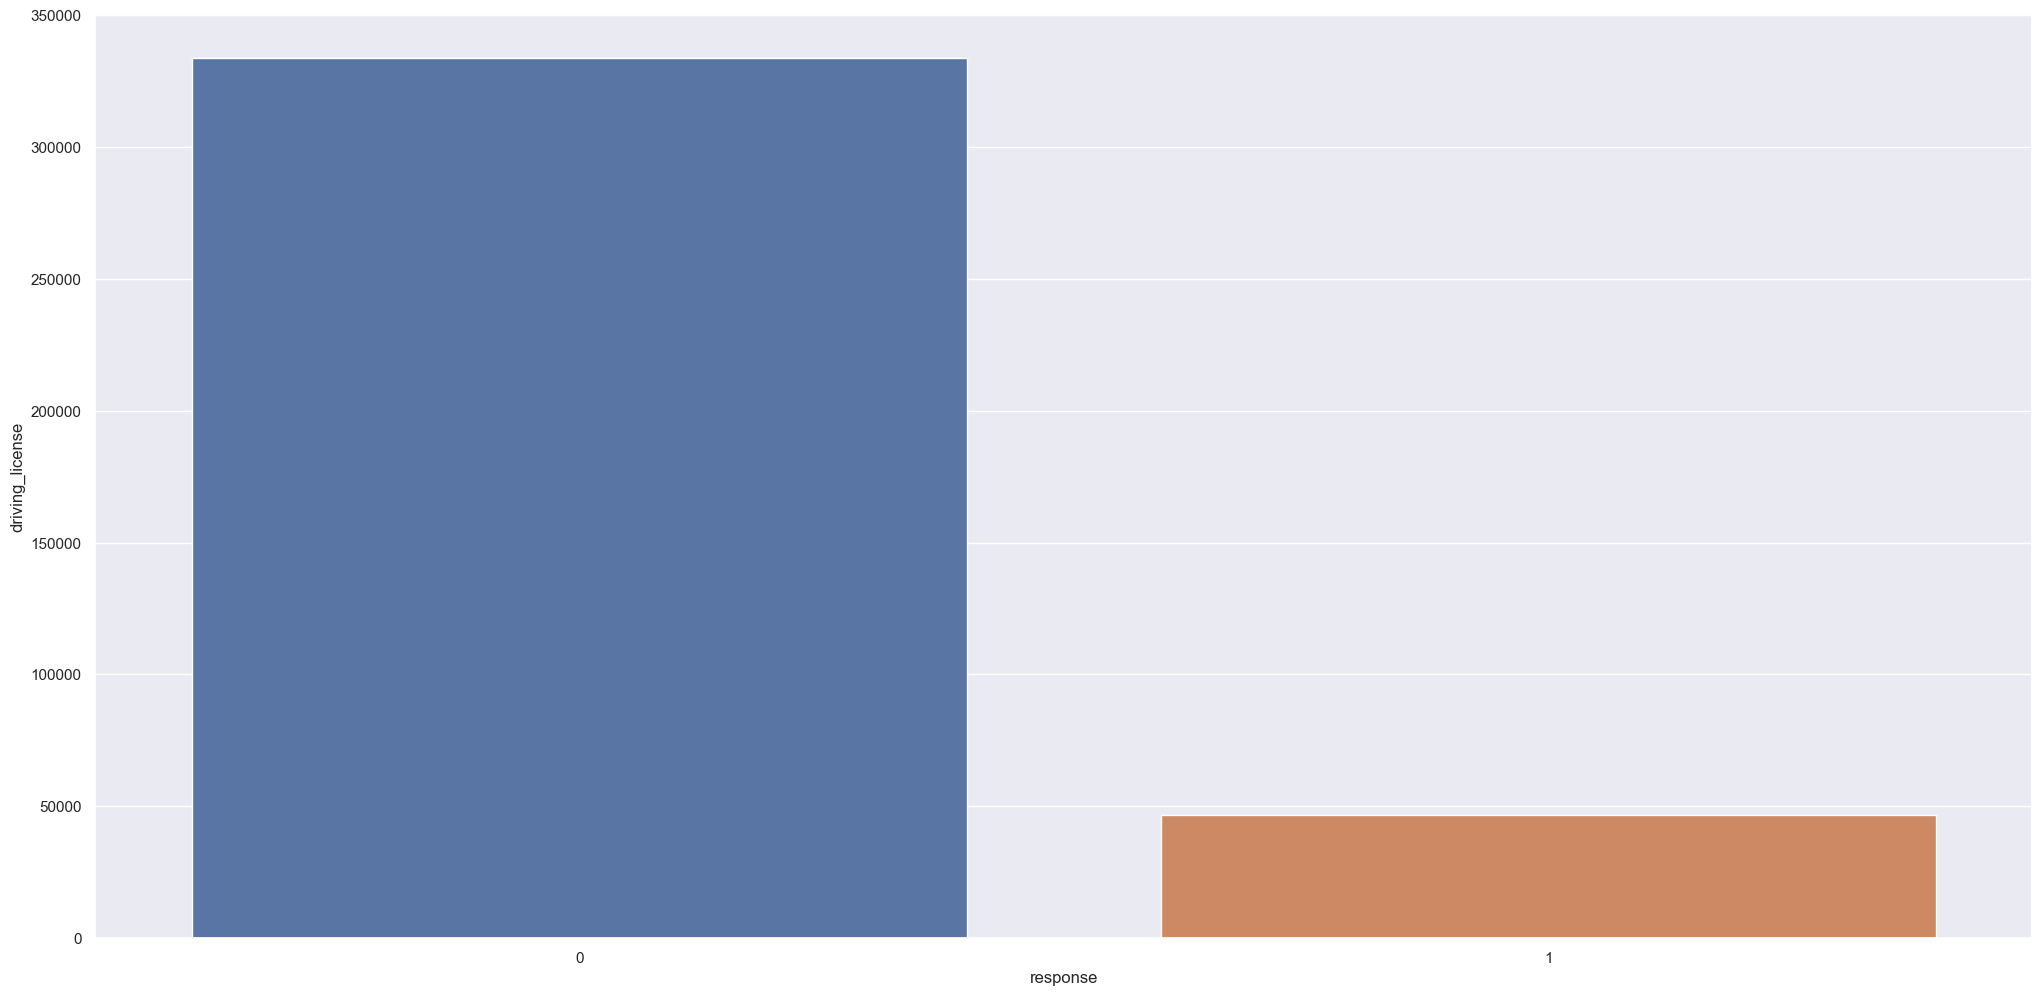

In [25]:
#driving_license
aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
sns.barplot(x='response',y='driving_license',data=aux);


#333628 pessoas que dirigem e não querem fazer o seguro de carro
#Maioria das pessoas que não querem o seguro, dirigem, e isso é contra intuitivo

### 4.1.5 - Region Code

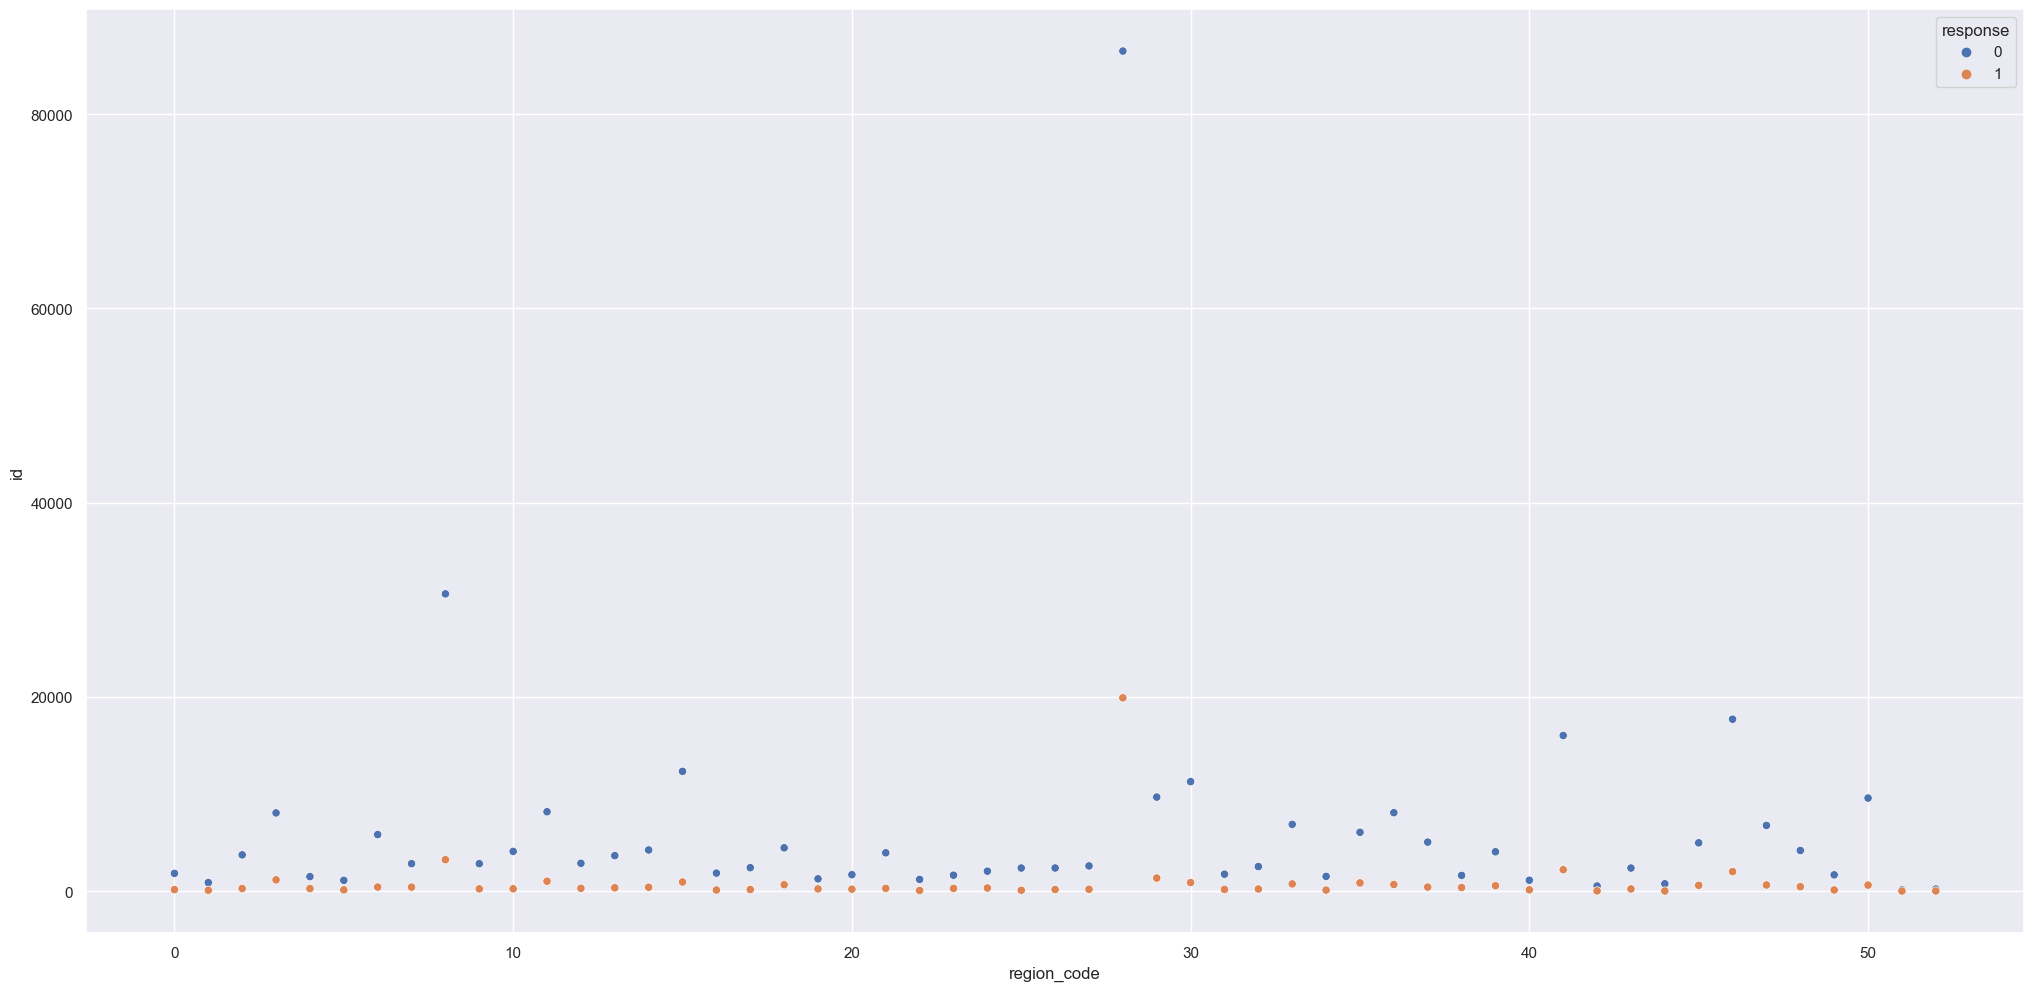

In [26]:
#region_code - procurar um grupo que que tenha mais frequência
aux = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response',data=aux); #hue define as cores

#No region_code 28, por ai, temos uma grande quantidade de 0, em relação ao 1
#Mas fora isso, nada que salte aos olhos e ajude a separar o response
#Então, sozinha, essa variável também não nos ajuda

### 4.1.6 - Previously Insured

In [27]:
#previously_insured
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x/x.sum(),axis=1)
#Tabela de contingência
#Mostra a relação de contagem entre as variáveis categóricas
#Pode ser uma variável indicativa
#Pessoas que já tem seguro de carro, não querem mudar
#Pode ser um vazamento de dados, muito relacionado com a variável resposta, se tem seguro, não quer o meu

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.7 - Vehicle Age

In [28]:
#vehicle_age
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')

#Acima de 2 anos não descrimina bem
#Mas antes disso, apresenta uma diferenciação

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 4.1.8 - Vehicle Damage

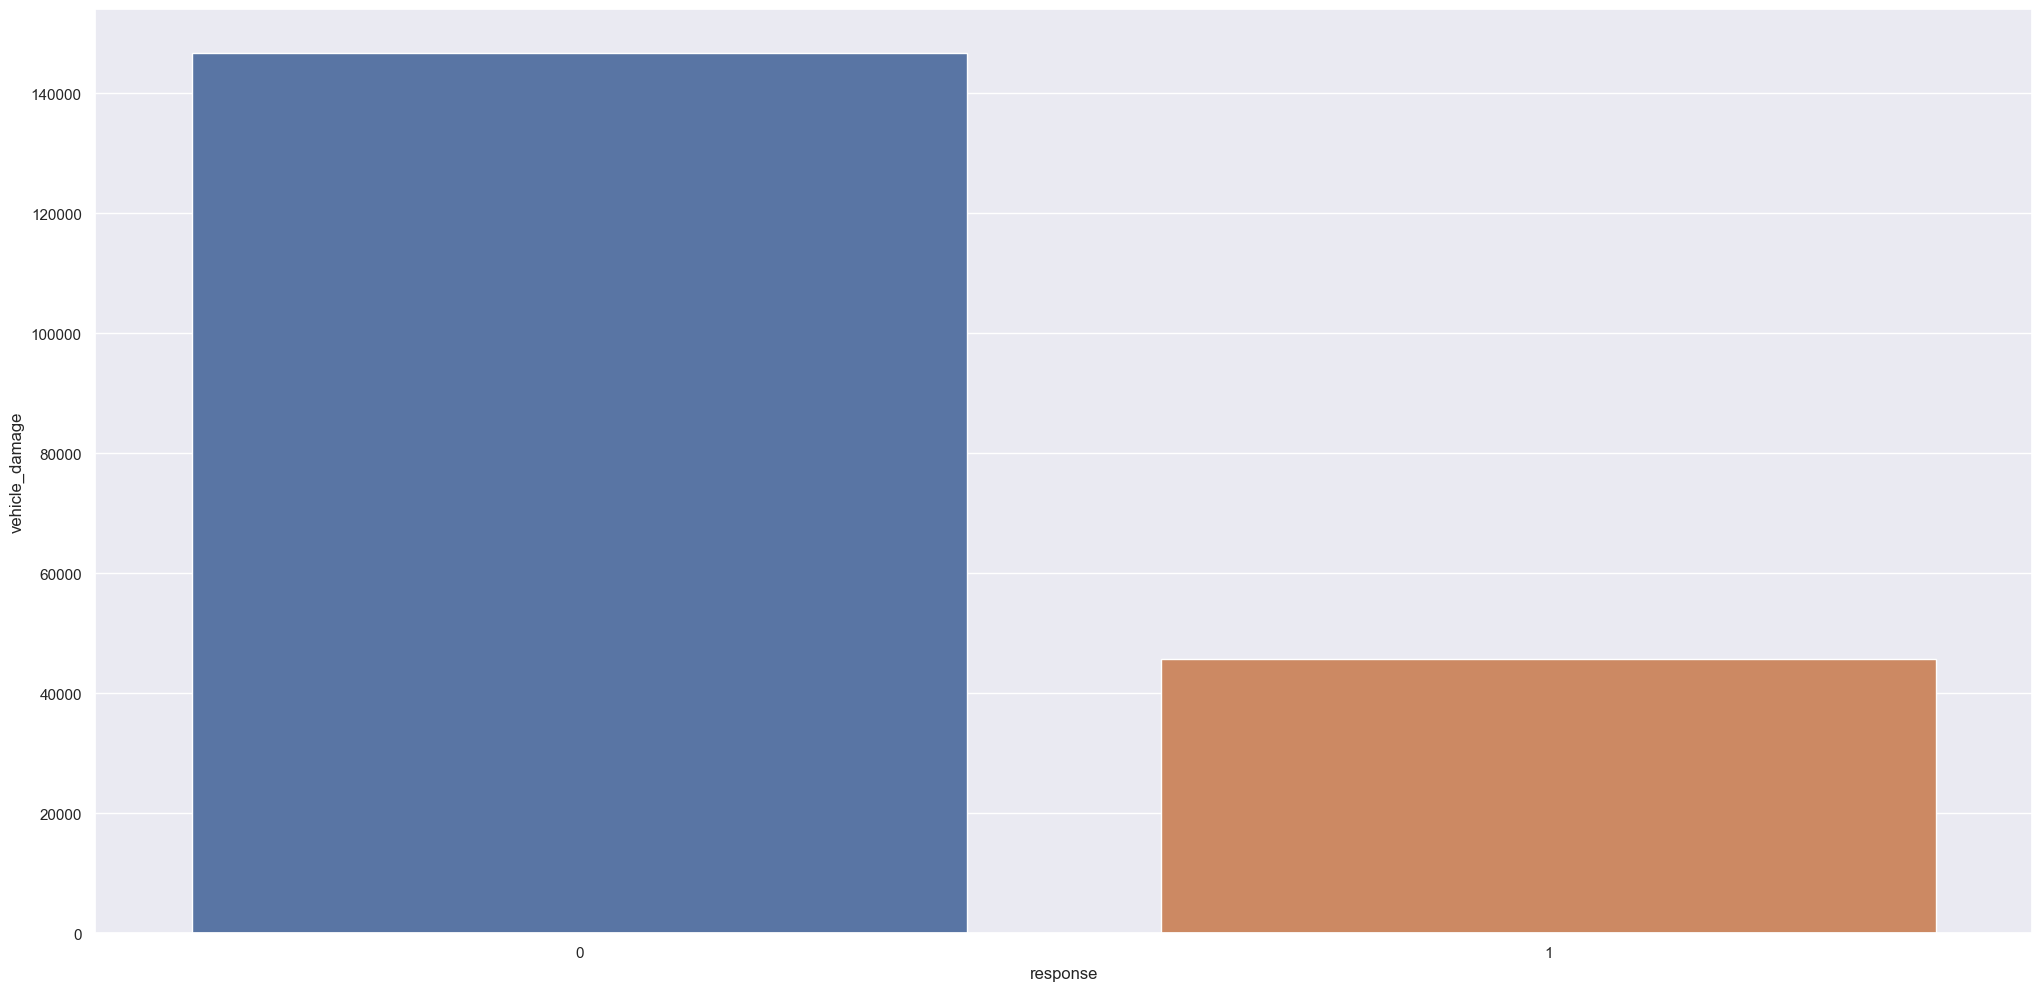

In [29]:
#vehicle_damage
aux = df4[['vehicle_damage','response']].groupby('response').sum().reset_index()
sns.barplot(x='response',y='vehicle_damage',data=aux);

### 4.1.9 - Policy Sales Channel

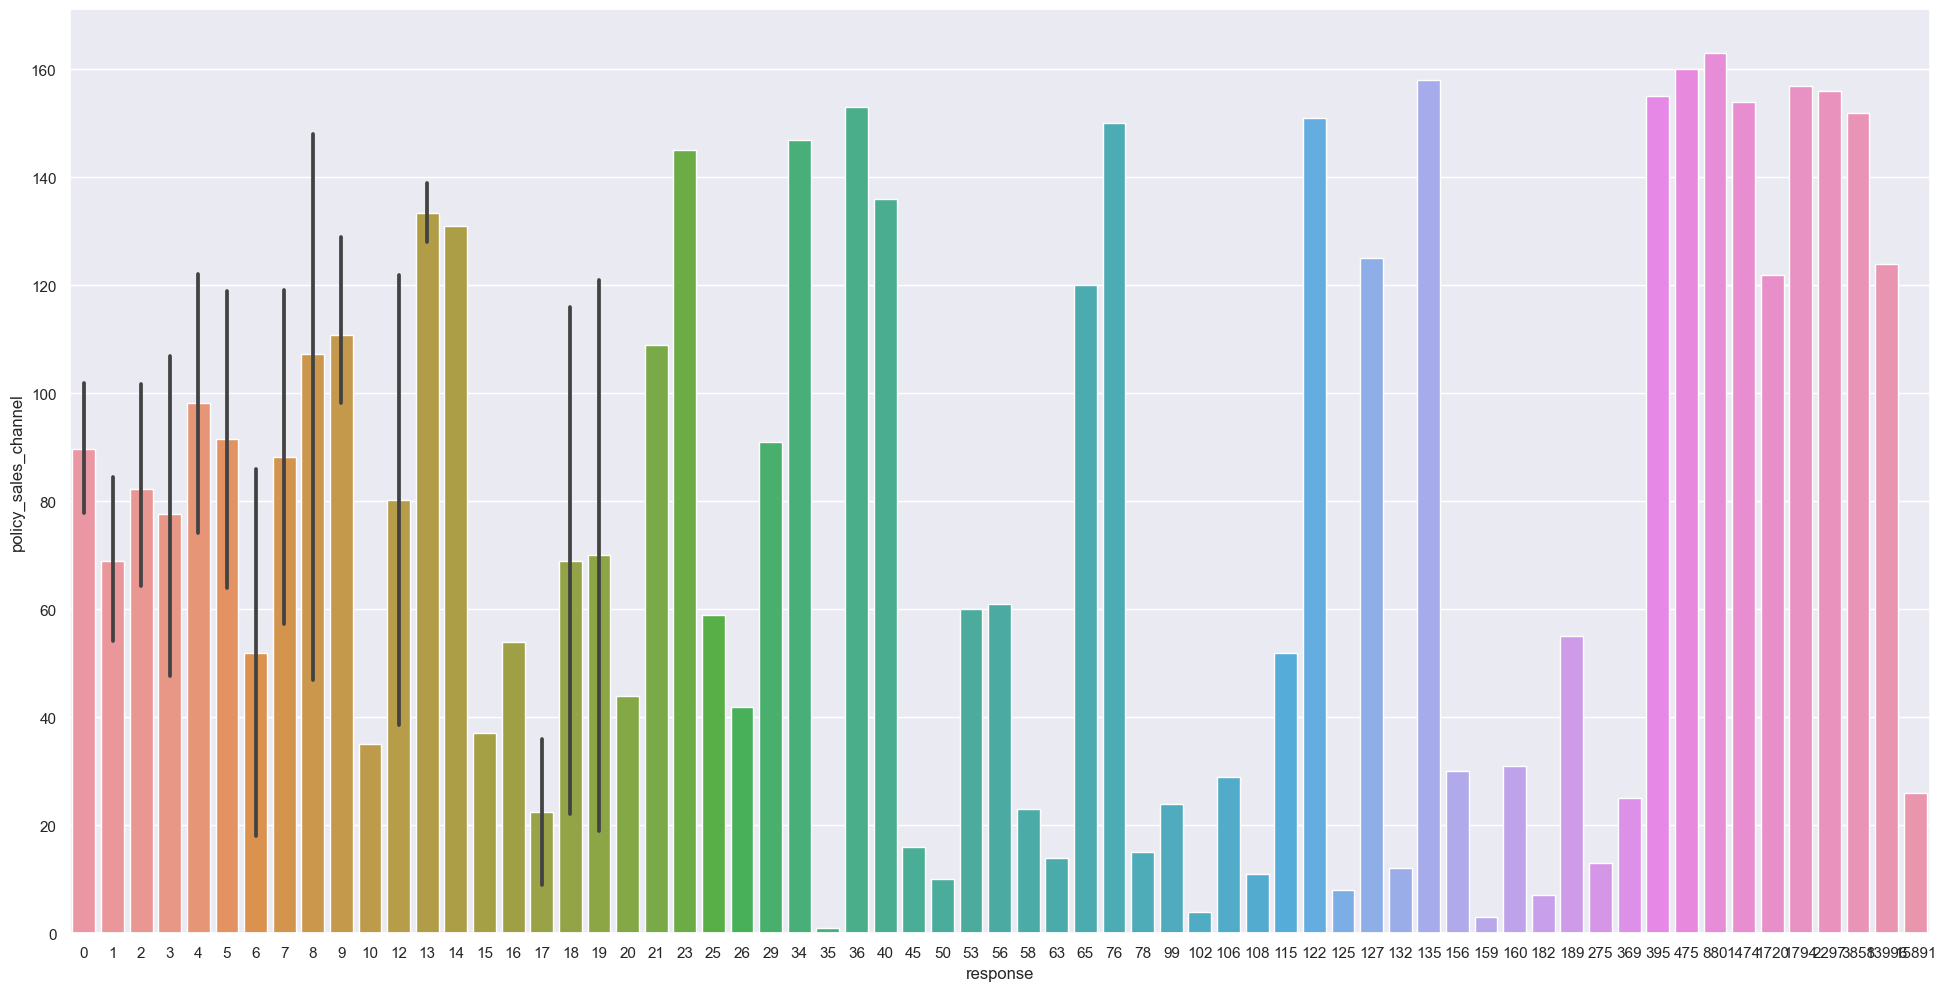

In [30]:
#policy_sales_channel
plt.figure(figsize=(24,12))
aux = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(y='policy_sales_channel',x='response',data=aux);

### 4.1.10 - Vintage

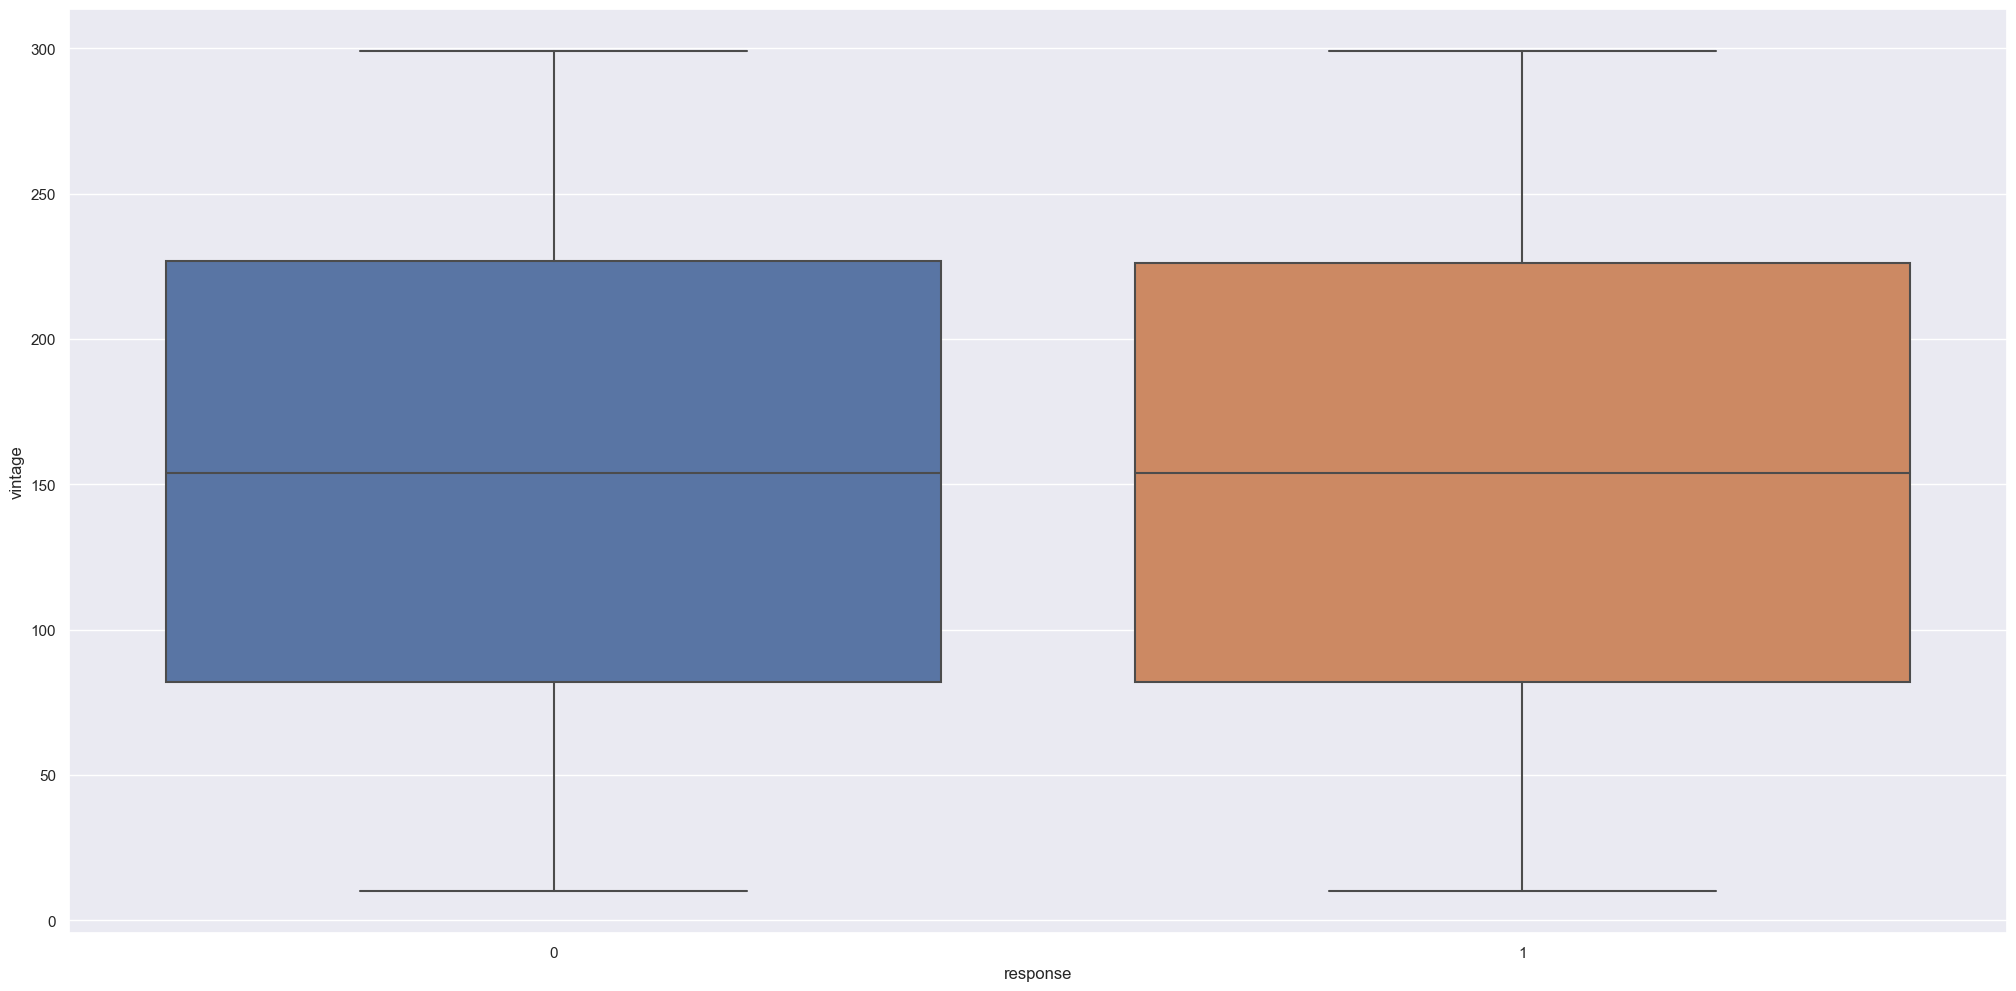

In [31]:
#vintage - Fala quanto tempo a pessoa está na base
sns.boxplot(x='response',y='vintage',data=df4);

#São muito parecidas, mas a distribuiçao é uniforme, não nos diz muito

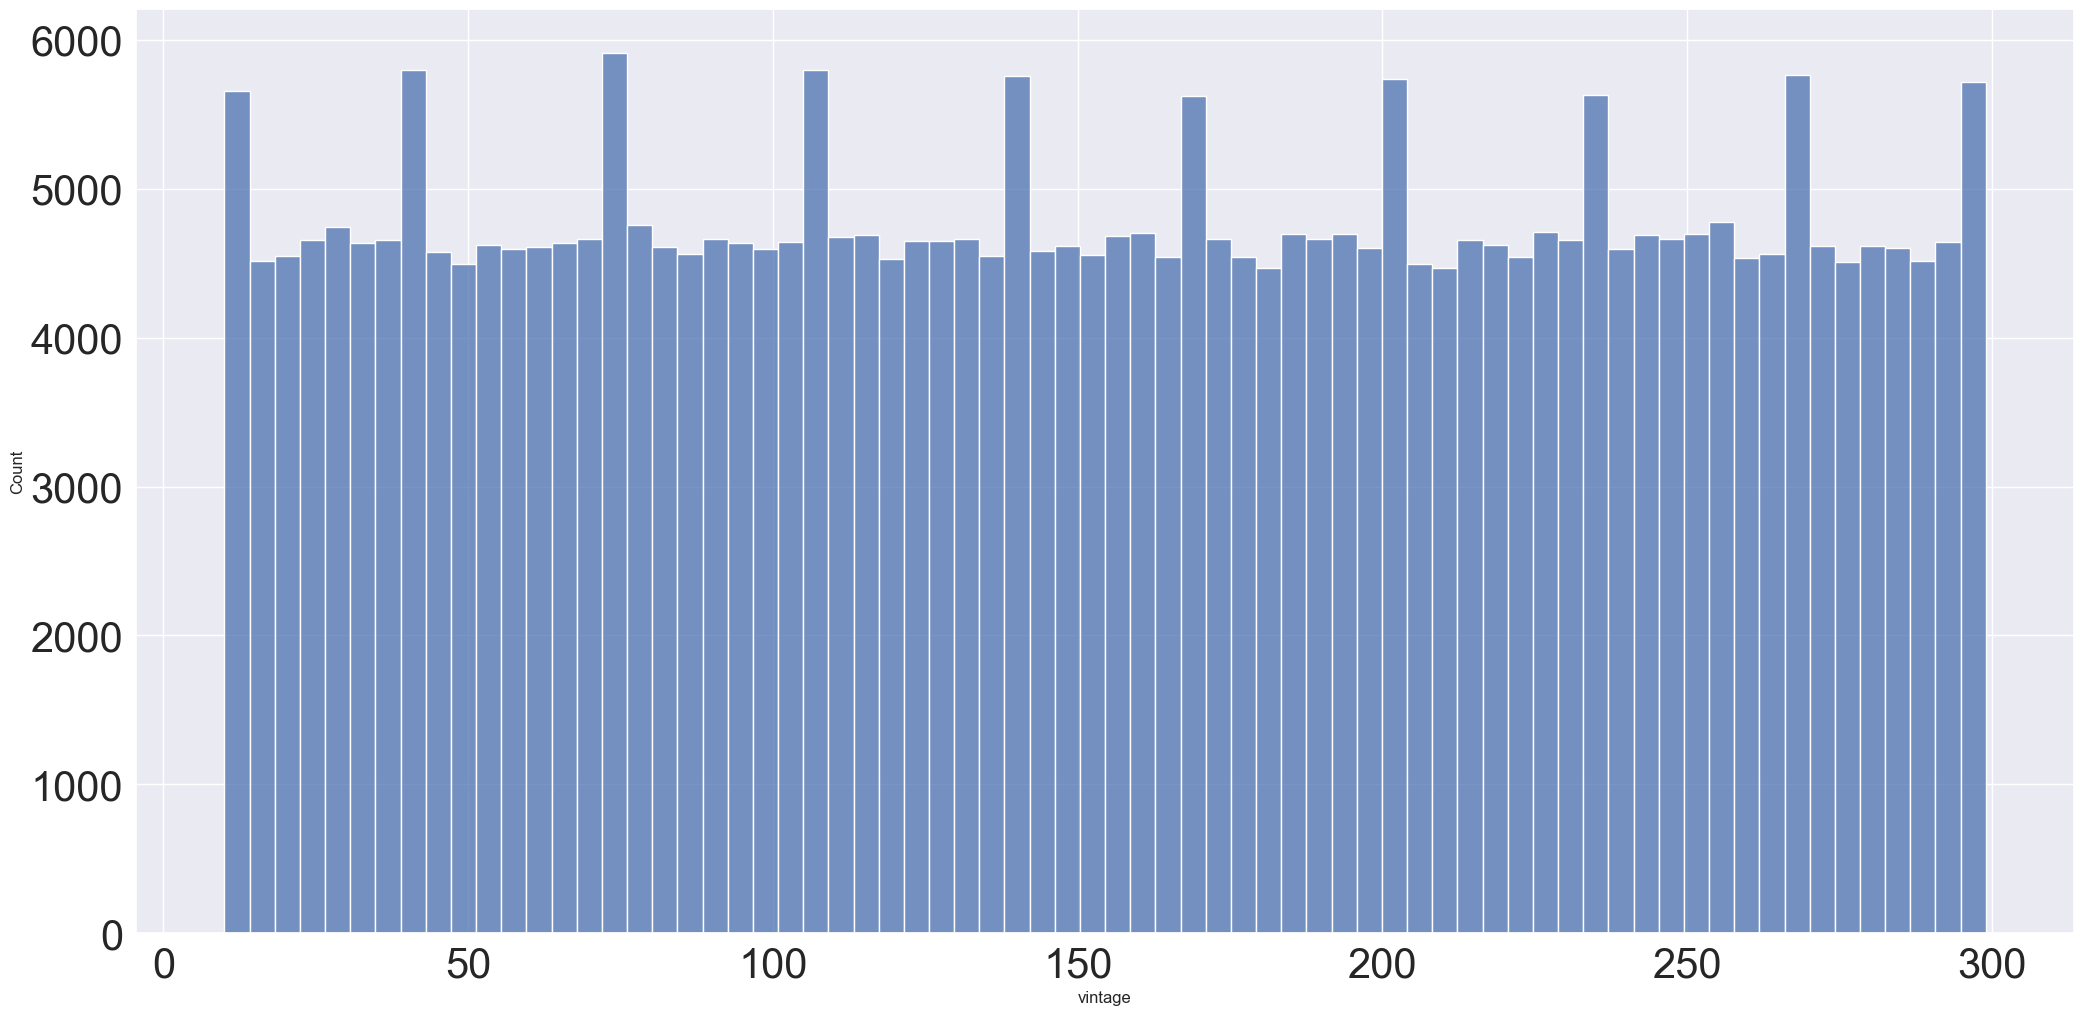

In [32]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00);
# Ajustar o tamanho dos rótulos
plt.xticks(fontsize=30);
plt.yticks(fontsize=30);

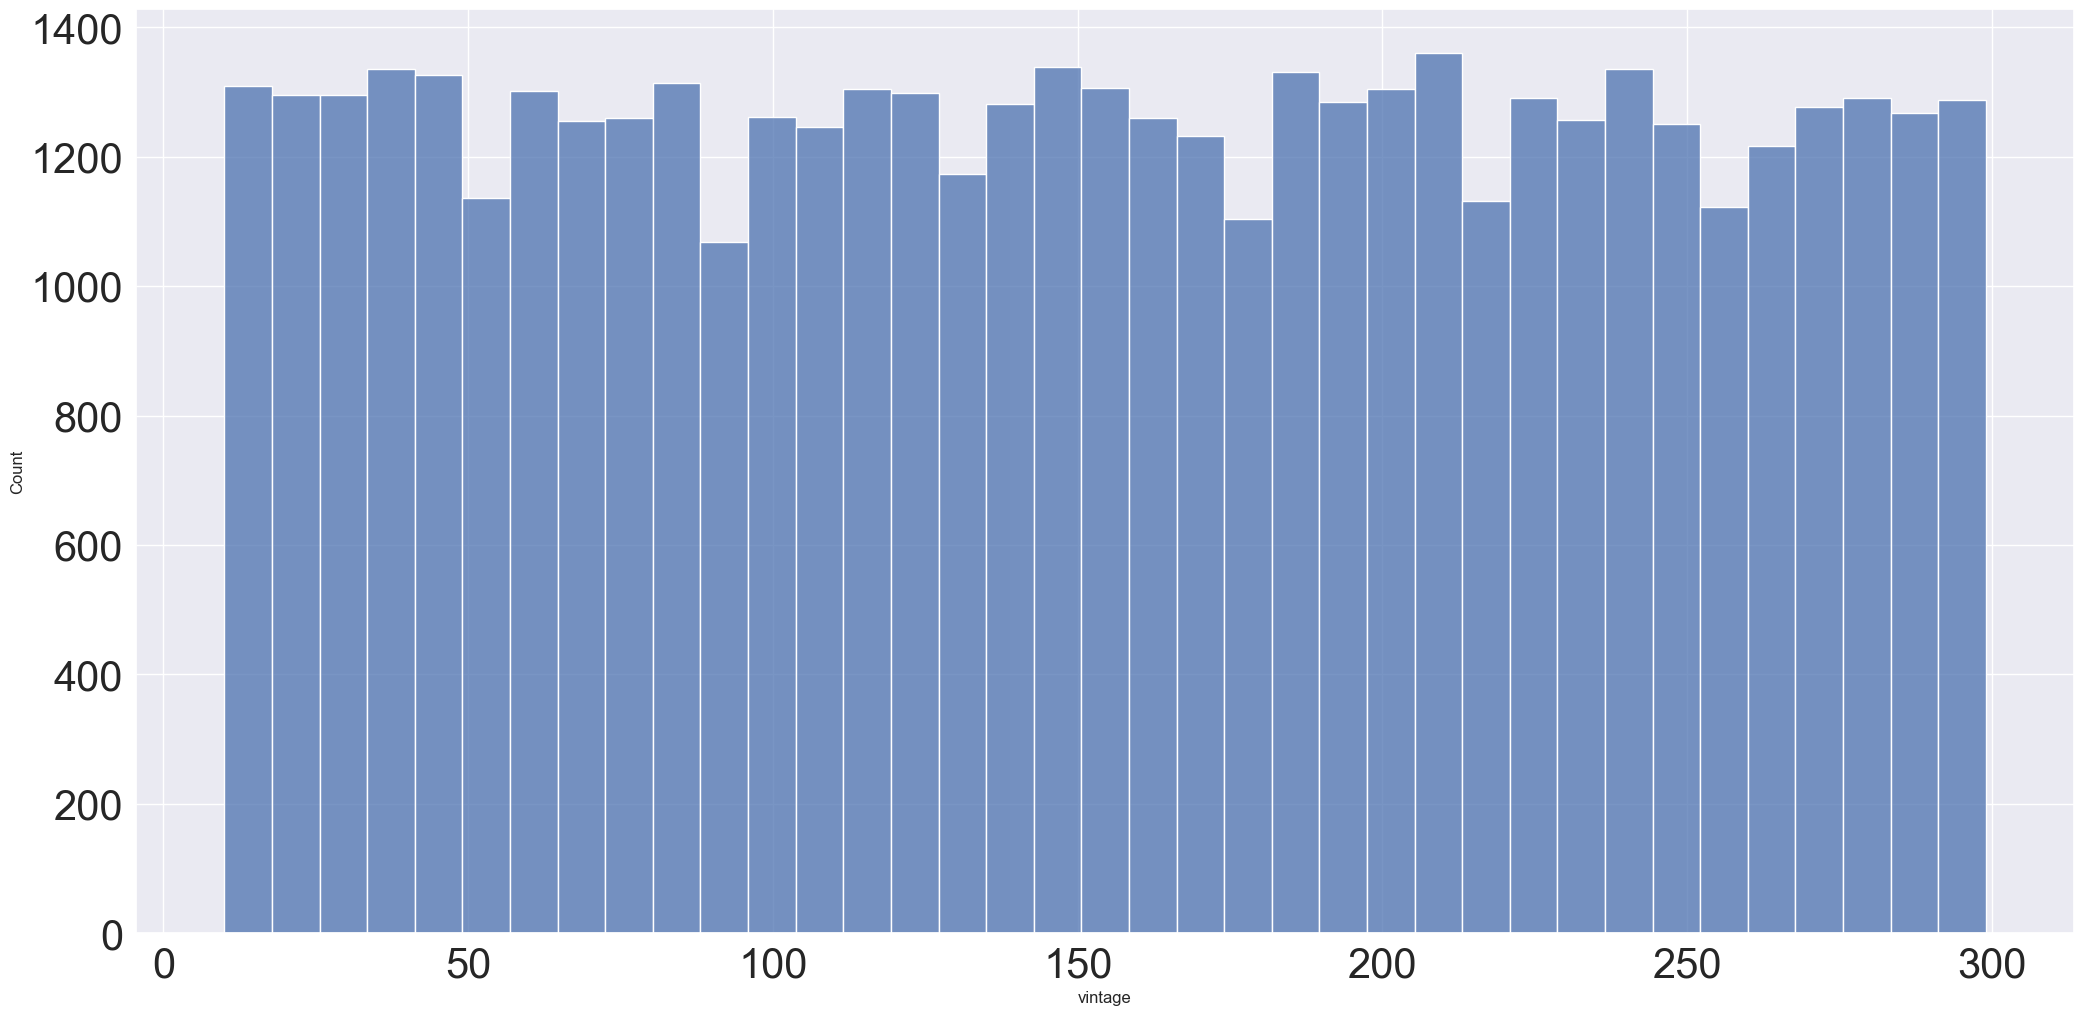

In [33]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00);
plt.xticks(fontsize=30);
plt.yticks(fontsize=30);

## 4.2 Univariate Analysis

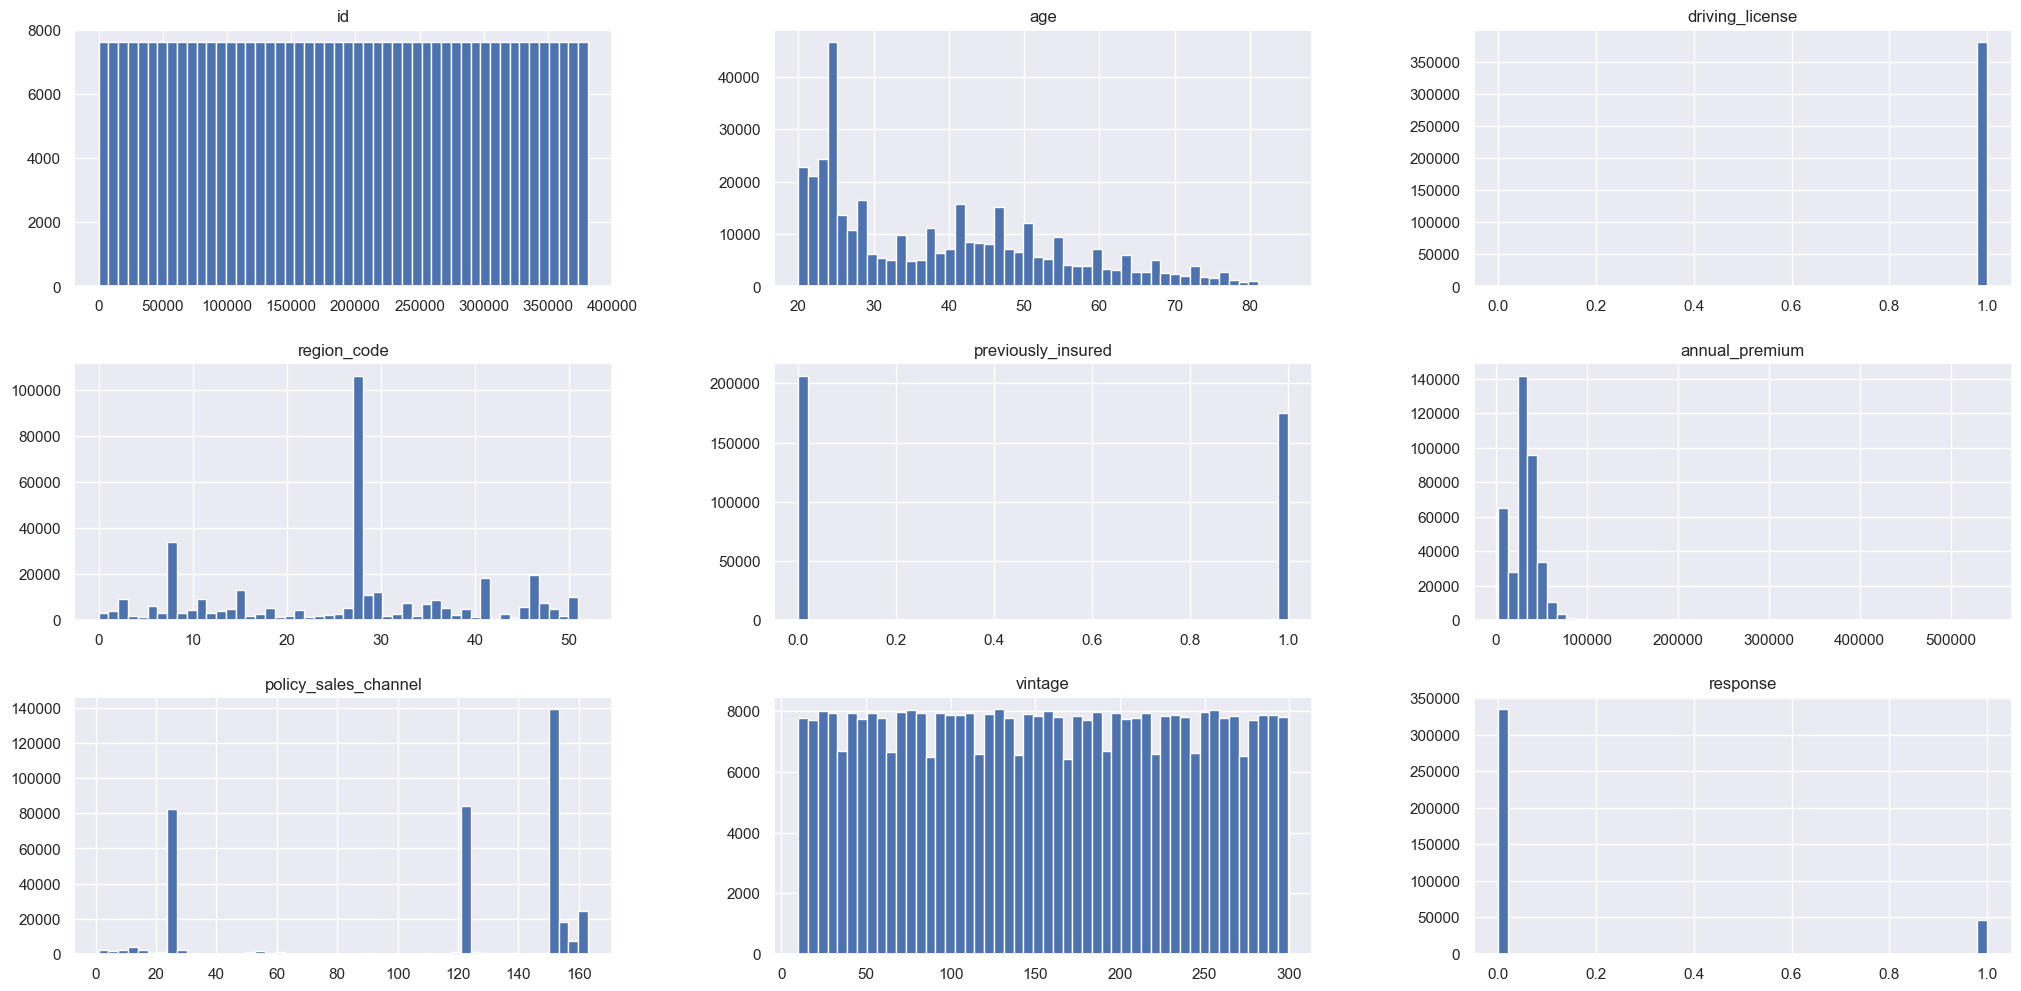

In [34]:
num_attr.hist(bins = 50);

## 4.3 Multivariate Analysis

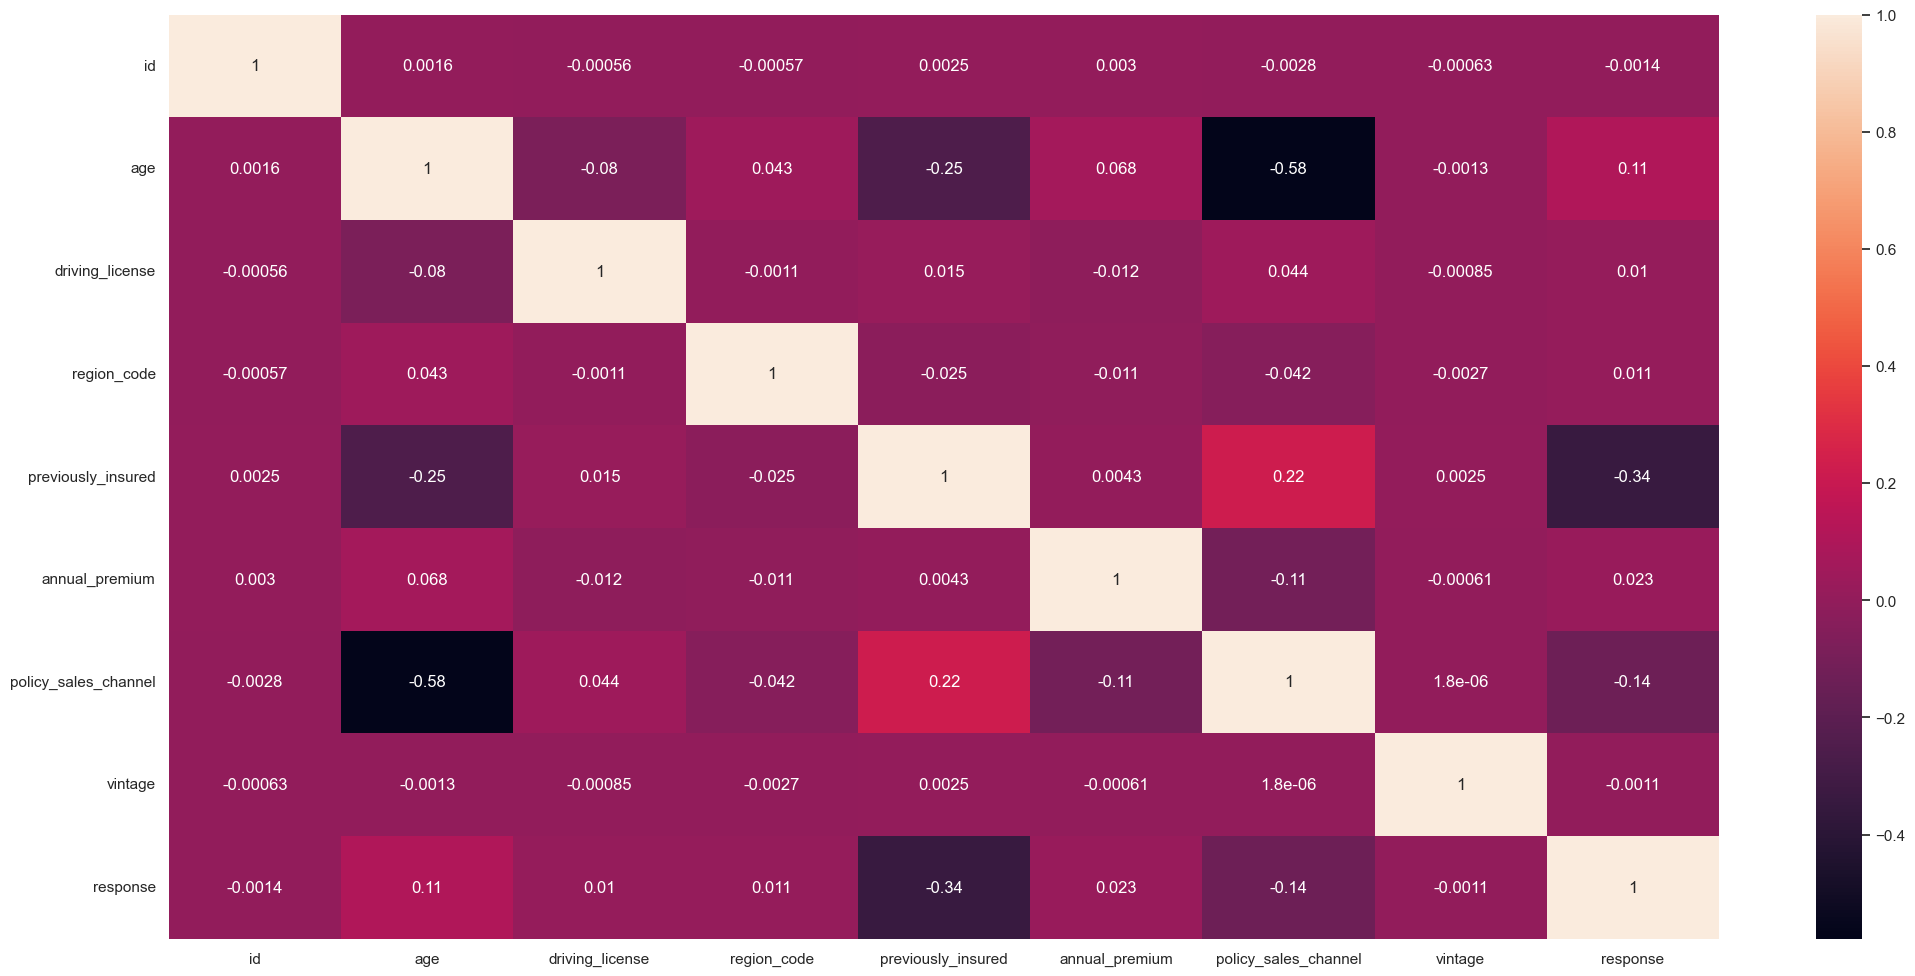

In [35]:
#Vemos a correlação das variáveis numéricas entre elas mesmas
correlation = num_attr.corr(method='pearson')
sns.heatmap( correlation, annot=True );

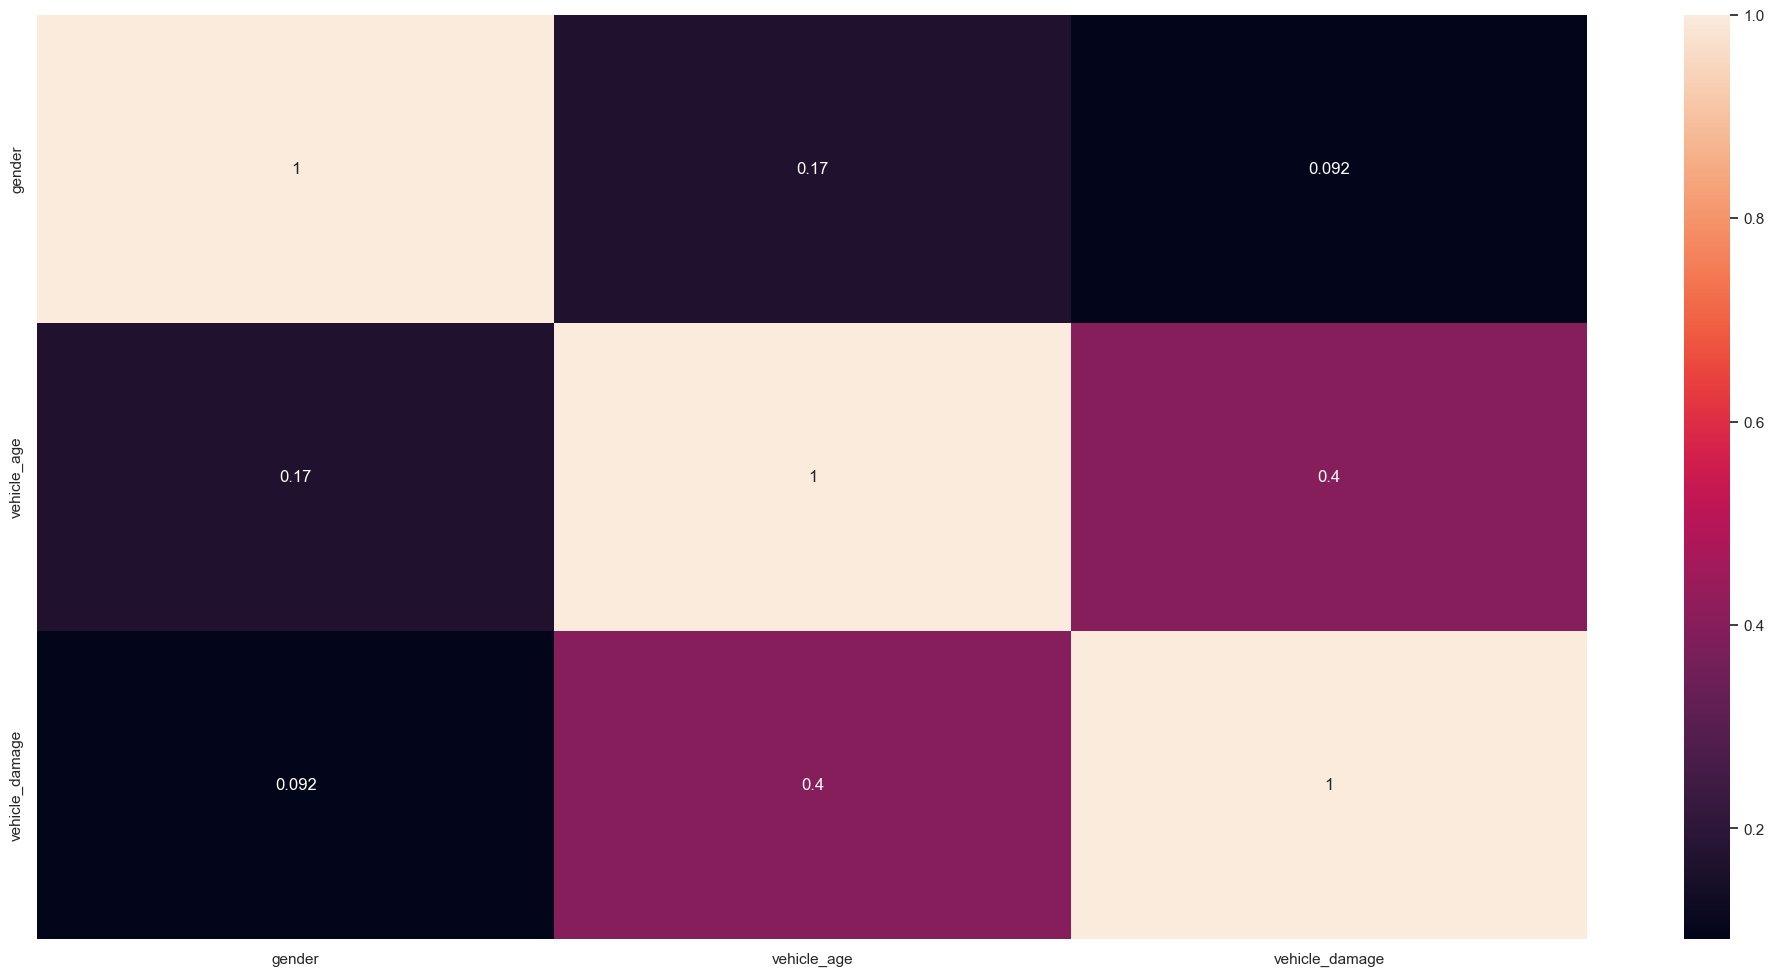

In [36]:
#Criando a relação entre as variáveis categóricas
#Cálculos do Cramer's V
a1 = cramer_v(cat_attr['gender'],cat_attr['gender'])
a2 = cramer_v(cat_attr['gender'],cat_attr['vehicle_age'])
a3 = cramer_v(cat_attr['gender'],cat_attr['vehicle_damage'])

a4 = cramer_v(cat_attr['vehicle_age'],cat_attr['gender'])
a5 = cramer_v(cat_attr['vehicle_age'],cat_attr['vehicle_age'])
a6 = cramer_v(cat_attr['vehicle_age'],cat_attr['vehicle_damage'])

a7 = cramer_v(cat_attr['vehicle_damage'],cat_attr['gender'])
a8 = cramer_v(cat_attr['vehicle_damage'],cat_attr['vehicle_age'])
a9 = cramer_v(cat_attr['vehicle_damage'],cat_attr['vehicle_damage'])

#Dataset final entre as relações das variáveis categóricas
d = pd.DataFrame({'gender':[a1,a2,a3],
              'vehicle_age':[a4,a5,a6],
              'vehicle_damage':[a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);

# 5.0 Data Preparation

In [37]:
df5 = df4.copy()

In [38]:
#Separando os dados de teste e validação
#Não se preocupar tanto se separa aqui ou no começo, o vazamento de dados é pequeno

#Simulando os dados que vem em produção
X = df5.drop('response',axis=1)

#Guardando a variável resposta
Y = df5['response'].copy()

#Separando de forma aleatória os dados que vão para o treino e os que vão para o teste
x_train, x_validation, y_train, y_validation = ms.train_test_split(X,Y,test_size=0.20)

#Juntando os dados de treino com a variável resposta do treino
df5 = pd.concat([x_train,y_train],axis=1)

## 5.1 Standardization

In [39]:
#annual_premium

ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values) #Precisa estar um array para funcionar
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/annual_premium_scaler.pkl",'wb') as SS:
#   pickle.dump(ss,SS)

## 5.2 Rescaling

In [40]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age - distribuição longe da normal
df5['age'] = mms_age.fit_transform(df5[['age']].values)
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/age_scaler.pkl",'wb') as M1:
#    pickle.dump(mms_age,M1)

#vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/vintage_scaler.pkl",'wb') as M2:
#    pickle.dump(mms_vintage,M2)

## 5.3 Encoder

In [41]:
#Para descobrir o melhor encoding tem que testar
#Label Encoding - 0 ou 1
#One Hot Encoding - Indica um estado

#gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/gender_scaler.pkl",'wb') as M3:
#    pickle.dump(target_encode_gender,M3)

#region_code -  / Frequency Encoding / Target Encoding / Weighted Target Encoding
#Tem muitas categorias, mais de 6, não usa o One Hoting Encoding, aumentaria muito a dimensionalidade do dataset
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:,'region_code'] = df5['region_code'].map(target_encode_region_code) #Todas as linhas recebem os valores
#Substitui a feature com base na variável resposta
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/region_code_scaler.pkl",'wb') as M4:
#    pickle.dump(target_encode_region_code,M4)


#vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])


#policy_sales_channel - distribuição muito uniforme - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5) #Quantos elementos eu tenho em cada grupo sobre a quantidade total
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
#Frequência que ela aparece
#with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/src/features/policy_sales_channel_scaler.pkl",'wb') as M5:
#    pickle.dump(fe_policy_sales_channel,M5)

## 5.4 Validation Preparation

In [42]:
#Utilizando os encoders usados no treino na validação

#gender
x_validation.loc[:,'gender'] = x_validation['gender'].map(target_encode_gender)

#age
x_validation['age'] = mms_age.fit_transform(x_validation[['age']].values)

#region_code
x_validation.loc[:,'region_code'] = x_validation['region_code'].map(target_encode_region_code)

#vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age',columns=['vehicle_age'])

#annual_premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

#policy_sales_channel
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#vintage
x_validation['vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)

# 6.0 Feature Selection

## 6.1 Boruta

In [43]:
#Definindo os datasets para o Boruta
#X_train_n = df5.drop(['response'],axis=1).values
#Y_train_n = y_train.values.ravel()

#Definindo o RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Definindo o Boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,Y_train_n)

In [44]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = df5.drop(['response'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Colunas não selecianadas pelo boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [45]:
#cols_selected_boruta

## 6.2 Feature Importance

In [46]:
#model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0,n_jobs=-1)

#data preparation
x_train_n = df5.drop(['id','response'],axis=1)
y_train_n = y_train.values

forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking
                         feature  importance
0                        vintage    0.273081
0                 annual_premium    0.245462
0                            age    0.165240
0                    region_code    0.103083
0                 vehicle_damage    0.068787
0           policy_sales_channel    0.060672
0             previously_insured    0.055940
0       vehicle_age_below_1_year    0.014324
0  vehicle_age_between_1_2_years    0.005908
0                         gender    0.004798
0       vehicle_age_over_2_years    0.002144
0                driving_license    0.000562


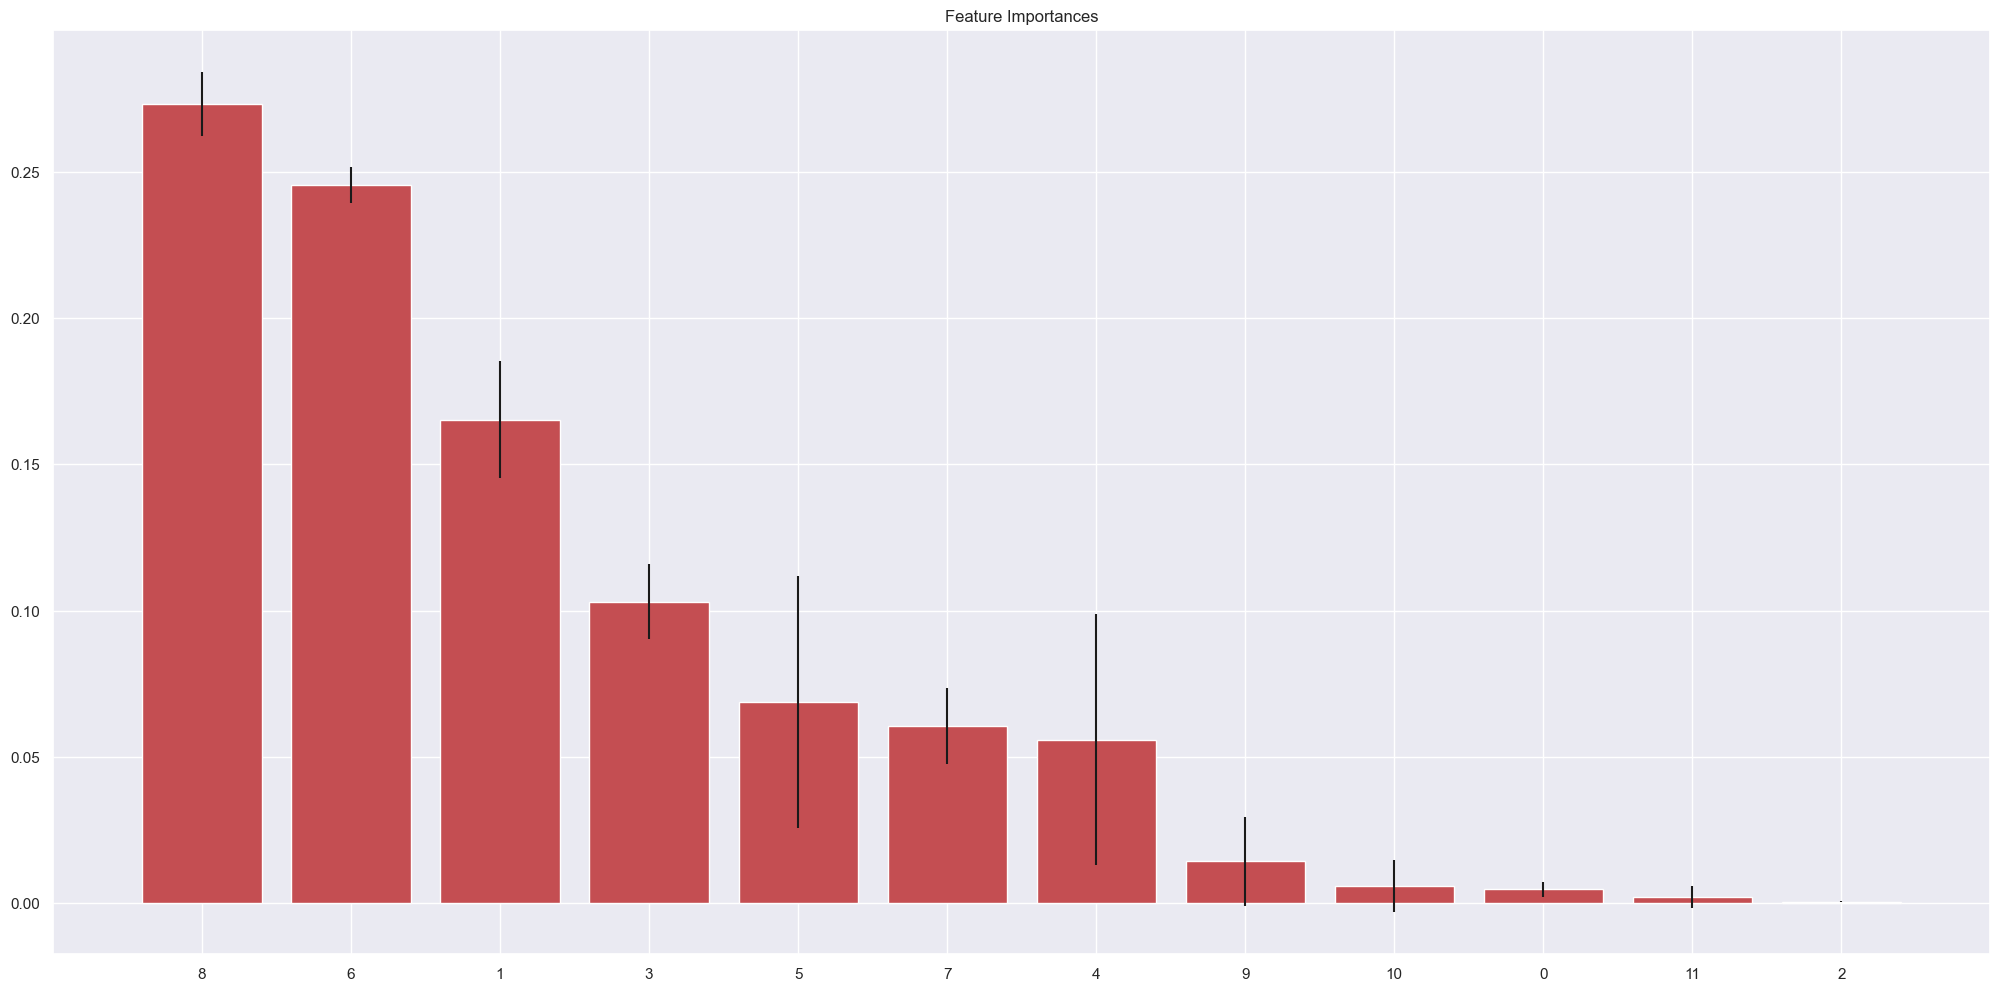

In [47]:
importances = forest.feature_importances_ #Salva as importâncias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1] #Importâncias das árvores ordenadas pelo maior valor

#print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i,j in zip(x_train_n,forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

### Como o boruta deu poucas features, através da importância das árvores vou selecionar as features que tem importância acima de 5%. Além disso, o Boruta deve ter selecionado apenas o vehicle_damage devido ao seu maior std.

# 7.0 Machine Learning

In [48]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

#Usar apenas as features selecionadas
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]

## 7.1 - KNN

In [49]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

#model training
knn_model.fit(x_train,y_train)

#model predcition -Pode de generalização
yhat_knn = knn_model.predict_proba(x_val) #Predição de probabilidade

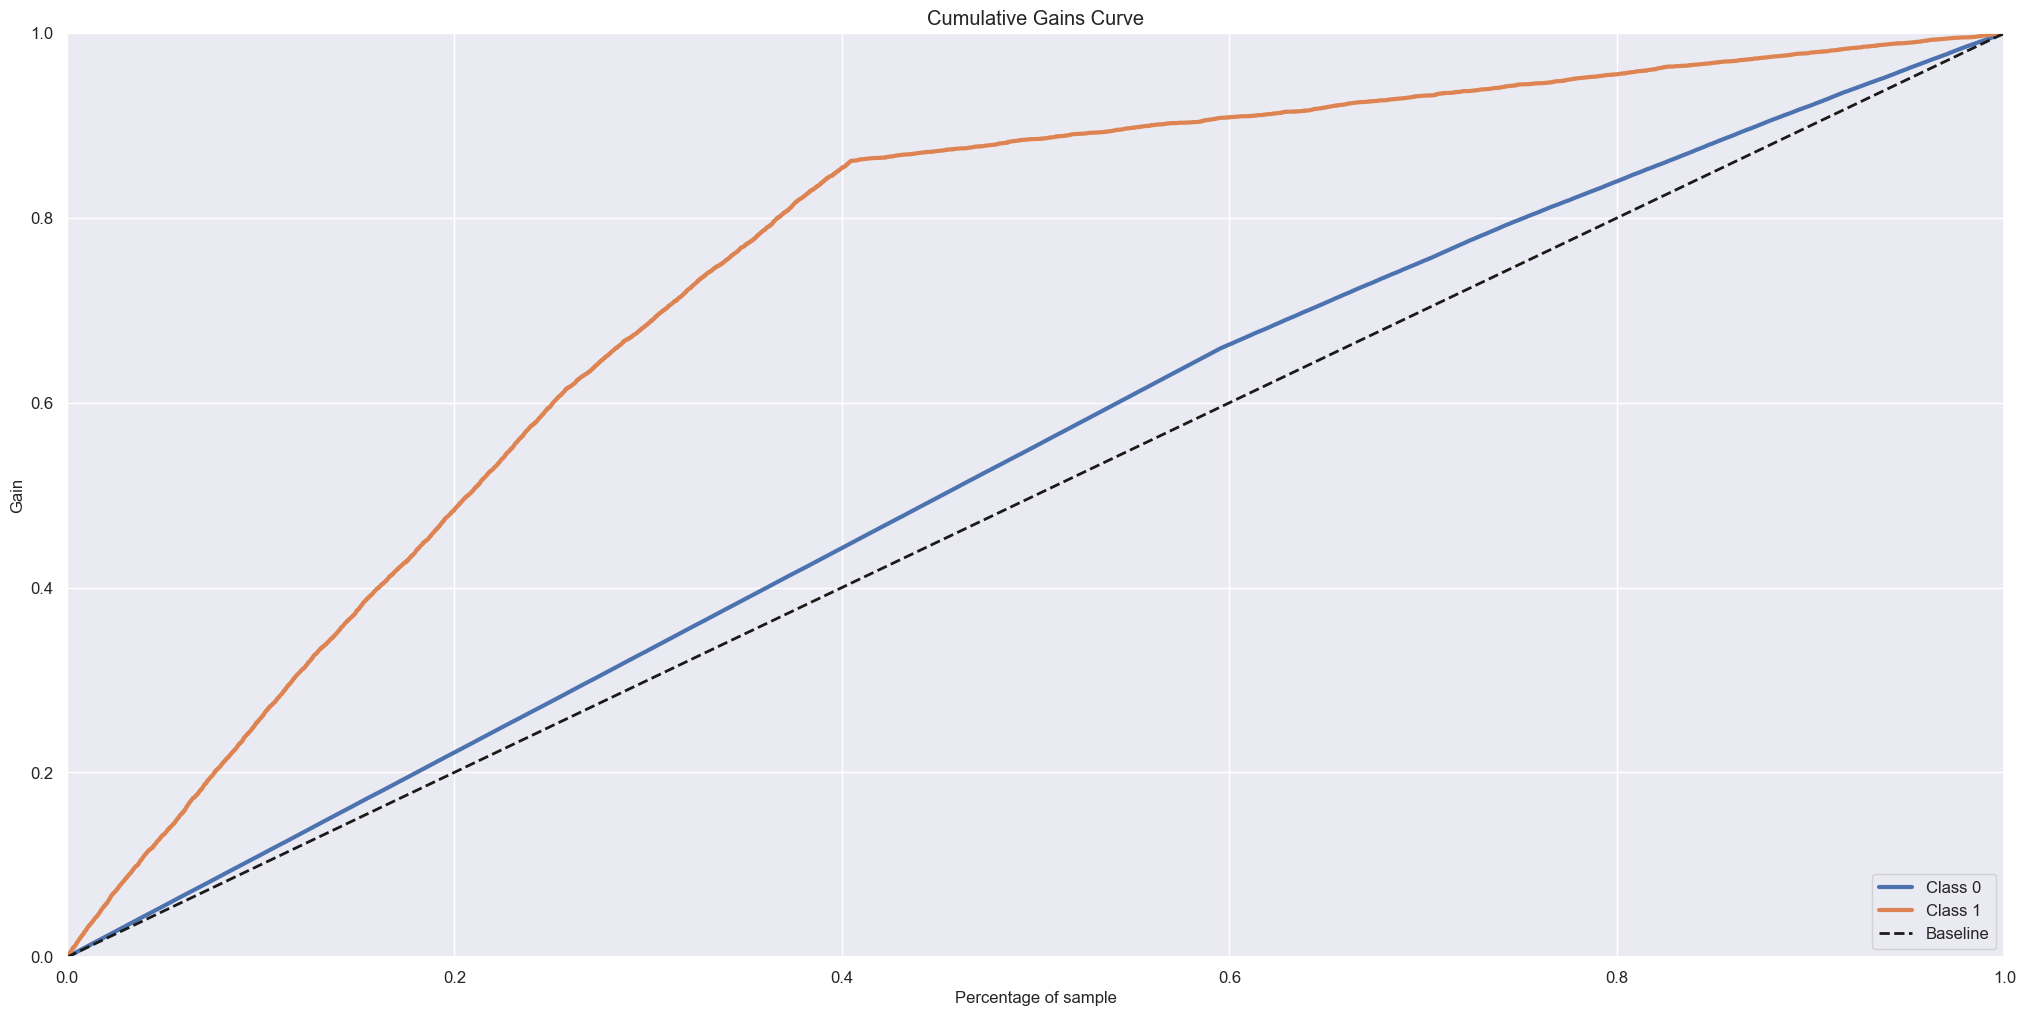

In [72]:
#Como nosso modelo vai ordenar e não classificar, usamos métricas de ordenação
#O quão bom a minha lista está ordenada

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn); 

#A ideia da linha laranja é atingir o máximo de ganho, com a menor quantidade de porcentagem da amostra

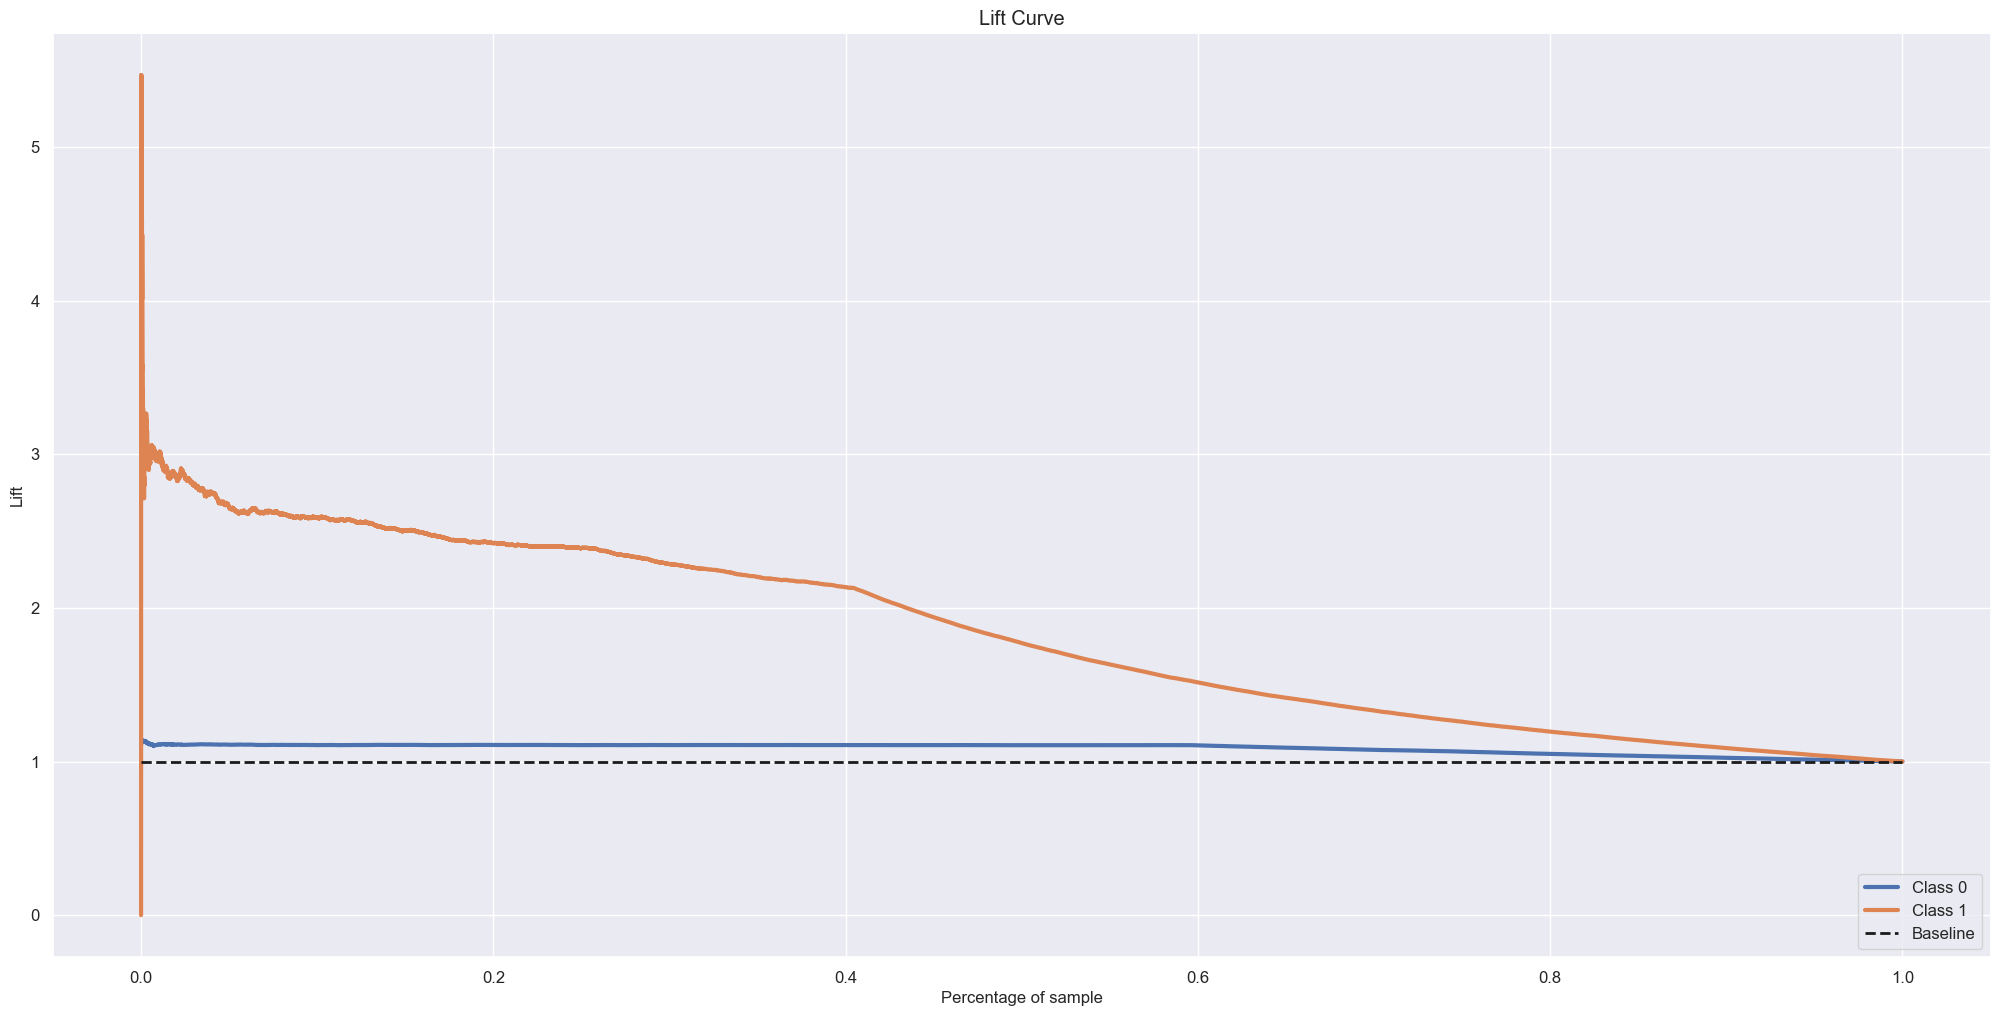

In [73]:
skplt.metrics.plot_lift_curve(y_validation,yhat_knn);

## 7.2 - Logistic Regression

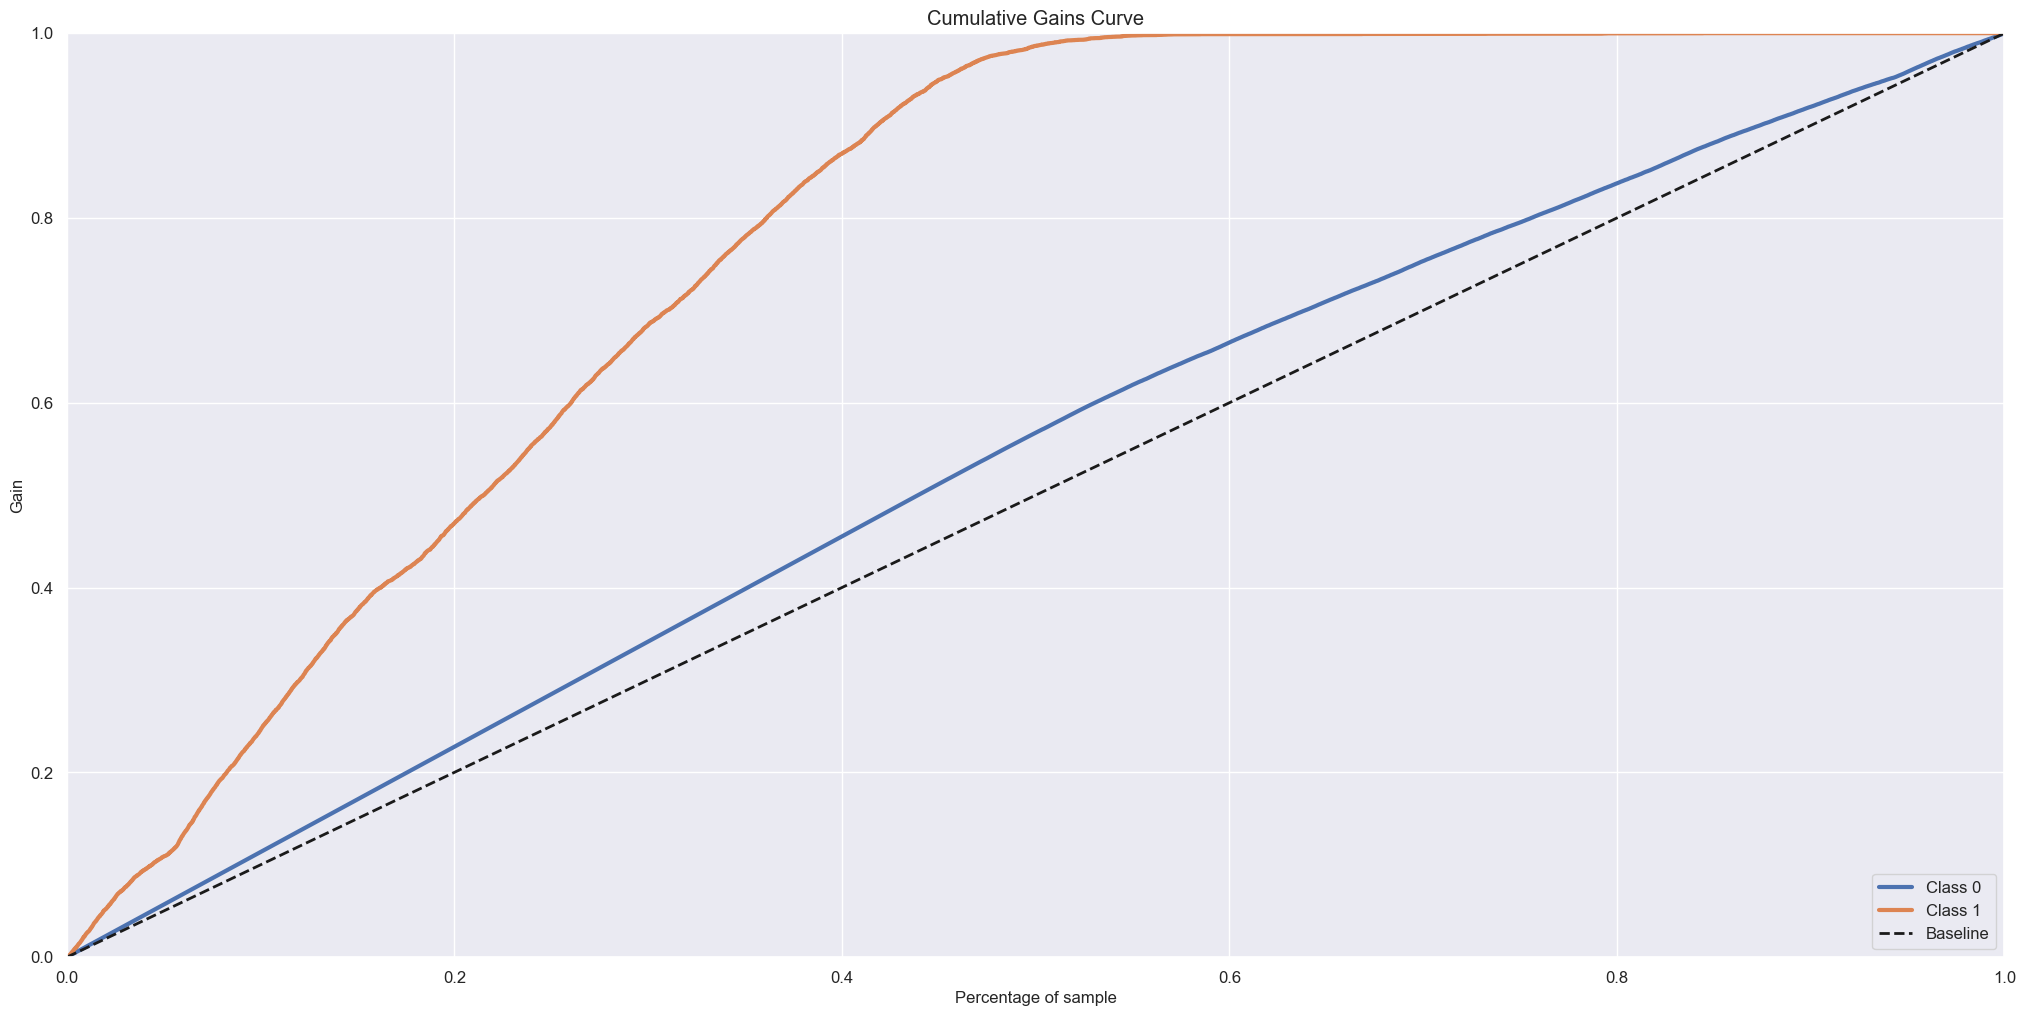

In [51]:
#model definition
lr_model = lm.LogisticRegression(random_state=42)

#model training
lr_model.fit(x_train,y_train)

#model prediction
yhat_lr = lr_model.predict_proba(x_val)

#Acumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr);

#Não preciso de 100% da minha base para ter todas as pessoas interessadas

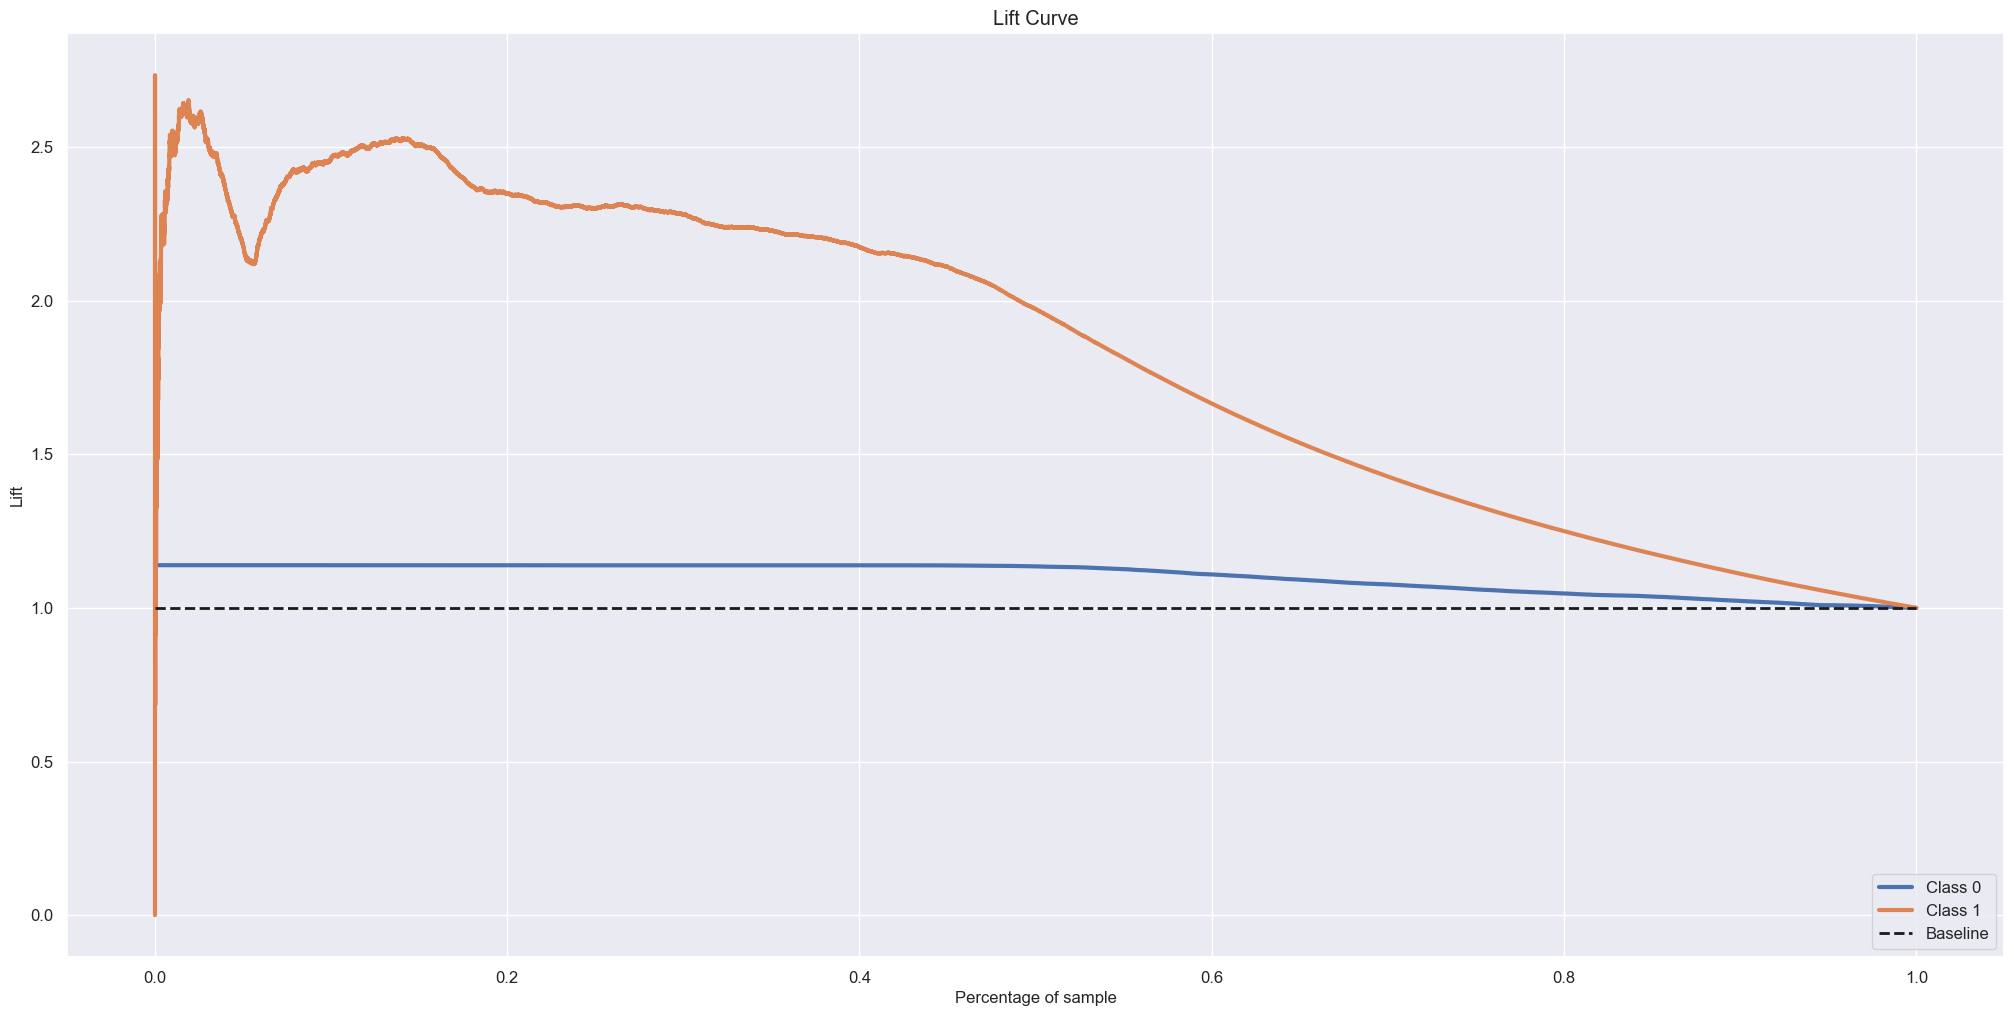

In [74]:
skplt.metrics.plot_lift_curve(y_validation,yhat_lr);

## 7.3 - Extra Trees

In [52]:
#model definition
extra_model = en.ExtraTreesClassifier(n_estimators=250, random_state=0,n_jobs=-1)

#model training
extra_model.fit(x_train,y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

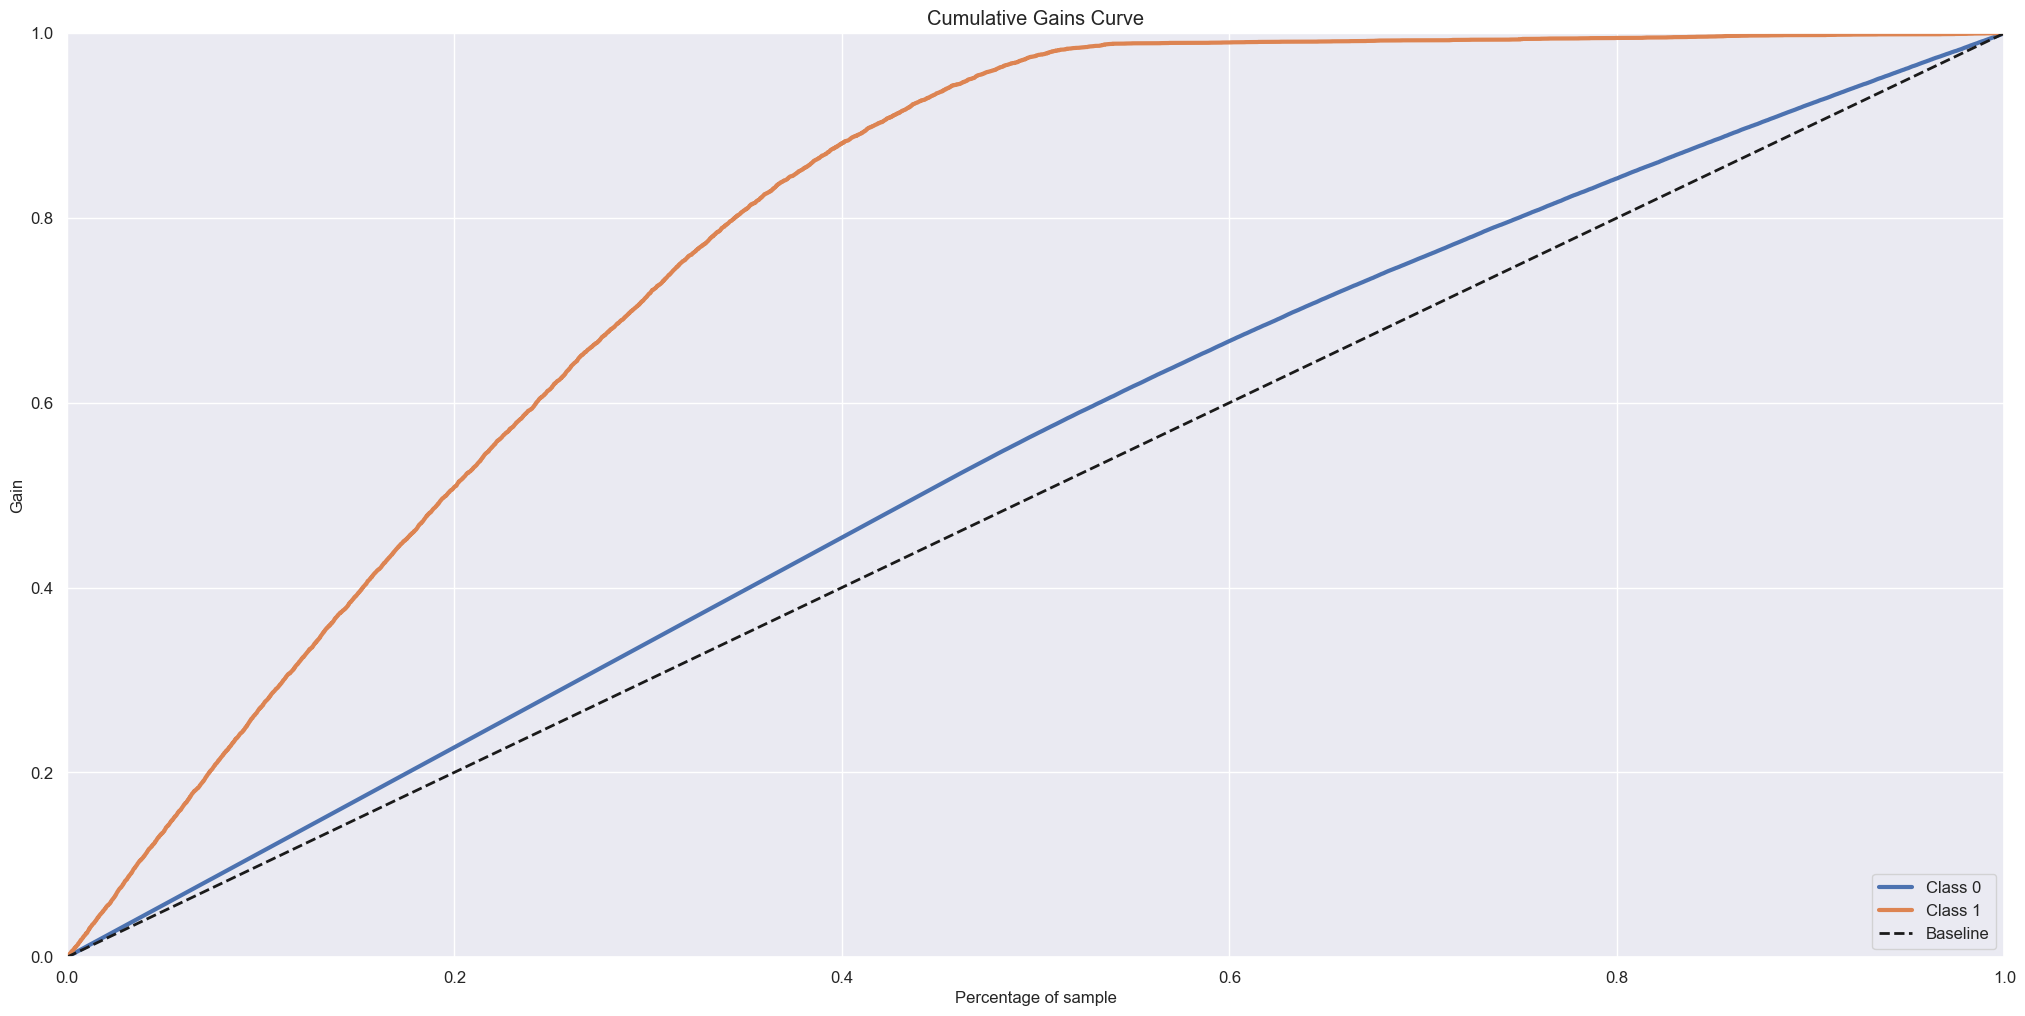

In [53]:
#model predcition -Pode de generalização
yhat_et = extra_model.predict_proba(x_val) #Predição de probabilidade

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et);

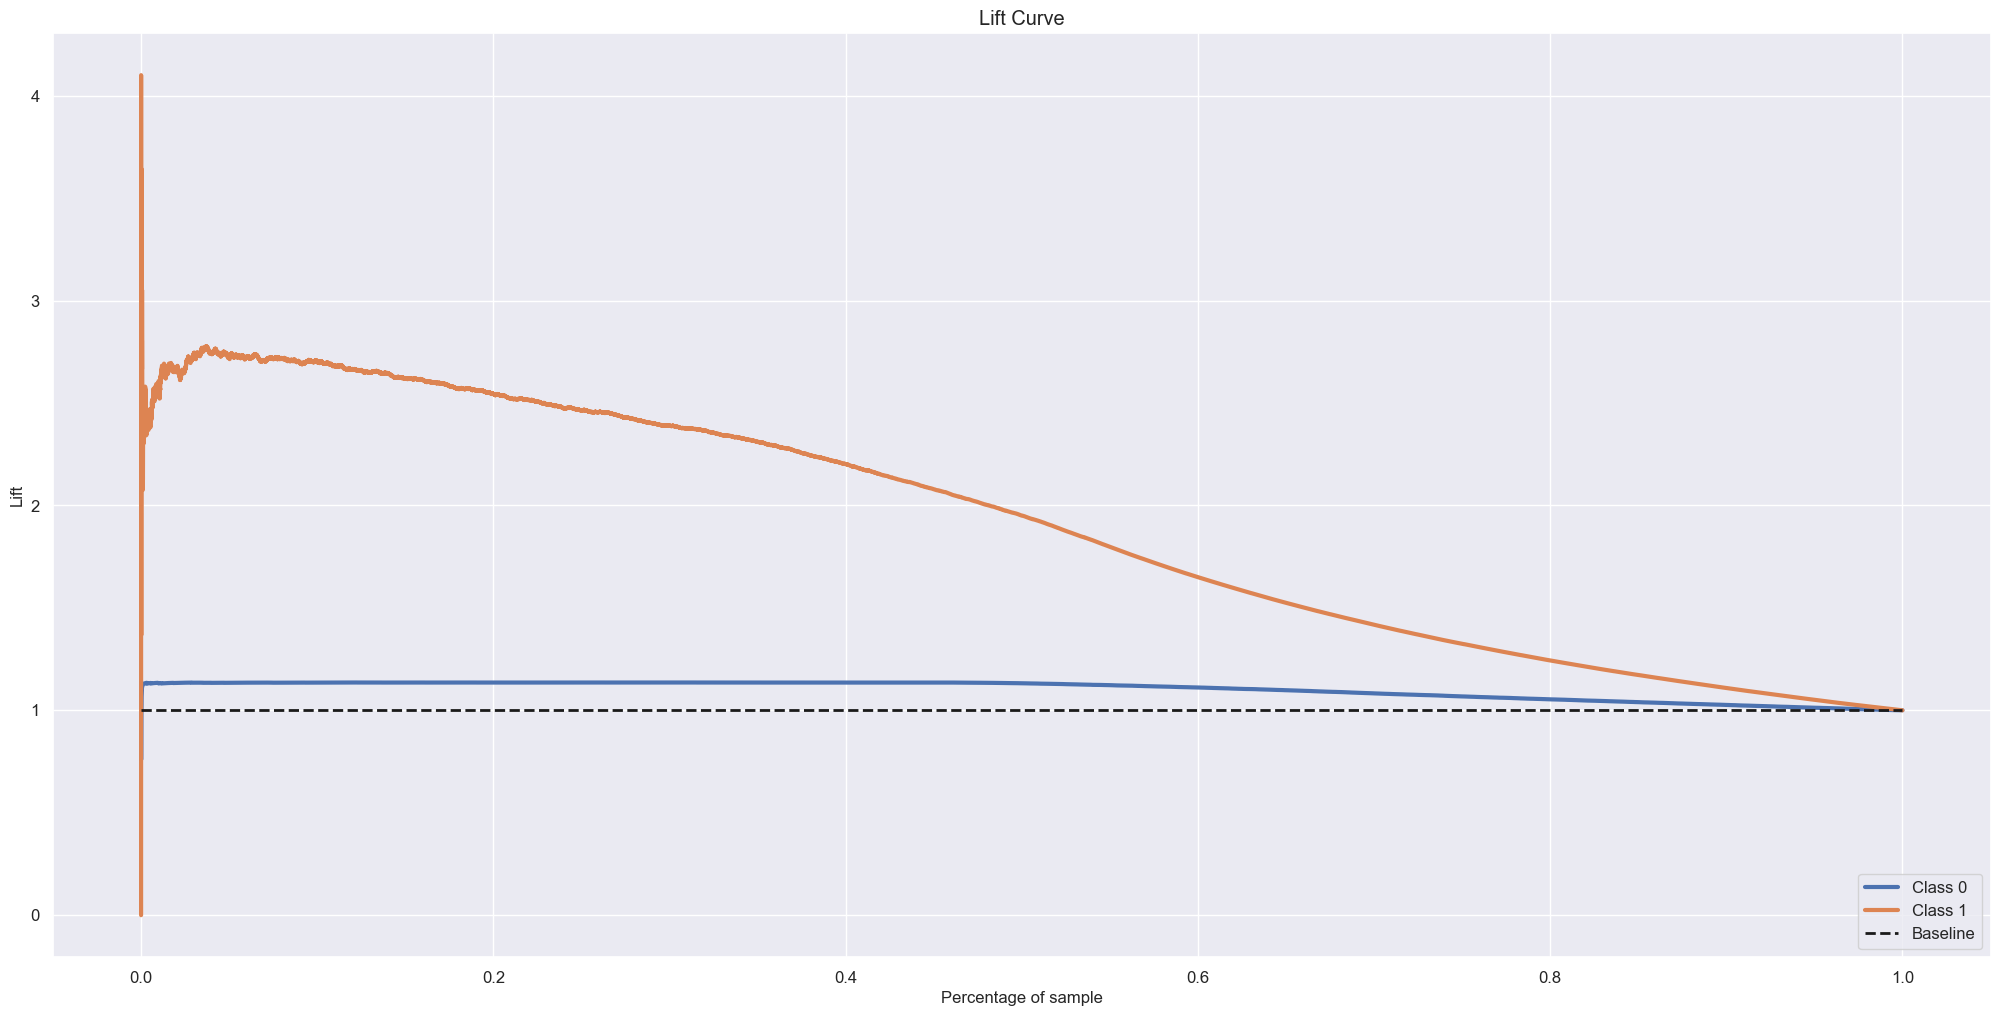

In [75]:
skplt.metrics.plot_lift_curve(y_validation,yhat_et);

## 7.4 - Random Forest

In [54]:
## 7.3 - Extra Treesfrom sklearn.ensemble import RandomForestClassifier

# Definição do modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1,random_state=42)  # Você pode ajustar o número de estimadores (árvores) conforme necessário

# Treinamento do modelo
rf_model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

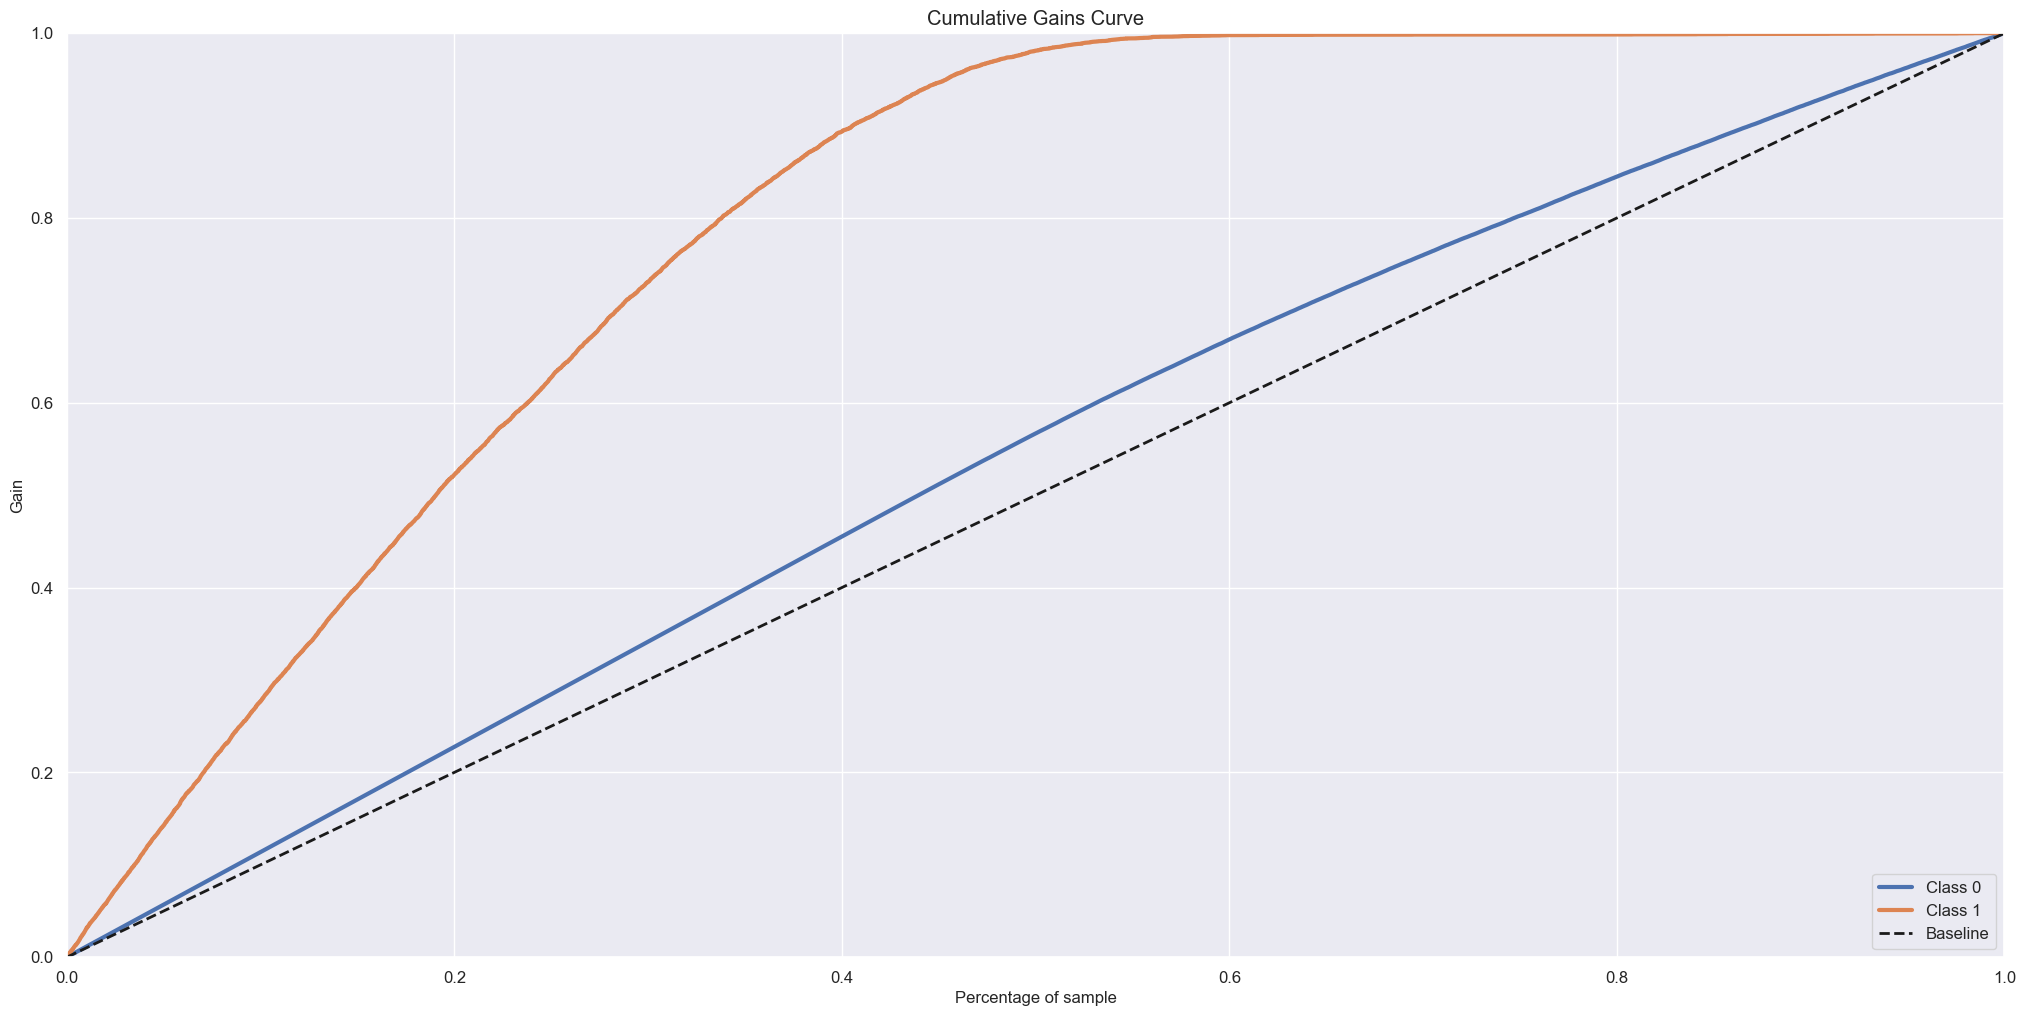

In [55]:
# Previsão com probabilidade usando o Random Forest
yhat_rf = rf_model.predict_proba(x_val)

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_rf);

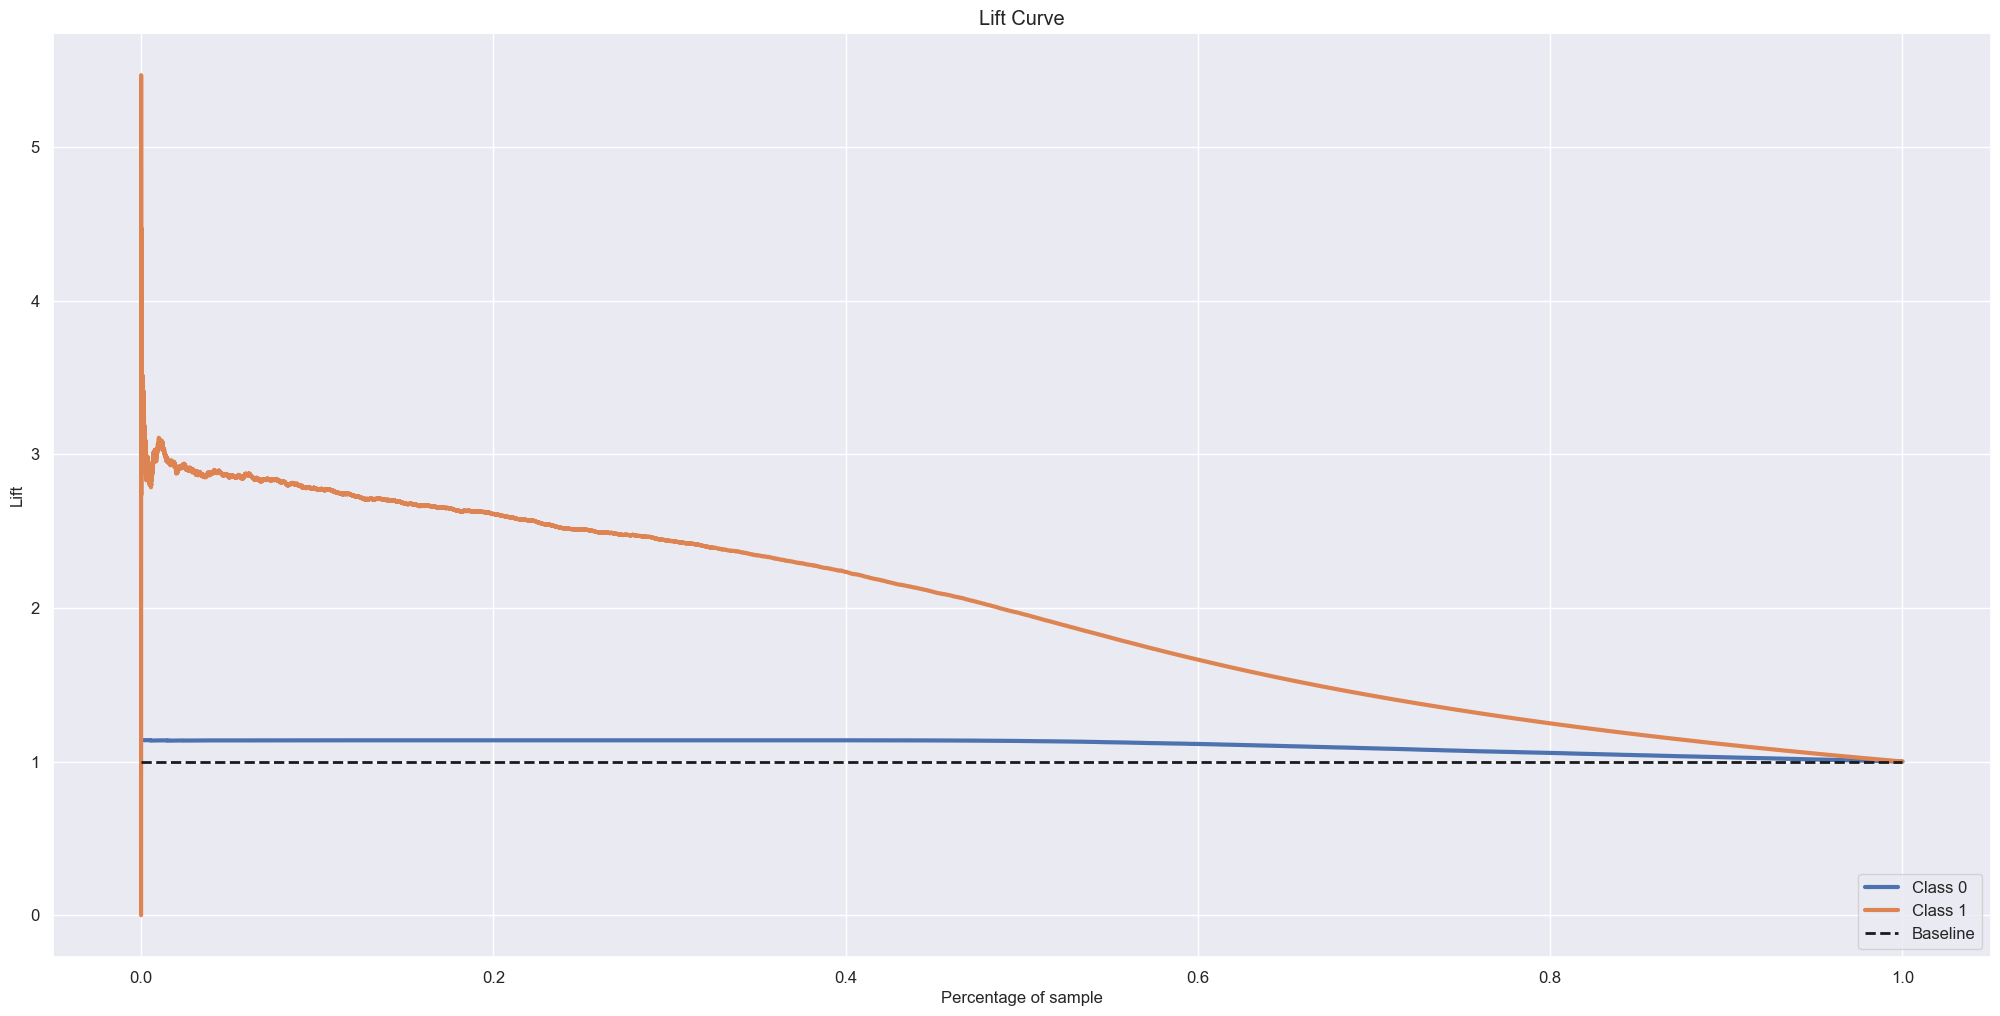

In [76]:
skplt.metrics.plot_lift_curve(y_validation,yhat_rf);

## 7.5 - XGBoost

In [56]:
## 7.3 - Extra Trees# Definição do modelo XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=1000, n_jobs=-1,random_state=42)  # Você pode ajustar o número de estimadores conforme necessário

# Treinamento do modelo
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

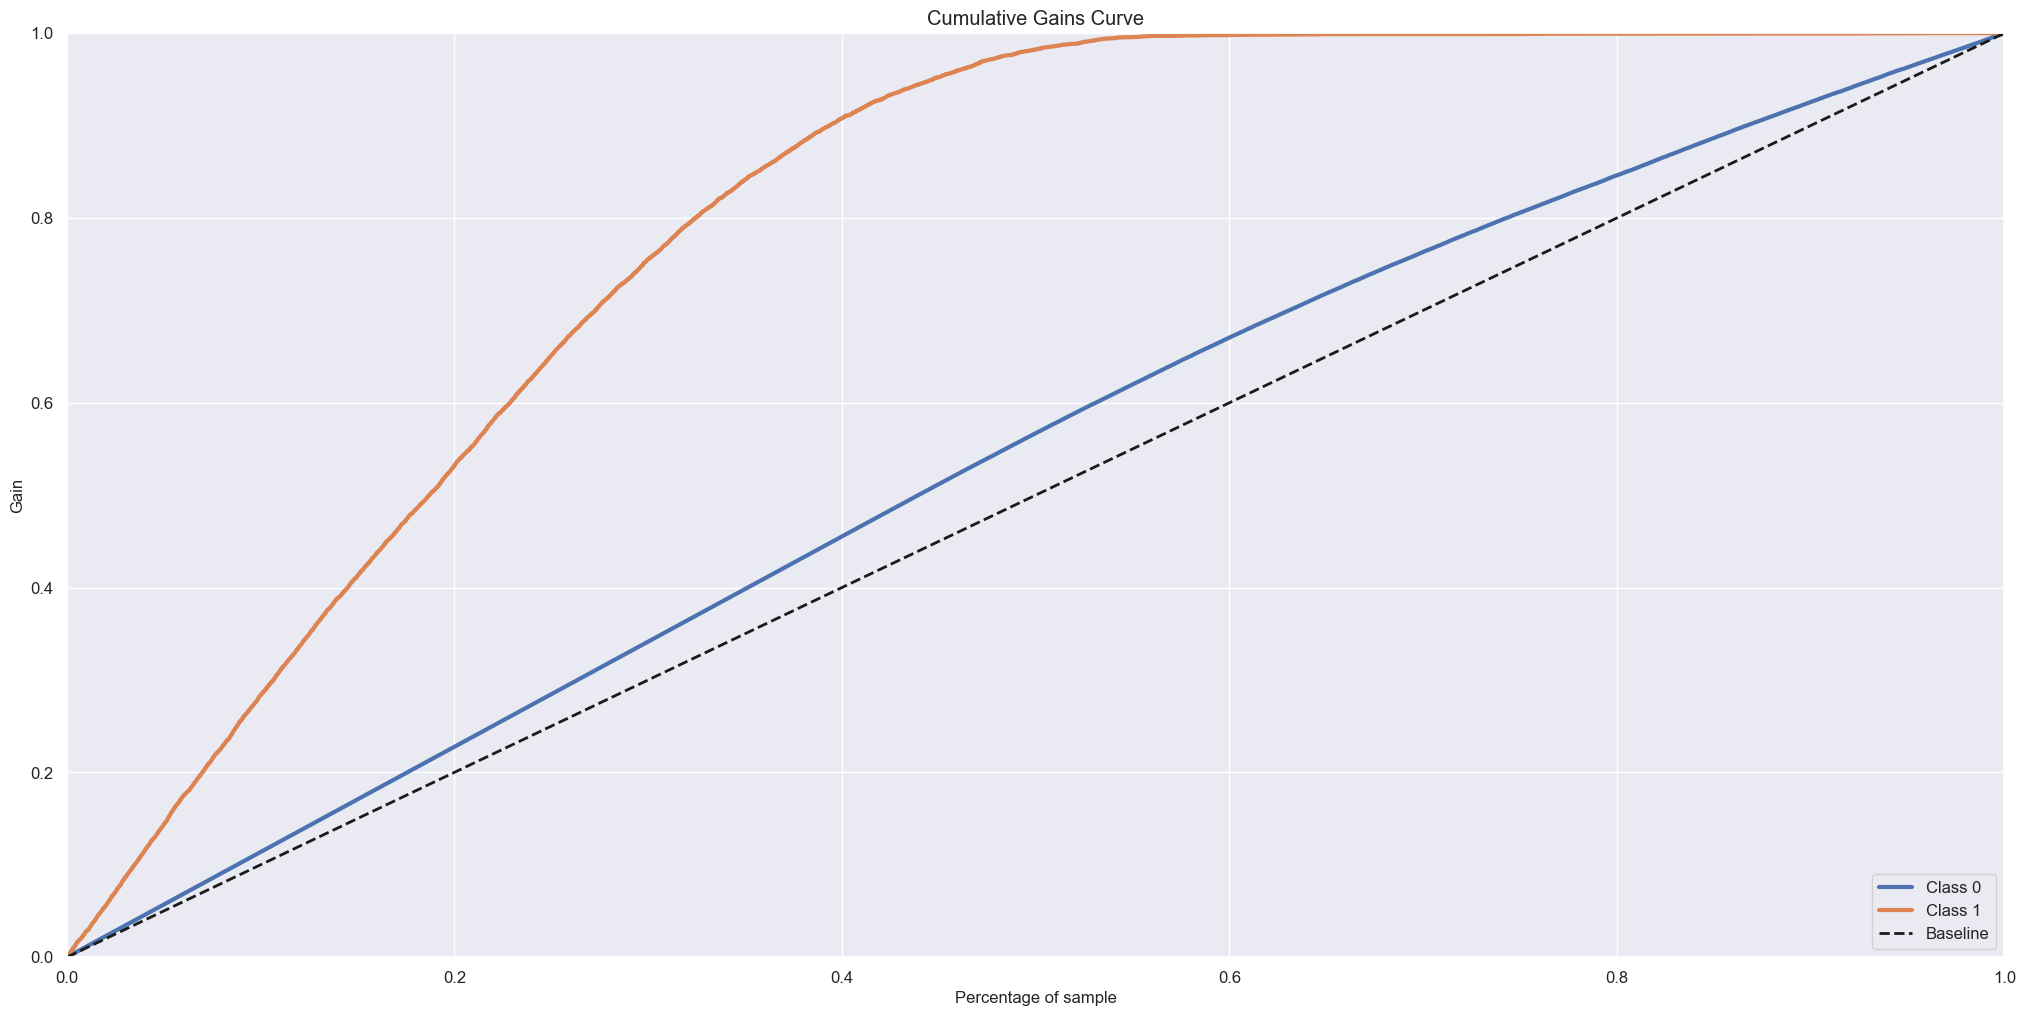

In [57]:
# Previsão com probabilidade usando o XGBoost
yhat_xgb = xgb_model.predict_proba(x_val)

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_xgb);

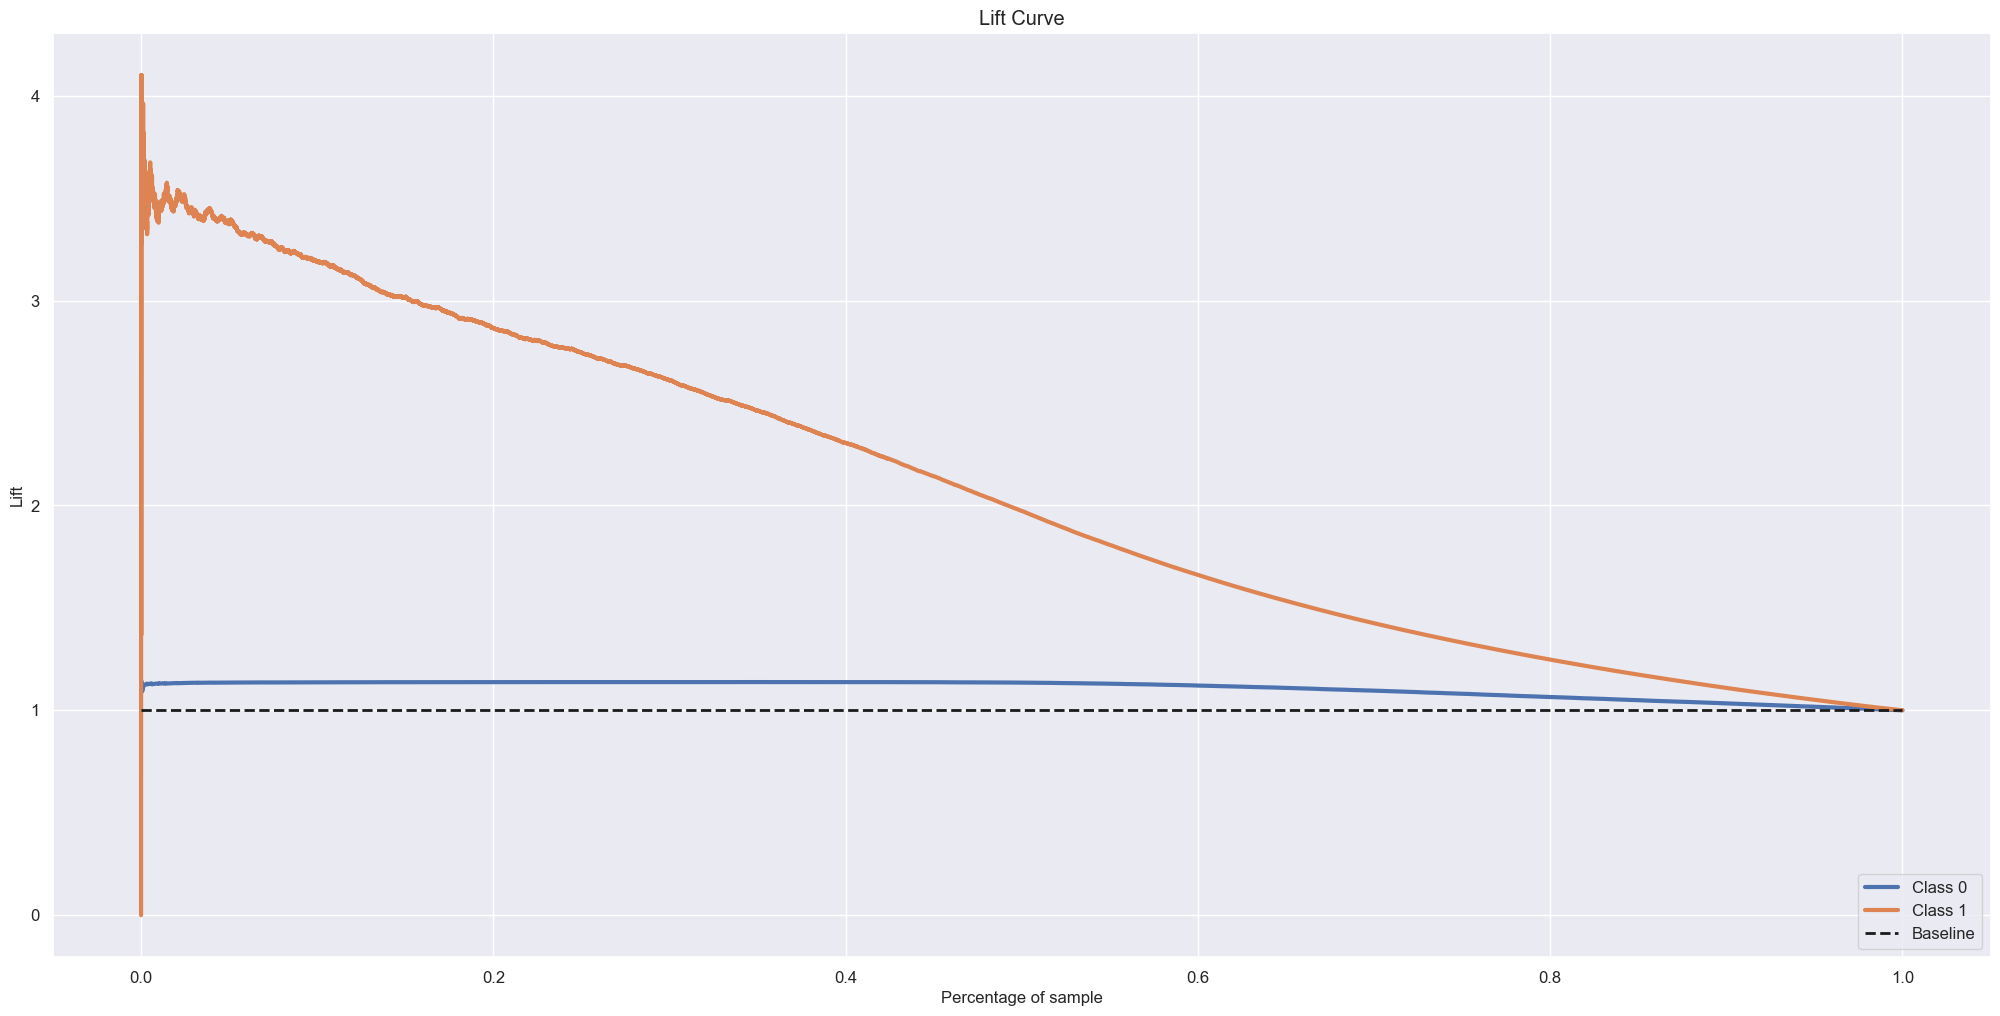

In [77]:
skplt.metrics.plot_lift_curve(y_validation,yhat_xgb);

## 7.6 - Naive Bayes

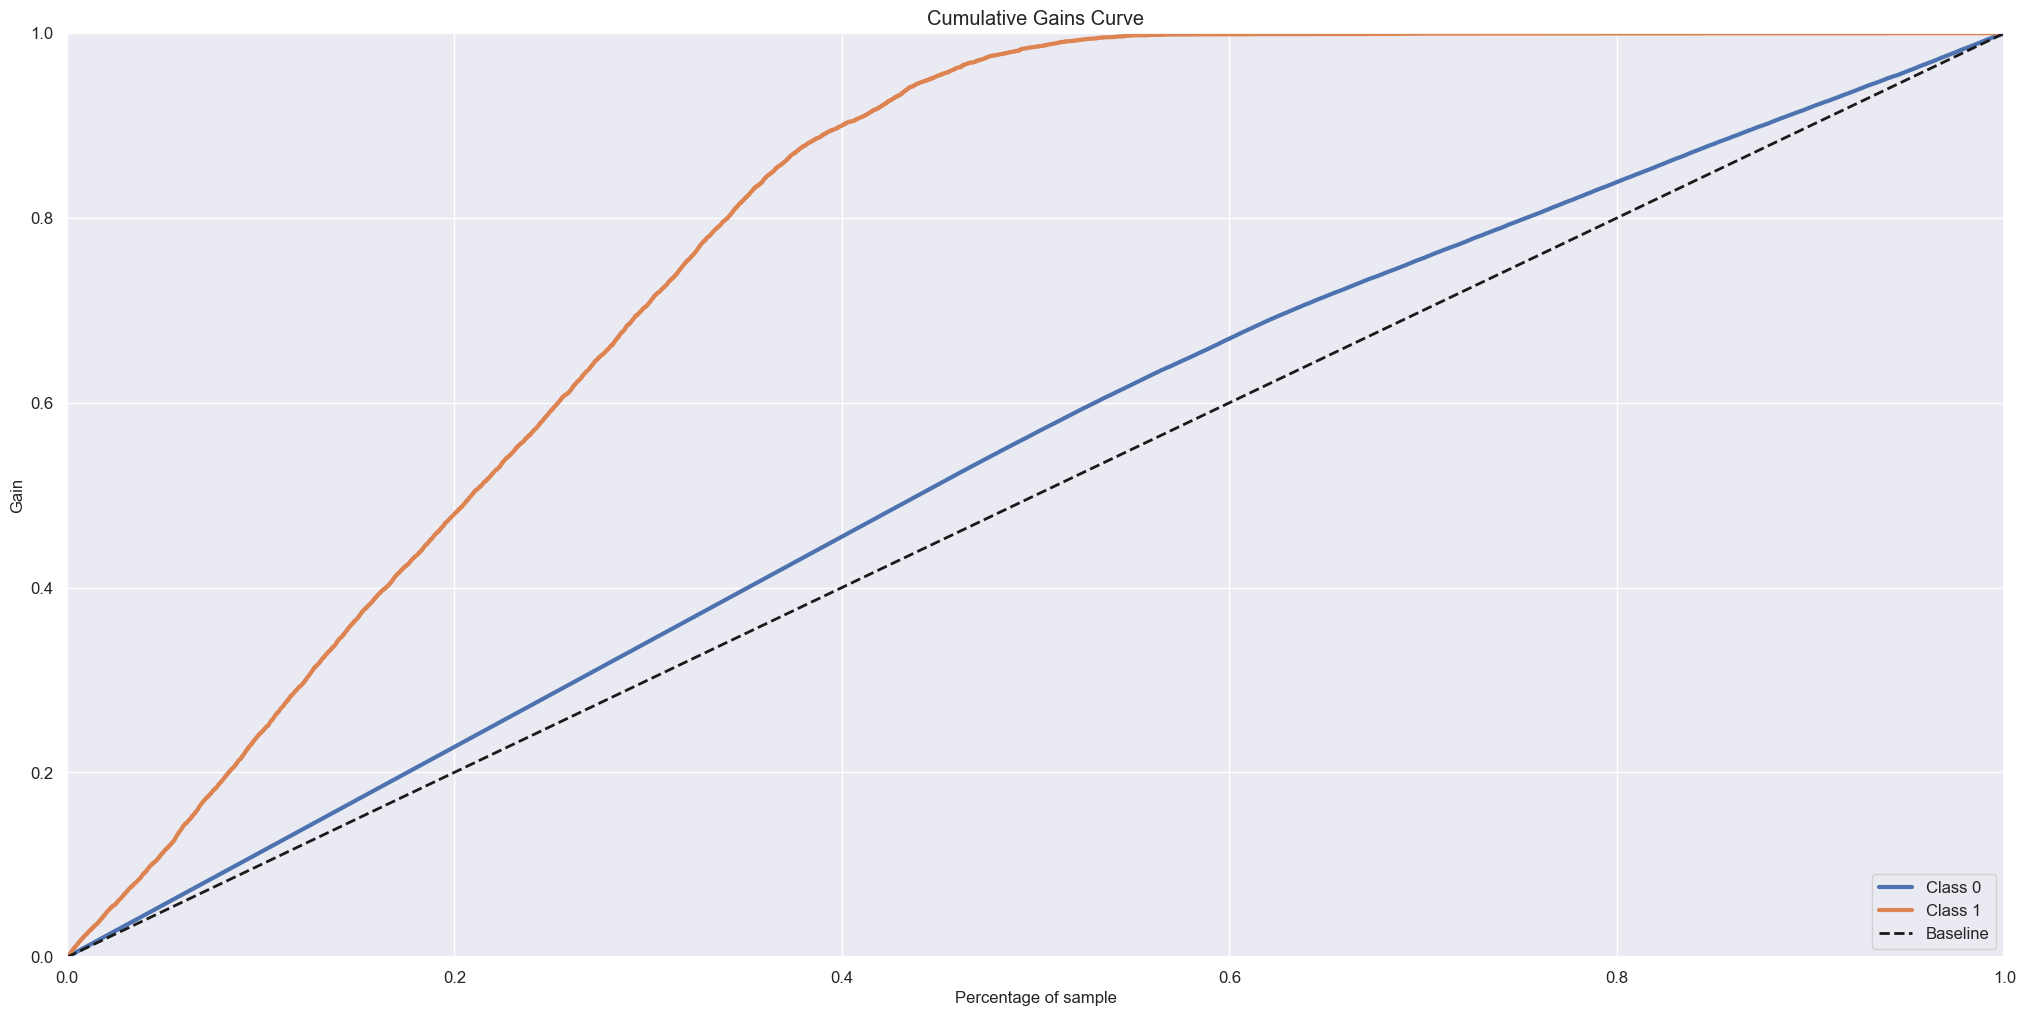

In [58]:
## 7.3 - Extra Treesfrom sklearn.naive_bayes import GaussianNB

# Definindo o modelo Naive Bayes
nb_model = GaussianNB()

# Treinando o modelo
nb_model.fit(x_train, y_train)

# Fazendo previsões
yhat_nb = nb_model.predict_proba(x_val)  # Previsão de probabilidade

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_nb);

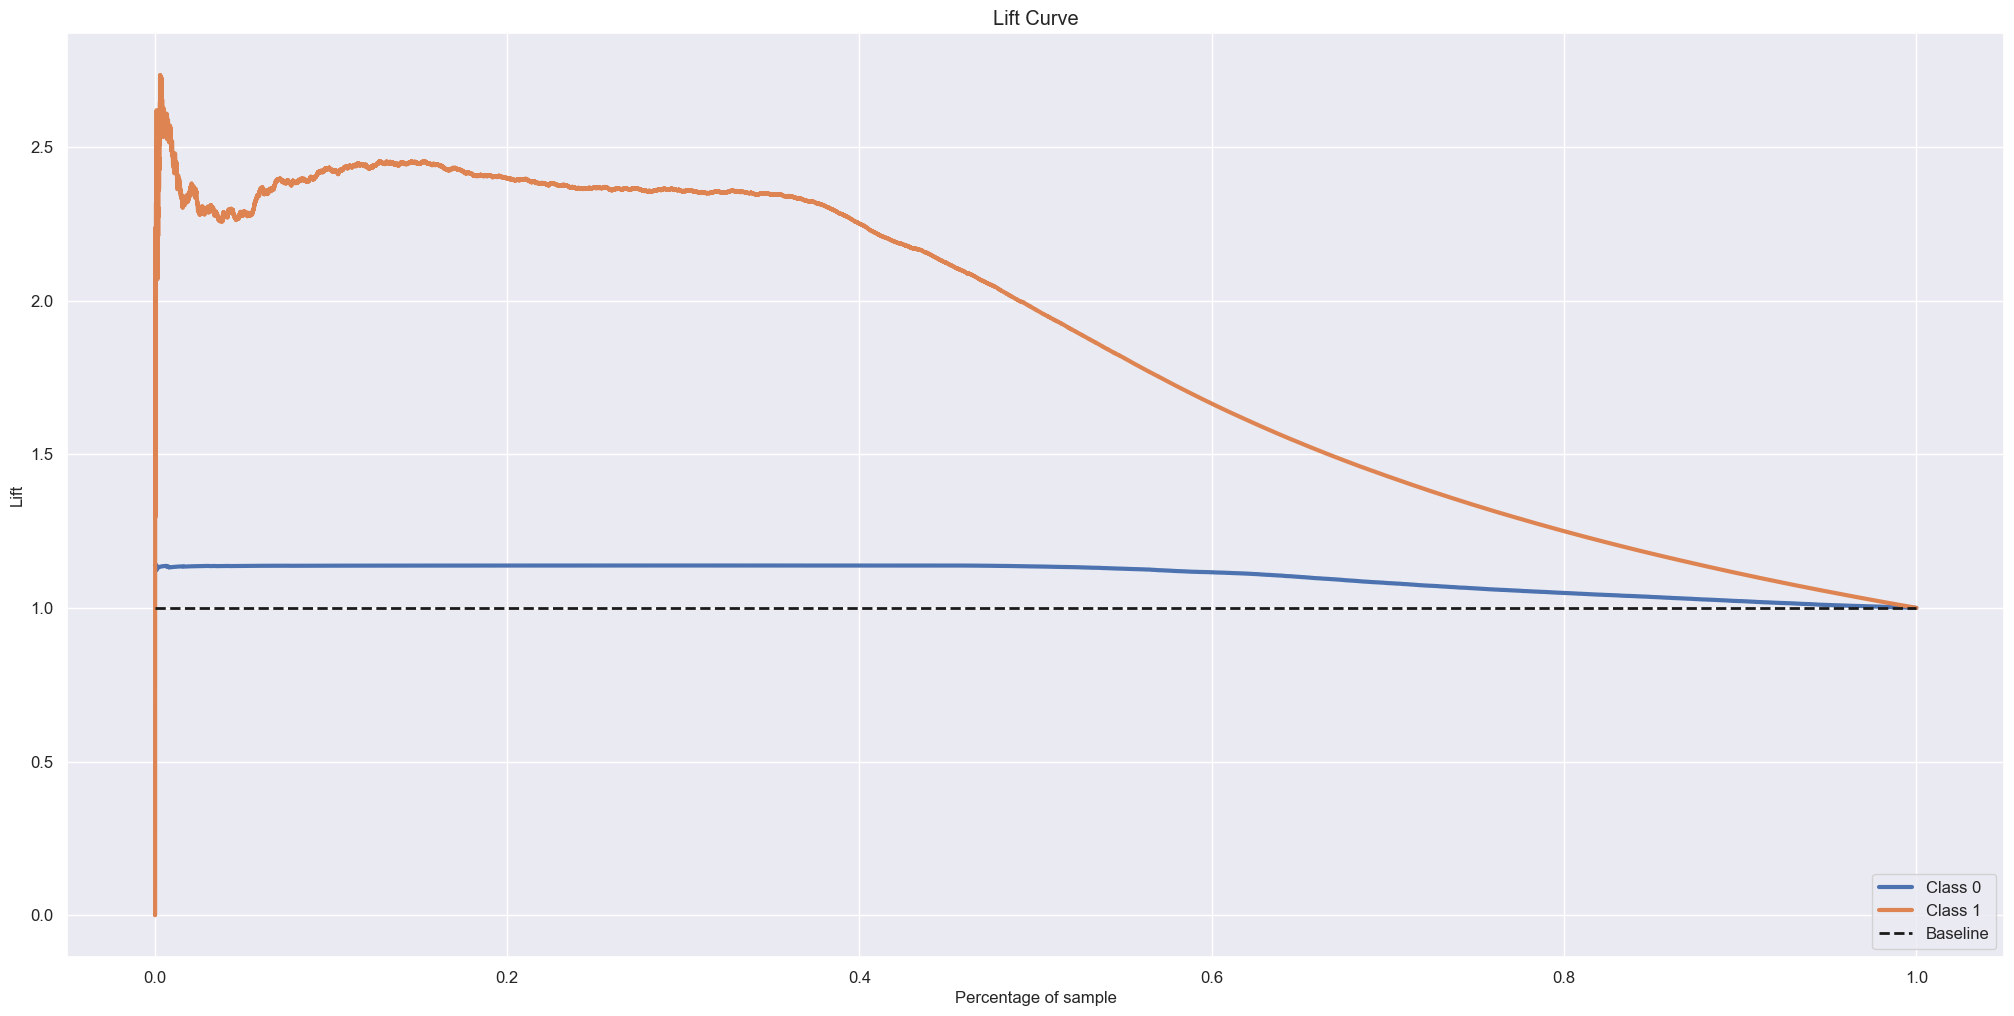

In [78]:
skplt.metrics.plot_lift_curve(y_validation,yhat_nb);

# 8.0 - Model Performance

In [59]:
def precision_at_k(df8,k=2000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['precision_k'] = df8['response'].cumsum()/df8['ranking']

    return df8.loc[k,'precision_k']
    
def recall_at_k(df8,k=2000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall_k'] = df8['response'].cumsum()/df8['response'].sum()

    return df8.loc[k,'recall_k']

def gain(df8,yhat_et):

    #propensity score
    df8['score'] = yhat_et[:,1].tolist()

    #sorted by propensity score
    df8 = df8.sort_values('score',ascending=False)
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall'] = df8['response'].cumsum()/df8['response'].sum()
    df8['base_porcentage'] = df8['ranking']/df8.shape[0]
    
    return df8

In [61]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

#propensity score
df8['score'] = yhat_et[:,1].tolist()

#sorted by propensity score
df8 = df8.sort_values('score',ascending=False)

#computing presicion at K
k_def = int(76222 * 0.25)
precision_at_50 = precision_at_k(df8,k=k_def)
print(f'Precision: {precision_at_50}')
precision_at_50

#computing presicion at K
recall_at_50 = recall_at_k(df8,k=k_def)
print(f'\nRecall: {recall_at_50}')

Precision: 0.3003253568429891

Recall: 0.6157073695535235


In [62]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

gain_knn = gain(df8,yhat_knn)
gain_et = gain(df8,yhat_et)
gain_rf = gain(df8,yhat_rf)
gain_xgb = gain(df8,yhat_xgb)
gain_nb = gain(df8,yhat_nb)

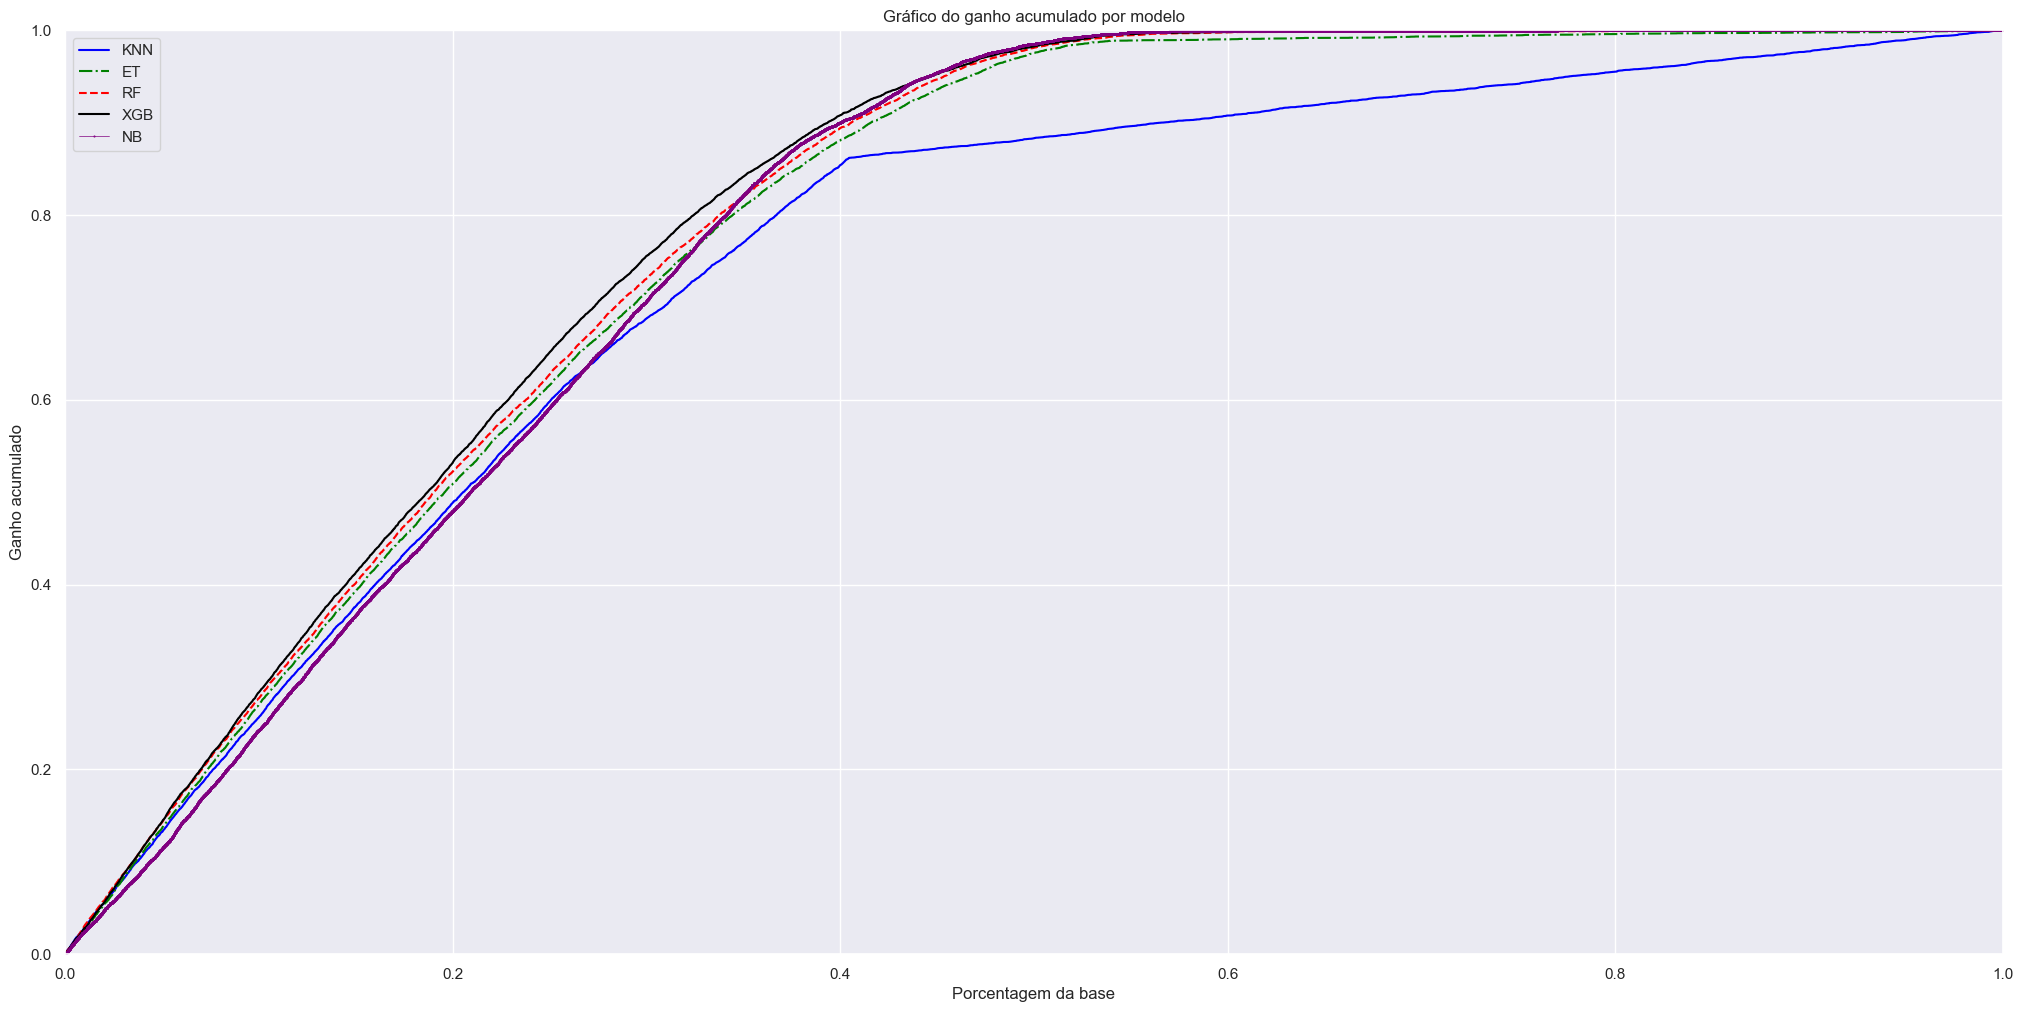

In [63]:
plt.plot(gain_knn['base_porcentage'], gain_knn['recall'], label='KNN', color='blue')
plt.plot(gain_et['base_porcentage'], gain_et['recall'], '-.', label='ET', color='green')
plt.plot(gain_rf['base_porcentage'], gain_rf['recall'], '--', label='RF', color='red')
plt.plot(gain_xgb['base_porcentage'], gain_xgb['recall'], label='XGB', color='black')
plt.plot(gain_nb['base_porcentage'], gain_nb['recall'], '-o', linewidth=0.5, markersize=0.5, label='NB', color='purple')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Porcentagem da base") 
plt.ylabel("Ganho acumulado") 
plt.title("Gráfico do ganho acumulado por modelo")
plt.legend()
plt.show()

In [64]:
k = [50,100,1000,2000,10000,20000,50000]
ganhos = [gain_knn['recall'],gain_et['recall'],gain_rf['recall'],gain_xgb['recall'],gain_nb['recall']]
modelos = ['KNN','Extra Forest','Random Forest','XGBoost','Naive Bayes']
ganhos_modelos = list(zip(ganhos, modelos))
for j in k:
    lista = []
    for ganho, modelo in ganhos_modelos:
        lista.append([modelo,ganho[j]])
    maior_valor = lista[0]
    for i in lista:
        if i[1] > maior_valor[1]:
            maior_valor = i
    print(f'Com os top {j}({round((j/df8.shape[0])*100,2)}%) do total da base, o melhor modelo foi {maior_valor[0]} atingindo {round(maior_valor[1]*100,2)}% daqueles que aceitarão o seguro')

Com os top 50(0.07%) do total da base, o melhor modelo foi KNN atingindo 0.26% daqueles que aceitarão o seguro
Com os top 100(0.13%) do total da base, o melhor modelo foi KNN atingindo 0.45% daqueles que aceitarão o seguro
Com os top 1000(1.31%) do total da base, o melhor modelo foi Random Forest atingindo 3.95% daqueles que aceitarão o seguro
Com os top 2000(2.62%) do total da base, o melhor modelo foi Random Forest atingindo 7.63% daqueles que aceitarão o seguro
Com os top 10000(13.12%) do total da base, o melhor modelo foi XGBoost atingindo 36.65% daqueles que aceitarão o seguro
Com os top 20000(26.24%) do total da base, o melhor modelo foi XGBoost atingindo 67.91% daqueles que aceitarão o seguro
Com os top 50000(65.6%) do total da base, o melhor modelo foi Naive Bayes atingindo 99.9% daqueles que aceitarão o seguro


In [65]:
# Encontrar o índice do valor mínimo que seja maior ou igual à recall desejada
indice = np.argmax(gain_knn['recall'] >= 0.90)
indice

porcentagem = [0.50,0.75,0.80,0.85,0.90,0.95,0.97,0.98]

for porcent in porcentagem:
    lista = []
    for ganho, modelo in ganhos_modelos:
        indice = np.argmax(ganho >= porcent)
        lista.append([modelo,indice])
        menor_valor = lista[0]
    for i in lista:
        if i[1] < menor_valor[1]:
            menor_valor = i
    print(f'O melhor modelo é o {menor_valor[0]} atingindo {porcent*100}% daqueles que aceitarão o seguro com ({menor_valor[1]}) tentativas, ({round((menor_valor[1]/df8.shape[0])*100,2)}%) da base total')

O melhor modelo é o XGBoost atingindo 50.0% daqueles que aceitarão o seguro com (14251) tentativas, (18.7%) da base total
O melhor modelo é o XGBoost atingindo 75.0% daqueles que aceitarão o seguro com (22669) tentativas, (29.74%) da base total
O melhor modelo é o XGBoost atingindo 80.0% daqueles que aceitarão o seguro com (24730) tentativas, (32.44%) da base total
O melhor modelo é o XGBoost atingindo 85.0% daqueles que aceitarão o seguro com (27153) tentativas, (35.62%) da base total
O melhor modelo é o XGBoost atingindo 90.0% daqueles que aceitarão o seguro com (30002) tentativas, (39.36%) da base total
O melhor modelo é o Naive Bayes atingindo 95.0% daqueles que aceitarão o seguro com (33946) tentativas, (44.54%) da base total
O melhor modelo é o Naive Bayes atingindo 97.0% daqueles que aceitarão o seguro com (35791) tentativas, (46.96%) da base total
O melhor modelo é o Naive Bayes atingindo 98.0% daqueles que aceitarão o seguro com (37259) tentativas, (48.88%) da base total


## Com isso o melhor modelo escolhido foi o XGBoost

In [67]:
#Definindo parâmetros aleatórios para o Random Search
param = {
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]}

max_eval = 5

In [68]:
resultados = []
for i in range(max_eval):
    #choose valores for parameters randomly
    hp = {k: random.choice(v) for k, v in param.items()}
    print(hp)
    model_xgb = xgb.XGBClassifier( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'])

    # Treinando o modelo
    model_xgb.fit(x_train, y_train)

    # Fazendo previsões
    yhat_xgb = model_xgb.predict_proba(x_val)  # Previsão de probabilidade
    resultados.append(yhat_xgb)
    
gain_1 = gain(df8,resultados[0])
gain_2 = gain(df8,resultados[1])
gain_3 = gain(df8,resultados[2])
gain_4 = gain(df8,resultados[3])
gain_5 = gain(df8,resultados[4])

plt.plot(gain_knn['base_porcentage'], gain_1['recall'], label='1', color='blue')
plt.plot(gain_et['base_porcentage'], gain_2['recall'], '-.', label='2', color='green')
plt.plot(gain_rf['base_porcentage'], gain_3['recall'], '--', label='3', color='red')
plt.plot(gain_xgb['base_porcentage'], gain_4['recall'], label='4', color='black')
plt.plot(gain_nb['base_porcentage'], gain_5['recall'], '-o', linewidth=0.5, markersize=0.5, label='5', color='purple')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Porcentagem da base") 
plt.ylabel("Ganho acumulado") 
plt.title("Gráfico do ganho acumulado por modelo")
plt.legend()
plt.show()

k = [50,100,1000,2000,10000,20000,50000]
ganhos = [gain_1['recall'],gain_2['recall'],gain_3['recall'],gain_4['recall'],gain_5['recall']]
modelos = ['1','2','3','4','5']
ganhos_modelos = list(zip(ganhos, modelos))
for j in k:
    lista = []
    for ganho, modelo in ganhos_modelos:
        lista.append([modelo,ganho[j]])
    maior_valor = lista[0]
    for i in lista:
        if i[1] > maior_valor[1]:
            maior_valor = i
    print(f'Com os top {j}({round((j/df8.shape[0])*100,2)}%) do total da base, o melhor teste foi {maior_valor[0]} atingindo {round(maior_valor[1]*100,2)}% daqueles que aceitarão o seguro')

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}


KeyboardInterrupt: 

# 9.0 Treinando o modelo com os valores escolhidos

In [69]:
def precision_at_k(df8,k=2000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['precision_k'] = df8['response'].cumsum()/df8['ranking']

    return df8.loc[k,'precision_k']
    
def recall_at_k(df8,k=2000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall_k'] = df8['response'].cumsum()/df8['response'].sum()

    return df8.loc[k,'recall_k']

def gain(df8,yhat_et):

    #propensity score
    df8['score'] = yhat_et[:,1].tolist()

    #sorted by propensity score
    df8 = df8.sort_values('score',ascending=False)
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall'] = df8['response'].cumsum()/df8['response'].sum()
    df8['base_porcentage'] = df8['ranking']/df8.shape[0]
    
    return df8

Precision: 0.33083345832708366

Recall: 0.7118881118881119


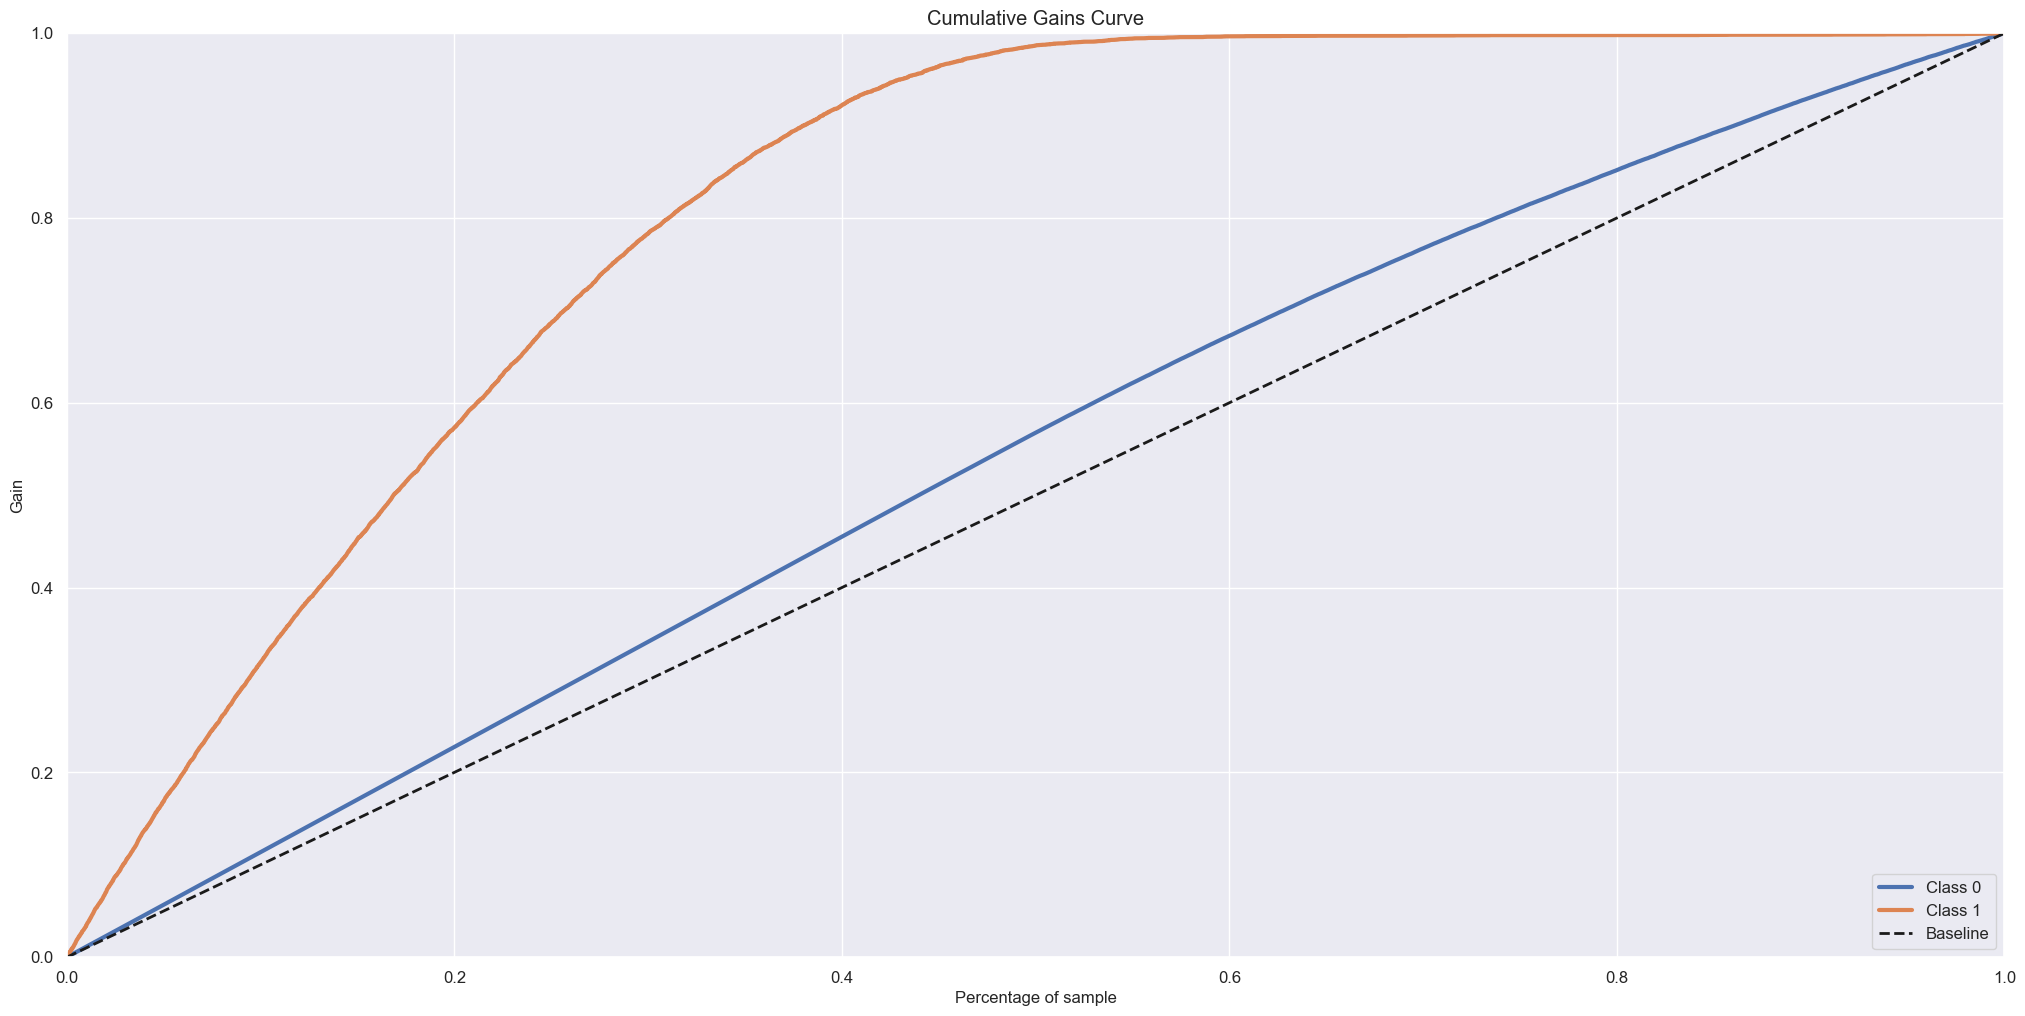

In [70]:
model_xgb = xgb.XGBClassifier( objective='reg:squarederror',
                                  n_estimators=1700,
                                  eta=0.03,
                                  max_depth=5,
                                  subsample=0.5,
                                  colsample_bytree=0.7,
                                  min_child_weight=8)

# Treinando o modelo
model_xgb.fit(x_train, y_train)

# Fazendo previsões
yhat_xgb = model_xgb.predict_proba(x_val)  # Previsão de probabilidade

#Acumilative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_xgb);

df8 = x_validation.copy()
df8['response'] = y_validation.copy()

#propensity score
df8['score'] = yhat_xgb[:,1].tolist()

#sorted by propensity score
df8 = df8.sort_values('score',ascending=False)

#computing presicion at K
k_def = 20000
precision_at_20000 = precision_at_k(df8,k=k_def)
print(f'Precision: {precision_at_20000}')

#computing presicion at K
recall_at_20000 = recall_at_k(df8,k=k_def)
print(f'\nRecall: {recall_at_20000}')

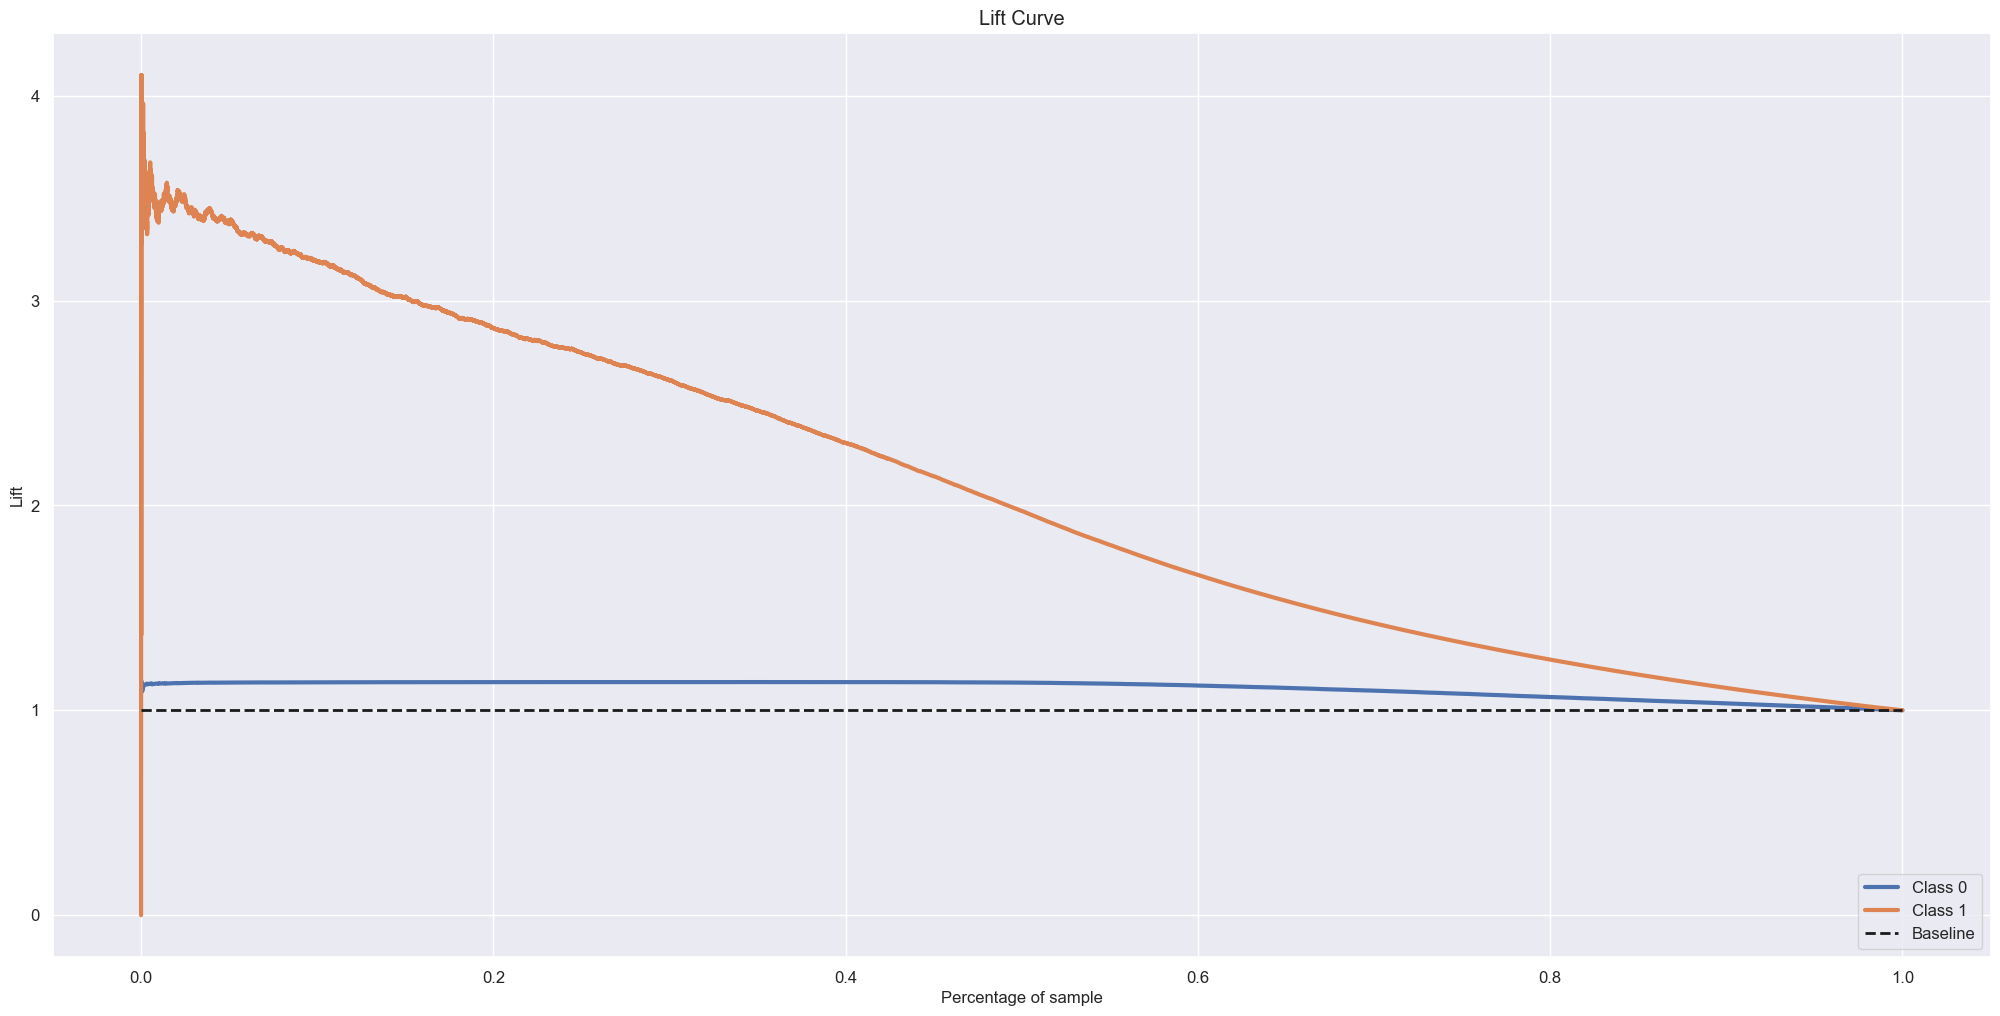

In [71]:
#Curva Lift do modelo escolhido
skplt.metrics.plot_lift_curve(y_validation,yhat_xgb);

#Gerar as outras curvas de lift e comparar, talvez em outro ciclo

In [ ]:
df8.head()

# 9.0 Deploy to Production

In [ ]:
#Salvando o modelo que será usado
with open("C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/models/xgb_model.pkl",'wb') as XGB:
    pickle.dump(model_xgb,XGB)

## 9.1 Health Insurance Class

In [ ]:
class HealthInsurance:
    def __init__(self):
        self.home_path = 'C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/'
        with open(self.home_path + 'src/features/annual_premium_scaler.pkl','rb') as M1:
            self.annual_premmium_scaler   = pickle.load(M1)
        with open(self.home_path + 'src/features/age_scaler.pkl','rb') as M2:
            self.age_scaler   = pickle.load(M2)
        with open(self.home_path + 'src/features/gender_scaler.pkl','rb') as M3:
            self.gender_scaler   = pickle.load(M3)
        with open(self.home_path + 'src/features/policy_sales_channel_scaler.pkl','rb') as M4:
            self.policy_sales_channel_scaler   = pickle.load(M4)
        with open(self.home_path + 'src/features/region_code_scaler.pkl','rb') as M5:
            self.region_code_scaler   = pickle.load(M5)
        with open(self.home_path + 'src/features/vintage_scaler.pkl','rb') as M6:
            self.vintage_scaler   = pickle.load(M6)
            
    def data_cleaning(self,df1):
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
               'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
               'policy_sales_channel', 'vintage', 'response']
        #Renomeando o nome das colunas
        df1.columns = cols_new
        
        return df1

    def feature_engeneering(self,df2):
        #vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year')
        #vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return df2
    
    def data_preparation(self,df5):

        ## Standardization
        #annual_premium
        df5['annual_premium'] = self.annual_premmium_scaler.transform(df5[['annual_premium']].values) #Precisa estar um array para funcionar


        ## Rescaling
        #age - distribuição longe da normal
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        #vintage
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        ## Encoder
        #Para descobrir o melhor encoding tem que testar
        #Label Encoding - 0 ou 1
        #One Hot Encoding - Indica um estado
        #gender
        df5.loc[:,'gender'] = df5['gender'].map(self.gender_scaler)


        #region_code -  / Frequency Encoding / Target Encoding / Weighted Target Encoding
        #Tem muitas categorias, mais de 6, não usa o One Hoting Encoding, aumentaria muito a dimensionalidade do dataset
        df5.loc[:,'region_code'] = df5['region_code'].map(self.region_code_scaler) #Todas as linhas recebem os valores
        #Substitui a feature com base na variável resposta

        #vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

        #policy_sales_channel - distribuição muito uniforme - Target Encoding / Frequency Encoding
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)
        #Frequência que ela aparece

        cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

        return df5[cols_selected]
    
    
    def get_predict(self,model,original_data,test_data):
        #model prediction
        pred = model.predict_proba(test_data)
        
        #join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records',data_format='iso')


## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask,request,Response
from healthinsurance import HealthInsurance

#loading model
path = 'C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/pa004/projeto_teste/health_insurance_ian/'
with open(path + 'models/xgb_model.pkl','rb') as MODEL:
            model   = pickle.load(MODEL)

#inicializar a API
app = Flask(__name__)

@app.route('/predict',methods=['POST']) #API só recebe

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json,dict): #recebi uma linha
            test_raw = pd.DataFrame(test_json,index[0])
            
            
        else: #recebi mais de uma linha
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
            
            
        pipeline = HealthInsurance()
        #Aplicando as funções para deixar os dados prepatados para a predição
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engeneering(df1)
        df3 = pipiline.data_preparation(df2)
        df_response = pipeline.get_predict(model,test_raw,df3)
        
        return df_response
    
    else:
        return Response('{}',status=200,mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0',debug=True)

## 9.3 API Tester

In [79]:
import requests

In [80]:
#loading test dataset
df_test = df1.copy()
#df_test['response'] = y_validation

In [81]:
#df_test_raw = pd.read_csv("C:/Users/ian-g/Downloads/archive 2/test.csv")
#df_test_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [87]:
df_test = df1.sample(30000)

In [88]:
data = json.dumps(df_test.to_dict(orient='records'))

In [89]:
#API CALL
#url = 'http://127.0.0.1:5000/predict'
url = 'https://healthinsurance-in-production-ian.onrender.com/predict'
header = {'Content-type':'application/json'}

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [90]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())
d1 = d1.sort_values('score',ascending=False)
d1 = d1.reset_index(drop=True)

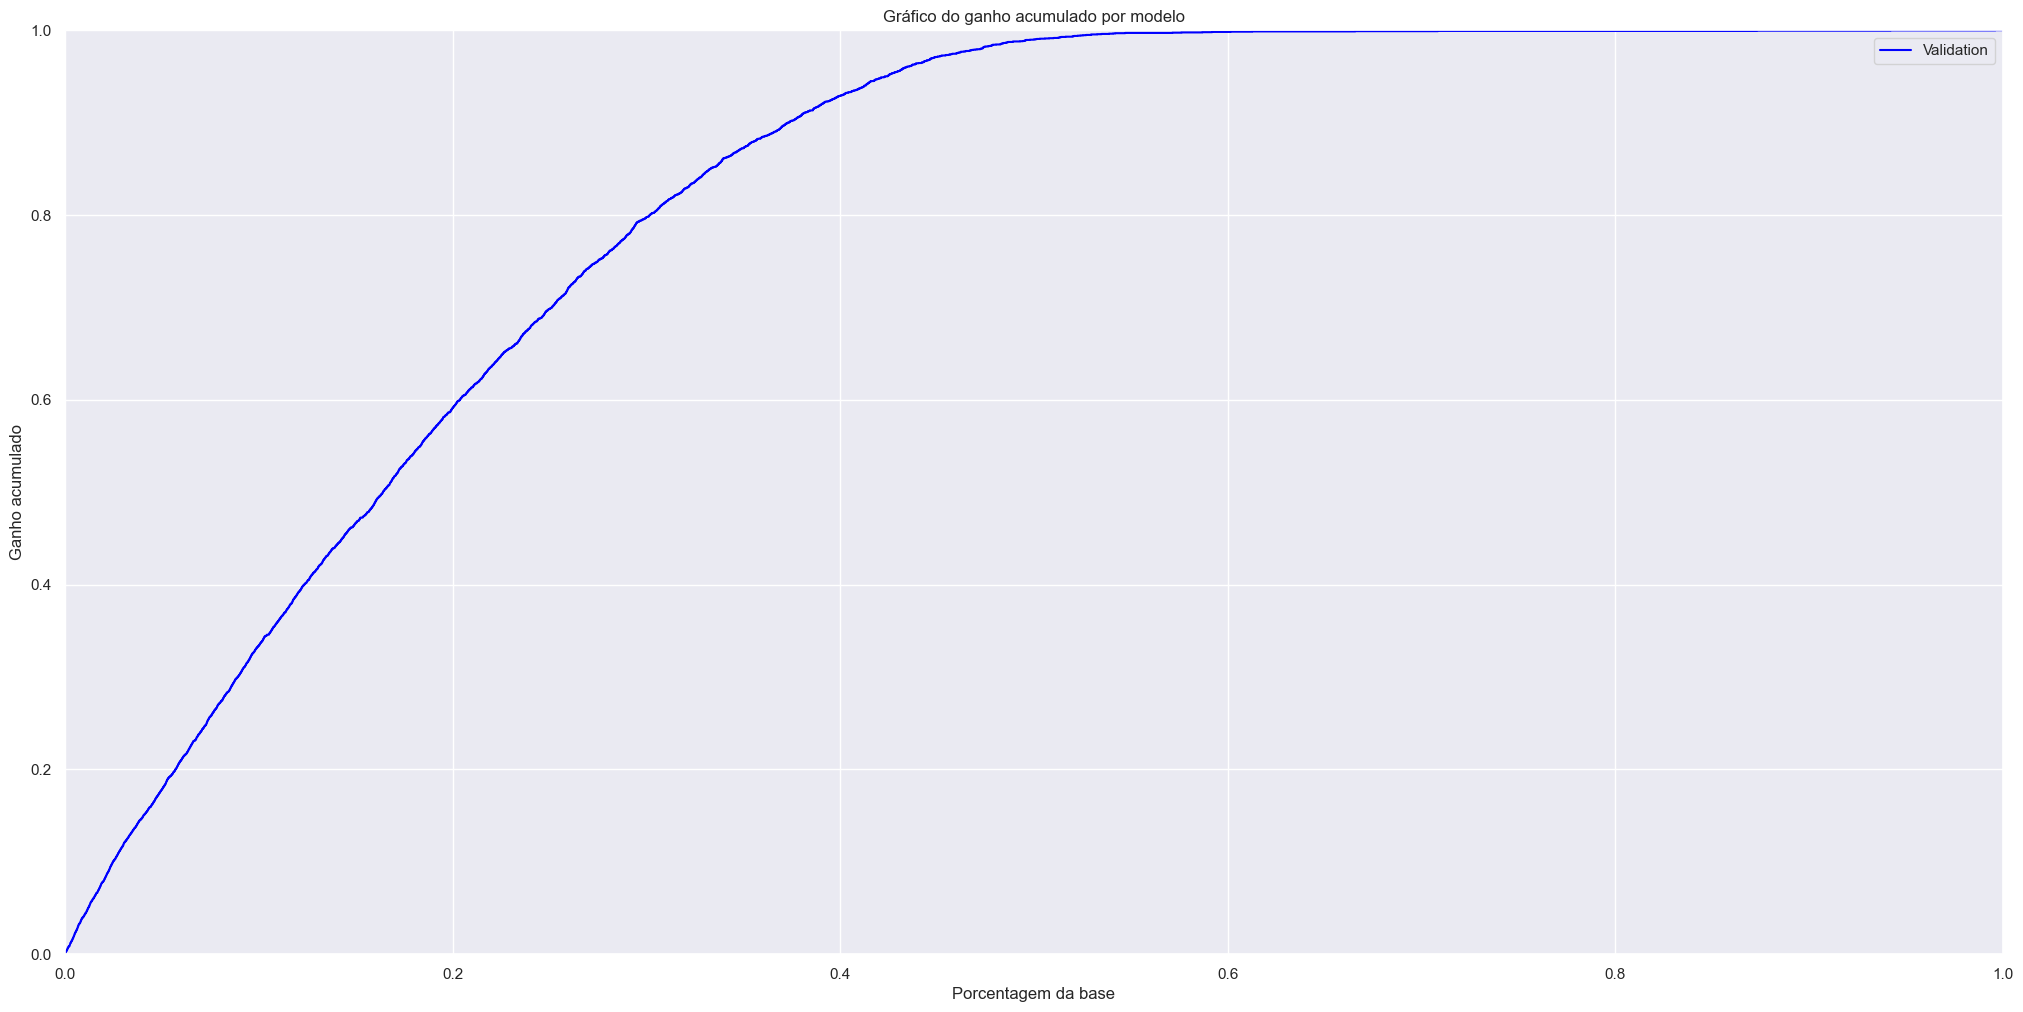

In [91]:
#create ranking order
d1['ranking'] = d1.index + 1 #Pra não começar do 0

#cumsum - soma acumulada
d1['recall'] = d1['response'].cumsum()/d1['response'].sum()
d1['base_porcentage'] = d1['ranking']/d1.shape[0]

plt.plot(d1['base_porcentage'], d1['recall'], label='Validation', color='blue')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Porcentagem da base") 
plt.ylabel("Ganho acumulado") 
plt.title("Gráfico do ganho acumulado por modelo")
plt.legend()
plt.show()